# Developing a Women's Pro Hockey Expected Goals (xG) Model

#### Brian Johns, February 2026

## Notebook #3: Modelling

In notebook #2, I conducted exploratory data analysis and feature engineering in order to prepare the data for modelling.  Here I will explore different classification models to predict the probability of whether shots will be goals which will be the foundation of the xG model.  I will evaluate the models using Log Loss and AUC to pick the most accurate method to build the xG model.

In this notebook, I will do the following:

1. [Load Data and Set-Up](#loading)
2. [Logistic Regression Modelling](#logreg)
3. [Exploratory Data Analysis](#eda)
4. [Prep Data For Modelling](#prepping)

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (accuracy_score, log_loss, classification_report,
                              confusion_matrix, roc_auc_score, roc_curve,
                              precision_recall_curve, average_precision_score)
from sklearn.calibration import calibration_curve
from xgboost import plot_importance
import warnings

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
PWHL = {
    "purple":    "#6B3FA0",
    "purple_lt": "#9B6FD0",
    "purple_dk": "#3D1F6B",
    "gold":      "#C4952A",
    "goal_red":  "#C0394A",
    "silver":    "#4A4460",
    "muted":     "#C8C2D8",
    "bg":        "#EDEAF2",
    "bg2":       "#F7F5FA",
    "white":     "#FFFFFF",
}

def pwhl_theme():
    """Apply PWHL seaborn theme globally."""
    sns.set_theme(style="whitegrid", rc={
        "axes.facecolor":    PWHL["bg2"],
        "figure.facecolor":  PWHL["bg"],
        "axes.edgecolor":    PWHL["muted"],
        "axes.labelcolor":   PWHL["silver"],
        "grid.color":        PWHL["muted"],
        "grid.linewidth":    0.6,
        "xtick.color":       PWHL["silver"],
        "ytick.color":       PWHL["silver"],
        "text.color":        PWHL["silver"],
        "font.family":       "monospace",
        "axes.spines.top":   False,
        "axes.spines.right": False,
    })

<a id = 'loading'></a>

## 1. Load Data and Set-Up

In [3]:
df = pd.read_csv('model_data.csv')

In [4]:
y = df['is_goal']
X = df.drop(['is_goal'], axis = 1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=29,
                                                    stratify=y)

In [6]:
X_train.head(3)

home_team_skaters  away_team_skaters  period_1  period_2  period_3  \
9170                   5                  5         0         0         1   
10828                  5                  5         1         0         0   
8187                   5                  5         1         0         0   

       game_time       x_ft       y_ft      y_abs  dist_ft  angle_deg  \
9170      2802.0  65.000000 -13.271930  13.271930     27.4       28.9   
10828       94.0  60.333333   8.201754   8.201754     29.8       16.0   
8187       356.0  64.666667  16.552632  16.552632     29.4       34.2   

       arclength  shooter_quality  shooter_career_quality  goalie_save_pct  \
9170   13.820564         0.135942                0.141337         0.929026   
10828   8.321730         0.068236                0.076763         0.920099   
8187   17.548937         0.095811                0.108626         0.930239   

       goalie_career_save_pct  home_score  away_score  goal_diff  losing  \
9170                 0.919168           1           1          0       0   
10828                0.919168           0           0          0       0   
8187                 0.928881           0           0          0       0   

       tied  winning  skater_diff  es  pp  sh  rebound  backhand  other  slap  \
9170      1        0            0   1   0   0        0         0      0     0   
10828     1        0            0   1   0   0        0         0      0     0   
8187      1        0            0   1   0   0        0         0      0     0   

       snap  tip  wrist  slot  close_game  late_game  is_forward  pwhl  
9170      0    0      1     1           1          0           1     1  
10828     1    0      0     1           1          0           1     1  
8187      0    0      1     0           1          0           1     1

In [7]:
X_test.head(3)

home_team_skaters  away_team_skaters  period_1  period_2  period_3  \
5445                   5                  5         0         1         0   
3246                   4                  5         0         1         0   
12858                  5                  5         0         1         0   

       game_time       x_ft       y_ft      y_abs  dist_ft  angle_deg  \
5445      2330.0  63.666667  -1.640351   1.640351     25.4        3.7   
3246      1927.0  63.333333   9.096491   9.096491     27.2       19.5   
12858     1526.0  61.000000  18.938596  18.938596     33.8       34.1   

       arclength  shooter_quality  shooter_career_quality  goalie_save_pct  \
5445    1.640260         0.099041                0.126054         0.914014   
3246    9.257226         0.073142                0.076763         0.912353   
12858  20.116316         0.087013                0.075523         0.909116   

       goalie_career_save_pct  home_score  away_score  goal_diff  losing  \
5445                 0.920784           3           0         -3       1   
3246                 0.920784           1           1          0       0   
12858                0.911145           0           0          0       0   

       tied  winning  skater_diff  es  pp  sh  rebound  backhand  other  slap  \
5445      0        0            0   1   0   0        0         0      1     0   
3246      1        0            1   0   1   0        0         0      0     0   
12858     1        0            0   1   0   0        0         0      0     0   

       snap  tip  wrist  slot  close_game  late_game  is_forward  pwhl  
5445      0    0      0     1           0          0           1     1  
3246      1    0      0     1           1          0           1     1  
12858     0    0      1     0           1          0           0     1

In [8]:
y_train[:3]

9170     0
10828    0
8187     0
Name: is_goal, dtype: int64

In [9]:
y_test[:3]

5445     0
3246     0
12858    0
Name: is_goal, dtype: int64

In preparation for modelling, it is already clear that scaling will be needed for some models.  With the majority of features being boolean (1's/0's) and a small number having continuous numbers (especially `game_time` going int the thousands), this is likely going to skew simpler models.

In [10]:
print(f"The Overall Save Percentage is {round(100-df['is_goal'].mean()*100, 2)}\n\
So guessing Save for EVERY shot would be at least this accurate.\n\
Our models should stay close to this throughout.")

The Overall Save Percentage is 91.87
So guessing Save for EVERY shot would be at least this accurate.
Our models should stay close to this throughout.


I'll use the following to help with model evaluation.  This will help us visualize the effectiveness of the model, along with its overall accuracy.  We will primarily be looking at **AUC** and **Log Loss** when evaluating the quality of the models.

In [11]:
eval_list = []

def model_eval(model, X_test, y_test, model_name="Model", threshold=0.5):
    pwhl_theme()
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred       = (y_pred_proba >= threshold).astype(int)

    model_accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _    = roc_curve(y_test, y_pred_proba)
    auc            = roc_auc_score(y_test, y_pred_proba)
    loss           = log_loss(y_test, y_pred_proba)
    ap             = average_precision_score(y_test, y_pred_proba)

    eval_list.append({
        'model':    model_name,
        'accuracy': round(model_accuracy, 4),
        'auc':      round(auc, 4),
        'log_loss': round(loss, 4),
        'avg_prec': round(ap, 4),
    })

    # --- Print summary ---
    baseline = round(100 - (df['is_goal'].mean() * 100), 2)
    print(f"\n{'='*40}")
    print(f"  {model_name}")
    print(f"{'='*40}")
    print(f"  Baseline (always predict save): {baseline}%")
    print(f"  Accuracy:                       {round(model_accuracy*100, 2)}%")
    print(f"  AUC:                            {round(auc, 3)}")
    print(f"  Log Loss:                       {round(loss, 3)}")
    print(f"  Avg Precision (PR-AUC):         {round(ap, 3)}")
    print(f"\n{classification_report(y_test, y_pred, target_names=['Save', 'Goal'])}")

    fig, axes = plt.subplots(1, 3, figsize=(24, 8), facecolor=PWHL["bg"])

    TITLE_FS  = 20
    LABEL_FS  = 16
    TICK_FS   = 12
    LEGEND_FS = 12
    ANNOT_FS  = 16

    # --- Confusion matrix ---
    ax = axes[0]
    cm = confusion_matrix(y_test, y_pred)
    purple_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "pwhl_purple", [PWHL["bg2"], PWHL["purple_lt"], PWHL["purple_dk"]]
    )
    sns.heatmap(cm, annot=True, fmt='d', cmap=purple_cmap, ax=ax,
                linewidths=0.5, linecolor=PWHL["muted"],
                xticklabels=['Save', 'Goal'],
                yticklabels=['Save', 'Goal'],
                annot_kws={"size": ANNOT_FS, "weight": "bold", "color": PWHL["gold"]})
    ax.set_facecolor(PWHL["bg2"])
    ax.set_xlabel("Predicted", color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_ylabel("Actual",    color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_title("Confusion Matrix", color=PWHL["purple_dk"],
                 fontfamily="monospace", fontweight="bold", fontsize=TITLE_FS)
    ax.tick_params(colors=PWHL["silver"], labelsize=TICK_FS)

    # --- ROC curve ---
    ax = axes[1]
    ax.set_facecolor(PWHL["bg2"])
    ax.plot(fpr, tpr, color=PWHL["purple"], linewidth=2.5,
            label=f"AUC = {round(auc, 3)}")
    ax.plot([0, 1], [0, 1], color=PWHL["muted"], linewidth=1,
            linestyle="--", label="Random")
    ax.set_xlabel("False Positive Rate", color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_ylabel("True Positive Rate",  color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_title("ROC Curve", color=PWHL["purple_dk"],
                 fontfamily="monospace", fontweight="bold", fontsize=TITLE_FS)
    ax.legend(facecolor=PWHL["white"], edgecolor=PWHL["muted"],
              labelcolor=PWHL["silver"], fontsize=LEGEND_FS)
    ax.tick_params(colors=PWHL["silver"], labelsize=TICK_FS)

    # --- Calibration plot ---
    ax = axes[2]
    ax.set_facecolor(PWHL["bg2"])
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
    ax.plot(prob_pred, prob_true, color=PWHL["purple"], linewidth=2.5,
            marker="o", markersize=6, label=model_name)
    ax.plot([0, 1], [0, 1], color=PWHL["gold"], linewidth=1.5,
            linestyle="--", label="Perfect calibration")
    ax.set_xlabel("Mean Predicted Probability", color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_ylabel("Fraction of Positives",      color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_title("Calibration Plot", color=PWHL["purple_dk"],
                 fontfamily="monospace", fontweight="bold", fontsize=TITLE_FS)
    ax.legend(facecolor=PWHL["white"], edgecolor=PWHL["muted"],
              labelcolor=PWHL["silver"], fontsize=LEGEND_FS)
    ax.tick_params(colors=PWHL["silver"], labelsize=TICK_FS)

    fig.suptitle(model_name, color=PWHL["purple_dk"],
                 fontfamily="monospace", fontsize=24, fontweight="bold", y=1.02)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.tight_layout()

    display(fig)
    plt.close(fig)

<a id = 'logreg'></a>

## 2. Logistic Regression Modelling

In [12]:
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



  Base Logistic Regression
  Baseline (always predict save): 91.87%
  Accuracy:                       91.85%
  AUC:                            0.748
  Log Loss:                       0.252
  Avg Precision (PR-AUC):         0.199

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.00      0.00      0.00       271

    accuracy                           0.92      3338
   macro avg       0.46      0.50      0.48      3338
weighted avg       0.84      0.92      0.88      3338



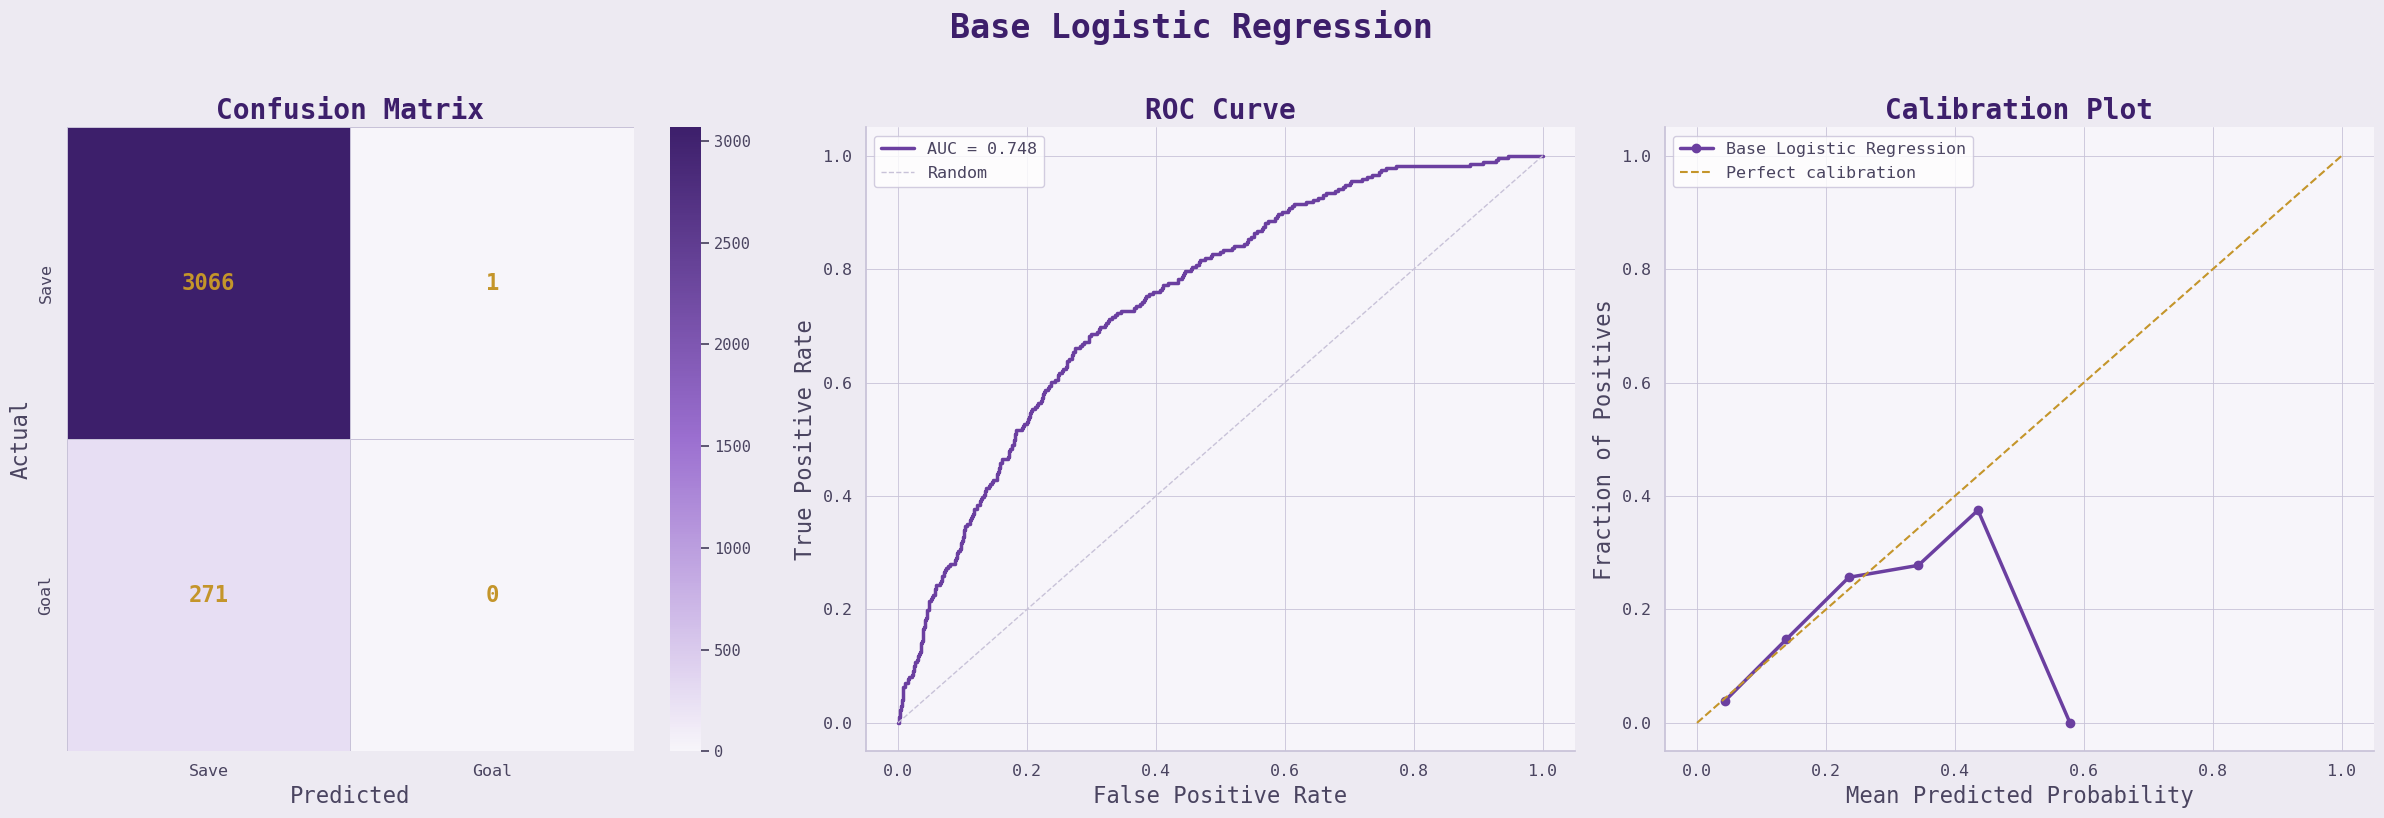

In [13]:
model_eval(logreg, X_test, y_test, "Base Logistic Regression")

Using all of the data, it's very clear that scaling will be needed.  I will try a more minimalist Logistic Regression based on the EDA performed in the previous notebook and see if there's anything that could be learned.  This will use only `x_ft`, `y_abs`, `rebound`, `slot`, `shooter_career_quality` and `goalie_career_save_pct`.

In [14]:
selected_cols = ['x_ft', 'y_abs', 'rebound', 'slot', 'shooter_career_quality', 'goalie_career_save_pct']

In [15]:
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(X_train[selected_cols], y_train)
y_pred = logreg.predict(X_test[selected_cols])


  Selected Logistic Regression
  Baseline (always predict save): 91.87%
  Accuracy:                       91.88%
  AUC:                            0.715
  Log Loss:                       0.26
  Avg Precision (PR-AUC):         0.185

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.00      0.00      0.00       271

    accuracy                           0.92      3338
   macro avg       0.46      0.50      0.48      3338
weighted avg       0.84      0.92      0.88      3338



/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

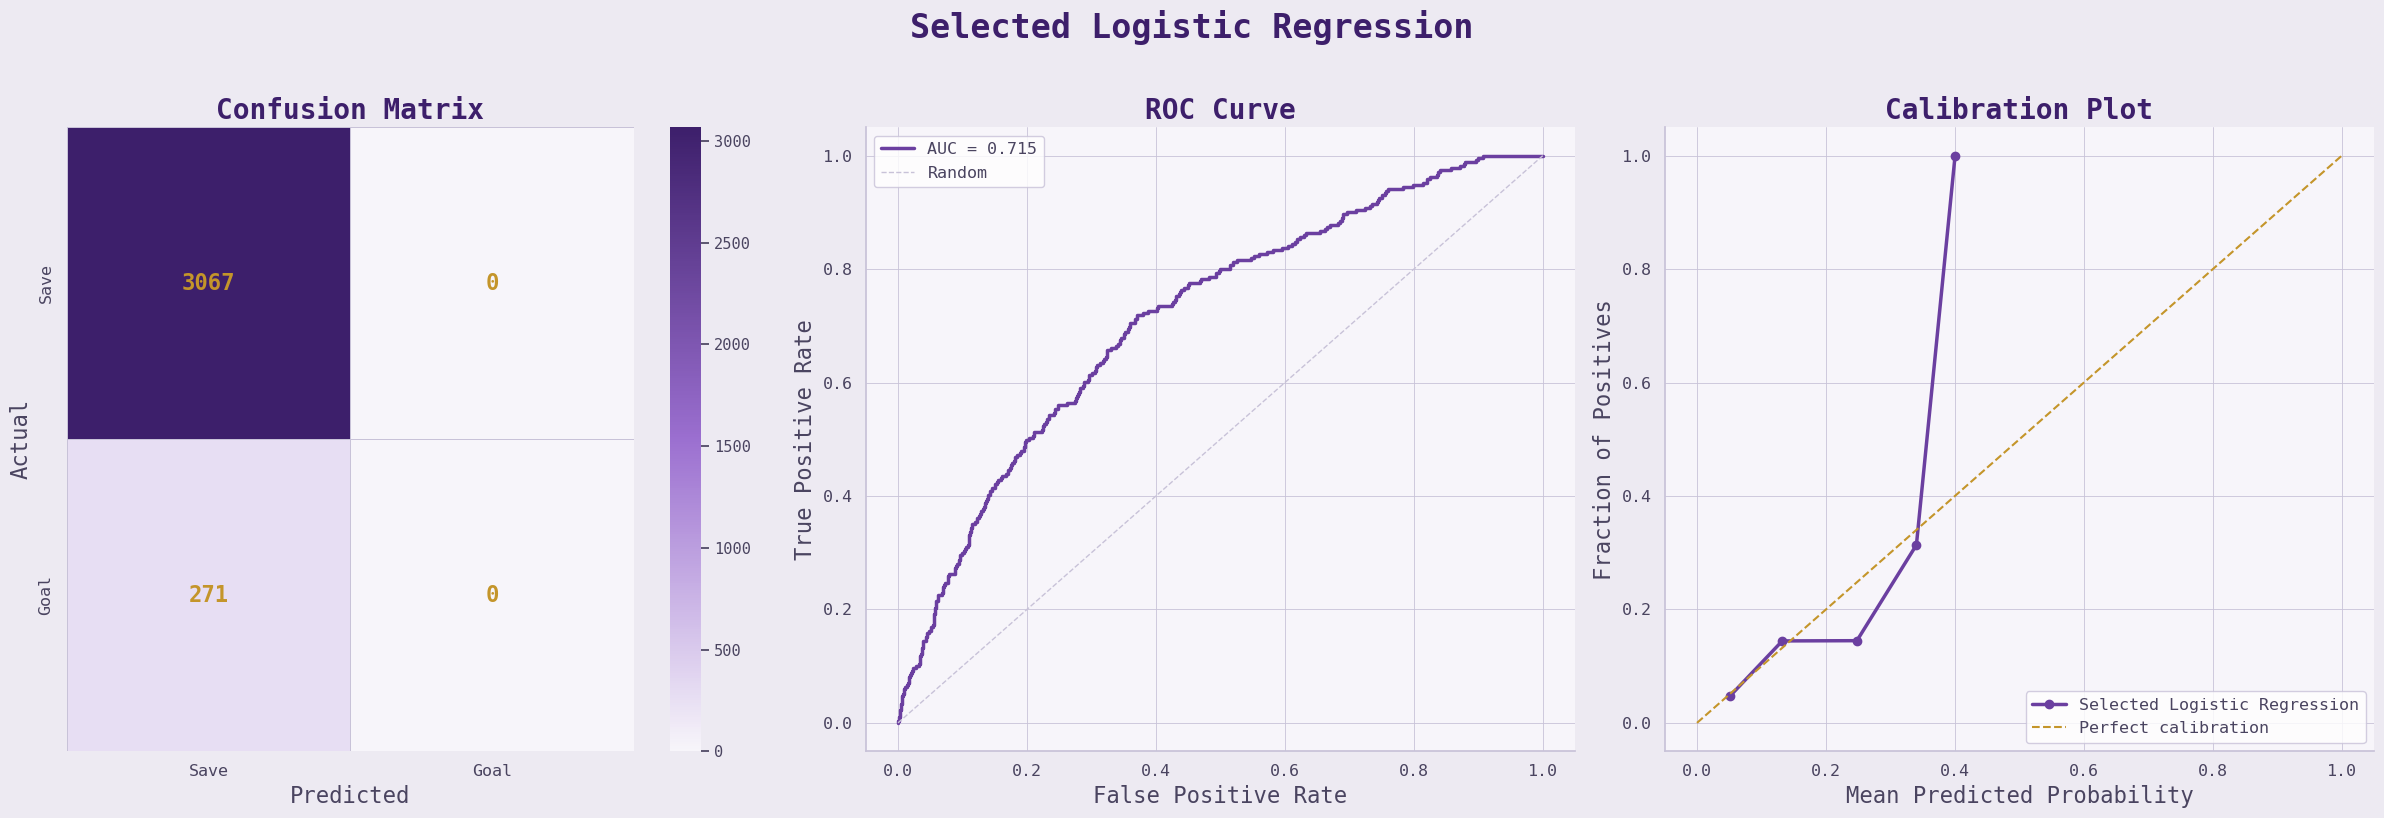

In [16]:
model_eval(logreg, X_test[selected_cols], y_test, "Selected Logistic Regression")

Both models essentially just guessed 'Save' for everything, so it is clear that scaling will be required to get a more meaningful model.

I am going to separate the continuous numerical columns and the boolean columns and experiment with using different scalers on the full dataset first, then on the selected features after.

Here we are going to make some adjustments to the features.
`home_team_skaters` and `away_team_skaters` are both captured by `skater_diff` and the different strength states, so we will not use them from here on out.

We'll keep all of the positional data (`x_ft`, `y_abs` and `angle_deg`) along with `arc_length` because it could be the case that one side is more accurate than the other, but for most modelling I will likely not include `arc_length` unless to simplify the model, but it still needs to be scaled.



In [17]:
df.head(1)

home_team_skaters  away_team_skaters  period_1  period_2  period_3  \
0                  5                  5         1         0         0   

   game_time       x_ft       y_ft      y_abs  dist_ft  angle_deg  arclength  \
0  30.266666  75.142281  15.844118  15.844118     21.0       48.8  17.886134   

   shooter_quality  shooter_career_quality  goalie_save_pct  \
0         0.081256                0.061335         0.918744   

   goalie_career_save_pct  home_score  away_score  goal_diff  losing  tied  \
0                0.926386           0           0          0       0     1   

   winning  skater_diff  es  pp  sh  rebound  backhand  other  slap  snap  \
0        0            0   1   0   0        0         0      0     0     1   

   tip  wrist  slot  close_game  late_game  is_forward  pwhl  is_goal  
0    0      0     0           1          0           1     0        0

In [18]:
continuous_col = ['game_time','x_ft', 'y_ft', 'y_abs', 'dist_ft', 'angle_deg', 'arclength',
                  'shooter_quality', 'shooter_career_quality', 'goalie_save_pct', 'goalie_career_save_pct',
                  'home_score', 'away_score', 'goal_diff', 'skater_diff']

In [19]:
boolean_col = ['losing', 'tied', 'winning', 'es', 'pp', 'sh', 'rebound',
            'backhand', 'other', 'slap', 'snap', 'tip', 'wrist', 
            'slot', 'close_game', 'late_game', 'is_forward', 'pwhl']

In [20]:
X_train = X_train[continuous_col+boolean_col]
X_test = X_test[continuous_col+boolean_col]


  Log Reg — Full Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       91.91%
  AUC:                            0.774
  Log Loss:                       0.244
  Avg Precision (PR-AUC):         0.242

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.55      0.02      0.04       271

    accuracy                           0.92      3338
   macro avg       0.73      0.51      0.50      3338
weighted avg       0.89      0.92      0.88      3338



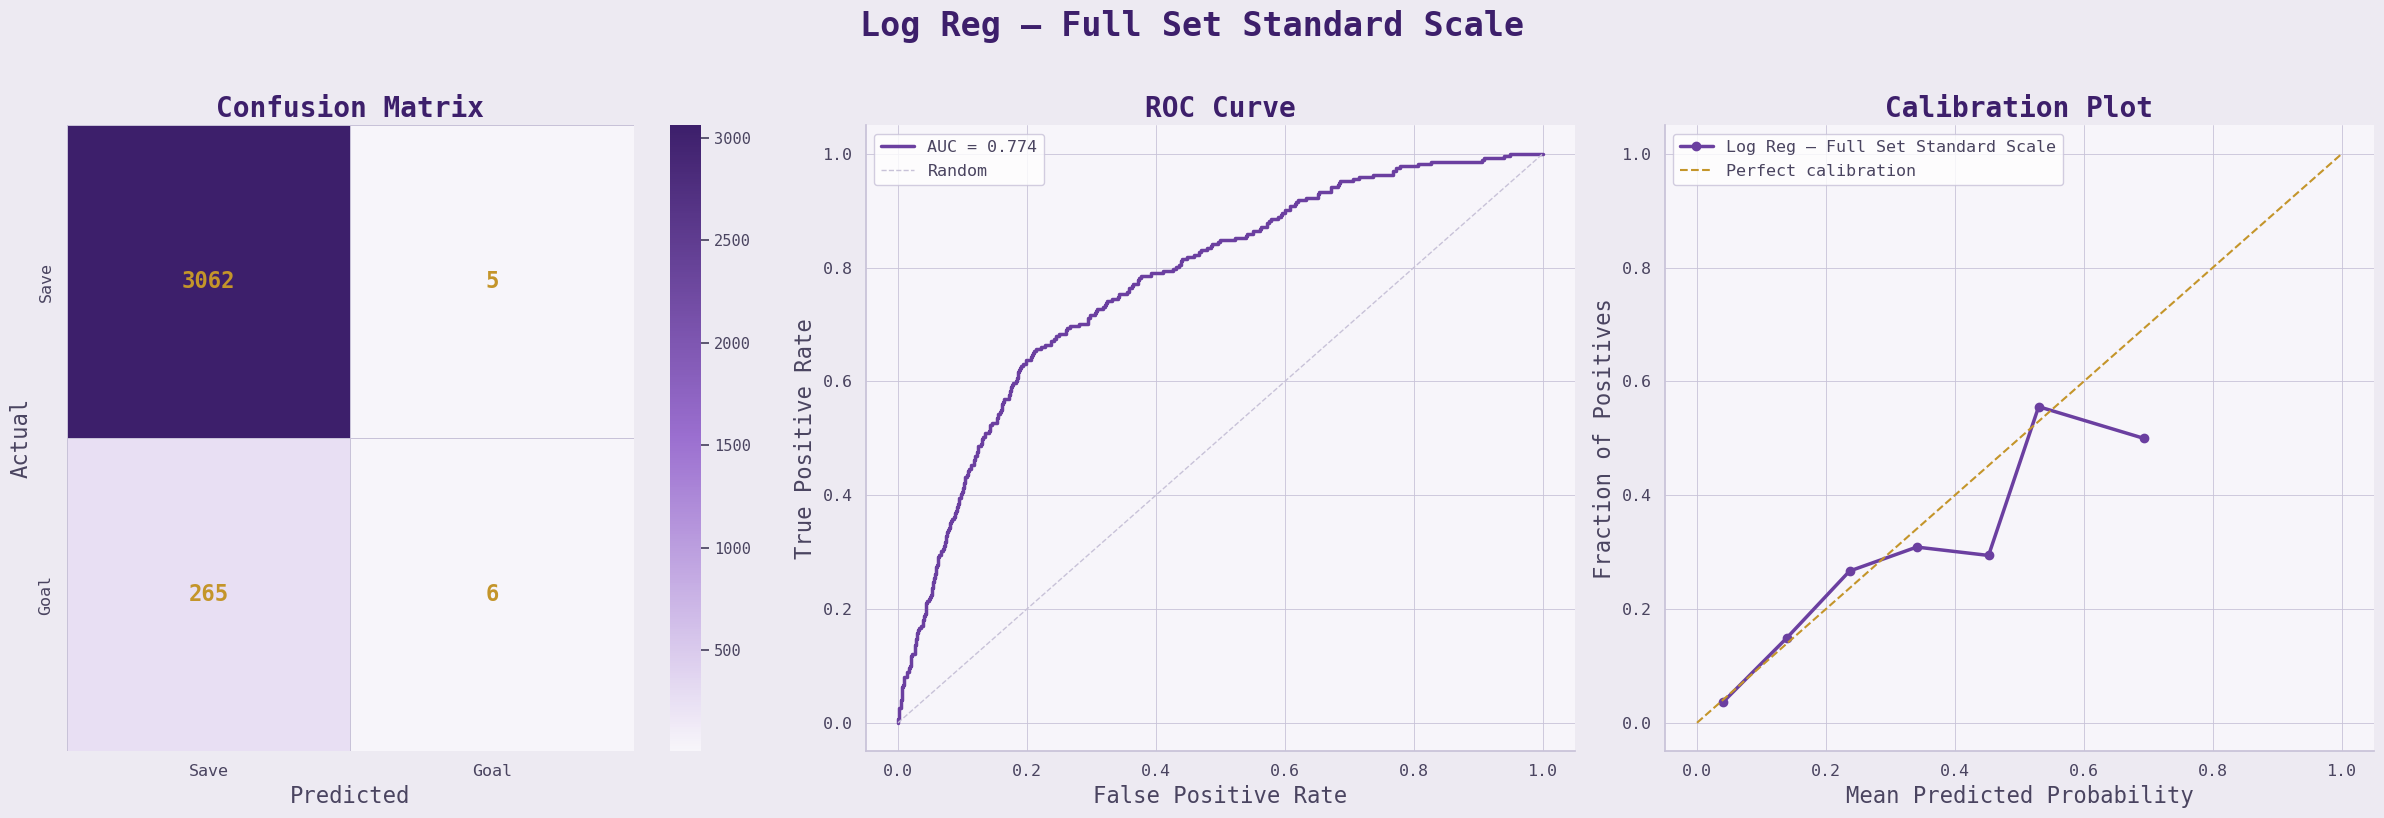

In [21]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(random_state=29))
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, model_name="Log Reg — Full Set Standard Scale")


  Log Reg - Full Set MinMax Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       91.85%
  AUC:                            0.771
  Log Loss:                       0.245
  Avg Precision (PR-AUC):         0.237

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.44      0.01      0.03       271

    accuracy                           0.92      3338
   macro avg       0.68      0.51      0.49      3338
weighted avg       0.88      0.92      0.88      3338



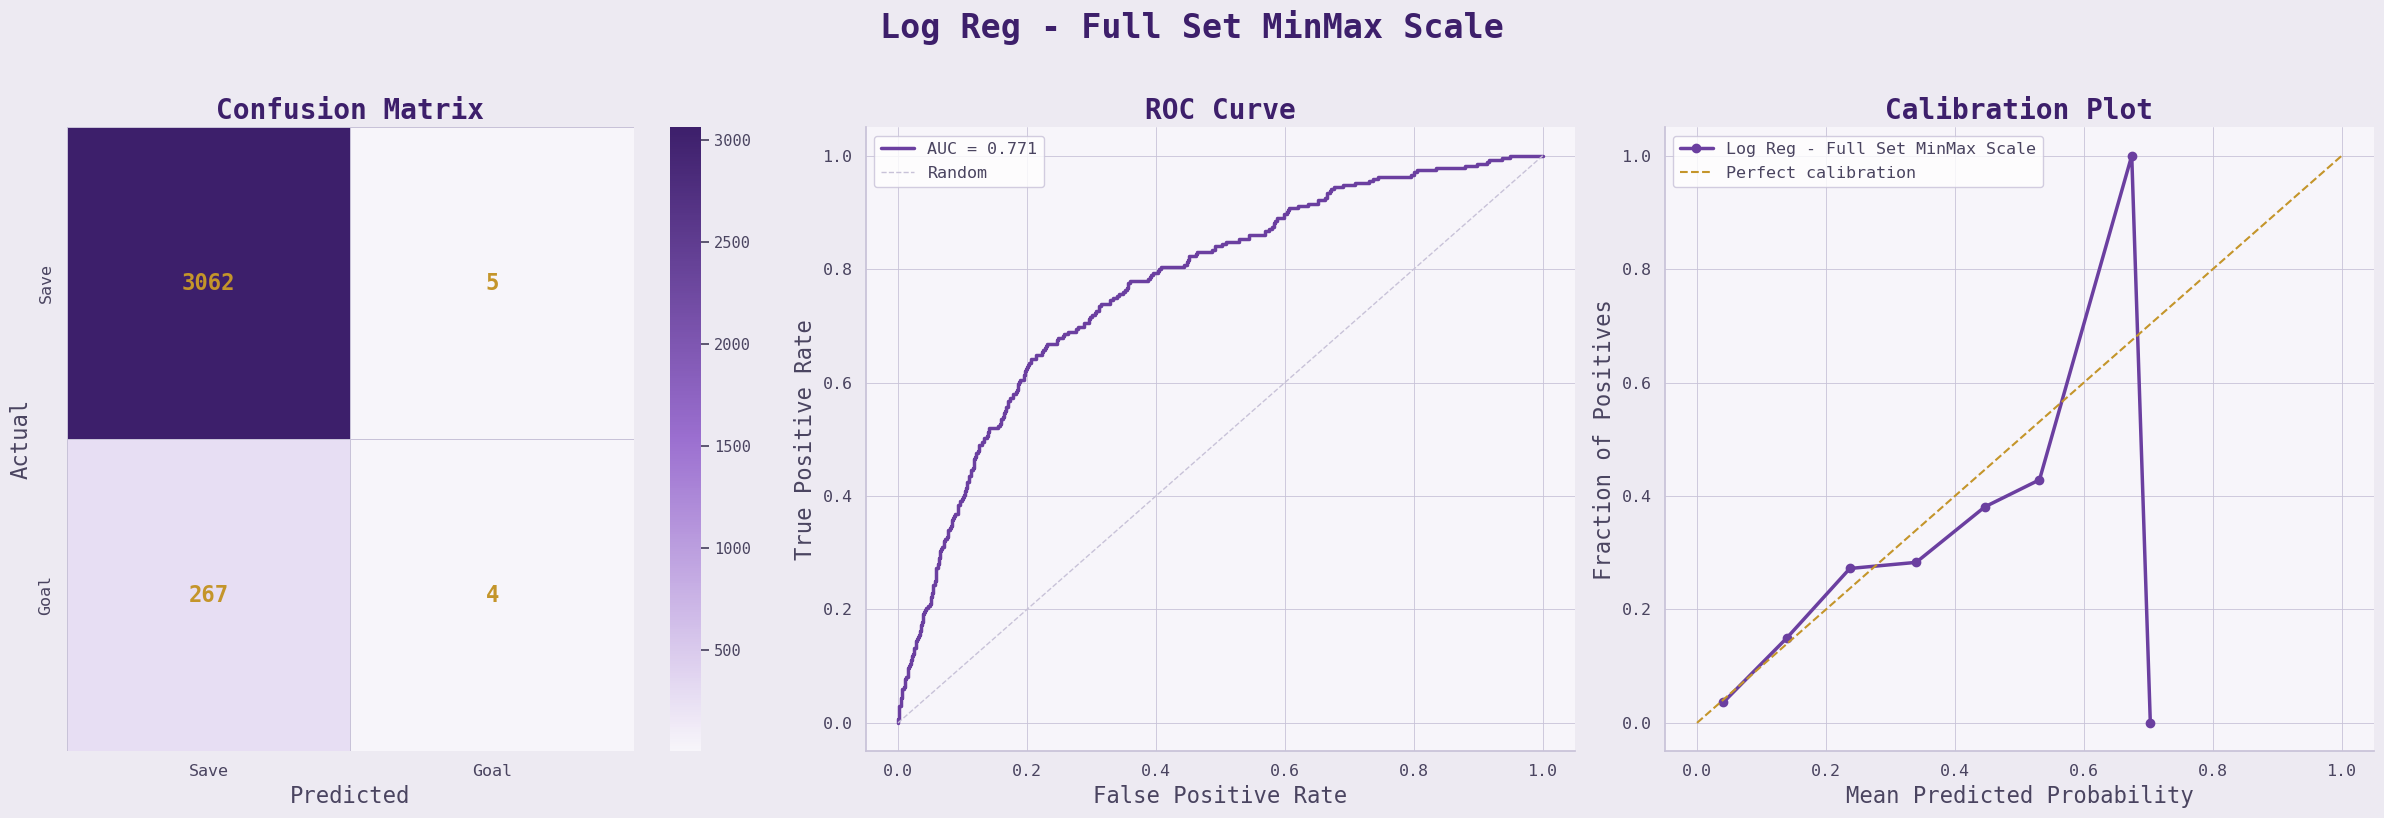

In [22]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(random_state=29))
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, "Log Reg - Full Set MinMax Scale")

In [23]:
continuous_col_sel = [c for c in continuous_col if c in selected_cols]
boolean_col_sel    = [c for c in boolean_col    if c in selected_cols]


  Selected Log Reg - Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       91.85%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.33      0.00      0.01       271

    accuracy                           0.92      3338
   macro avg       0.63      0.50      0.48      3338
weighted avg       0.87      0.92      0.88      3338



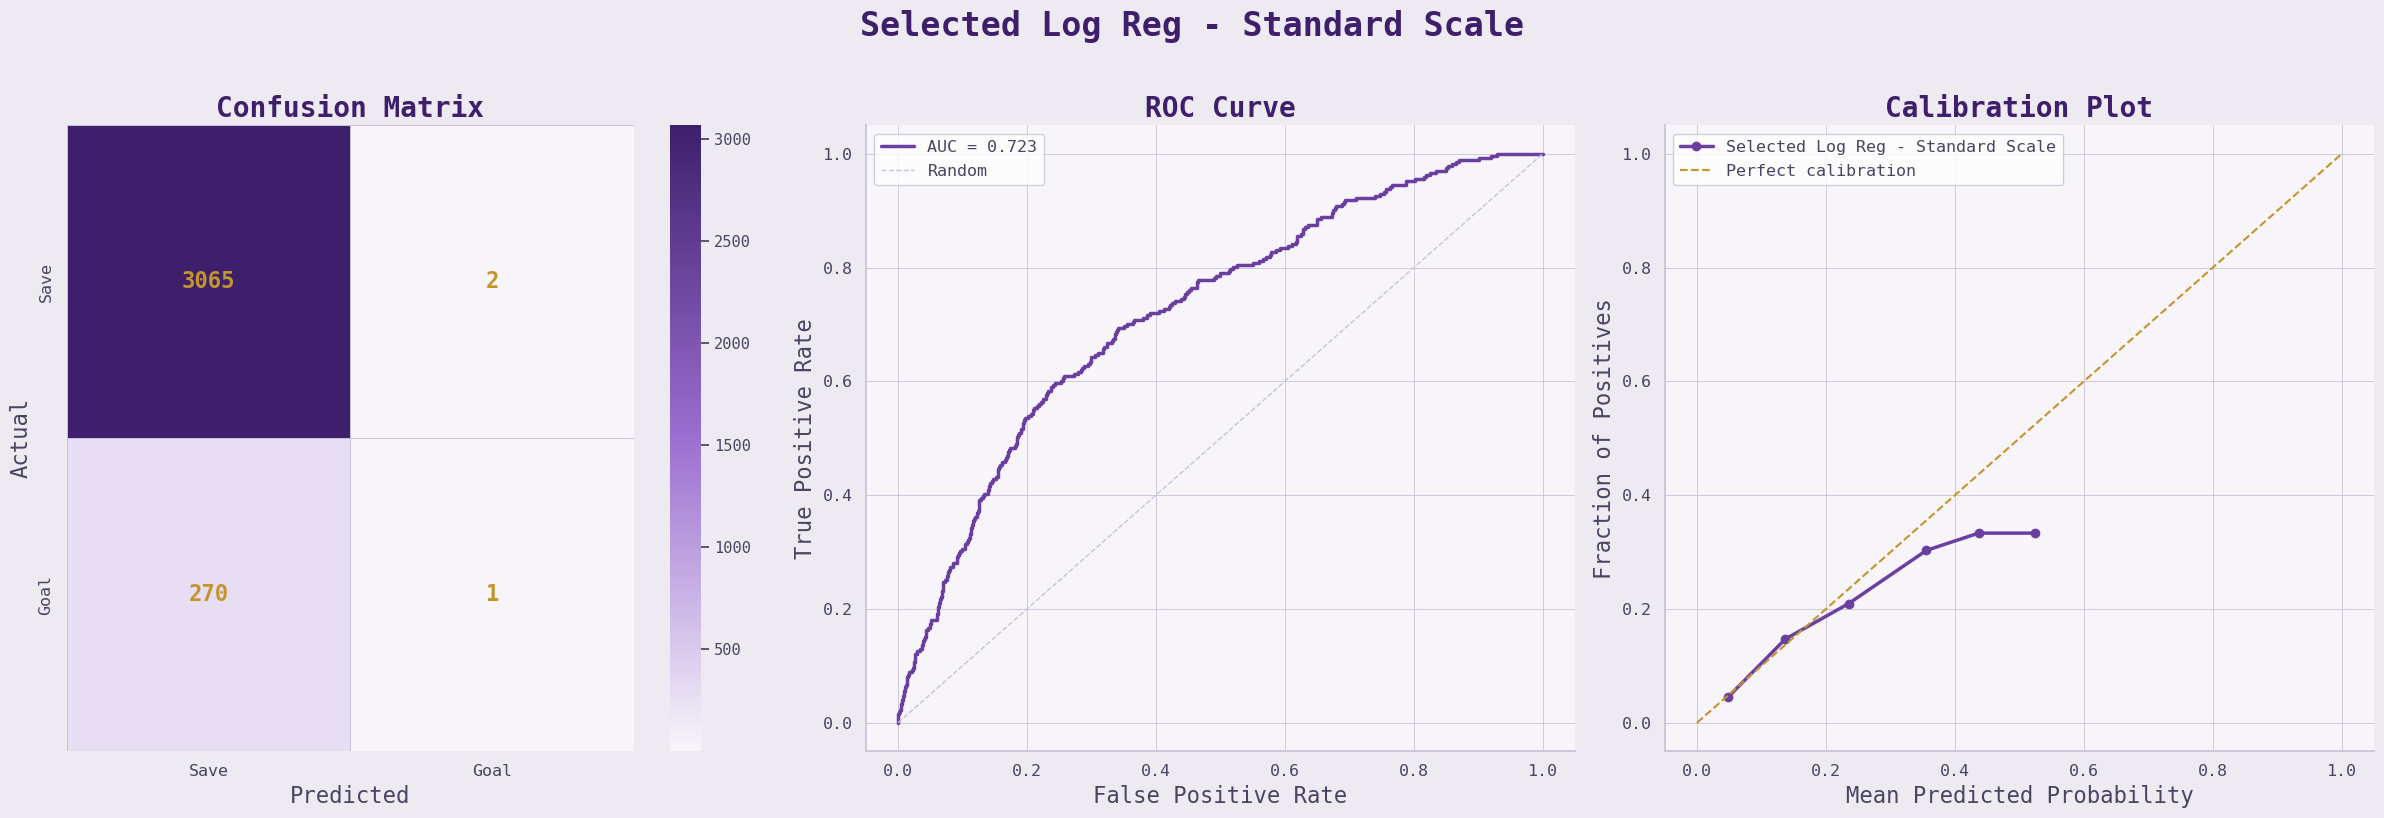

In [24]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(random_state=29))
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, "Selected Log Reg - Standard Scale")


  Selected Log Reg - MinMax Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       91.88%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.50      0.00      0.01       271

    accuracy                           0.92      3338
   macro avg       0.71      0.50      0.48      3338
weighted avg       0.89      0.92      0.88      3338



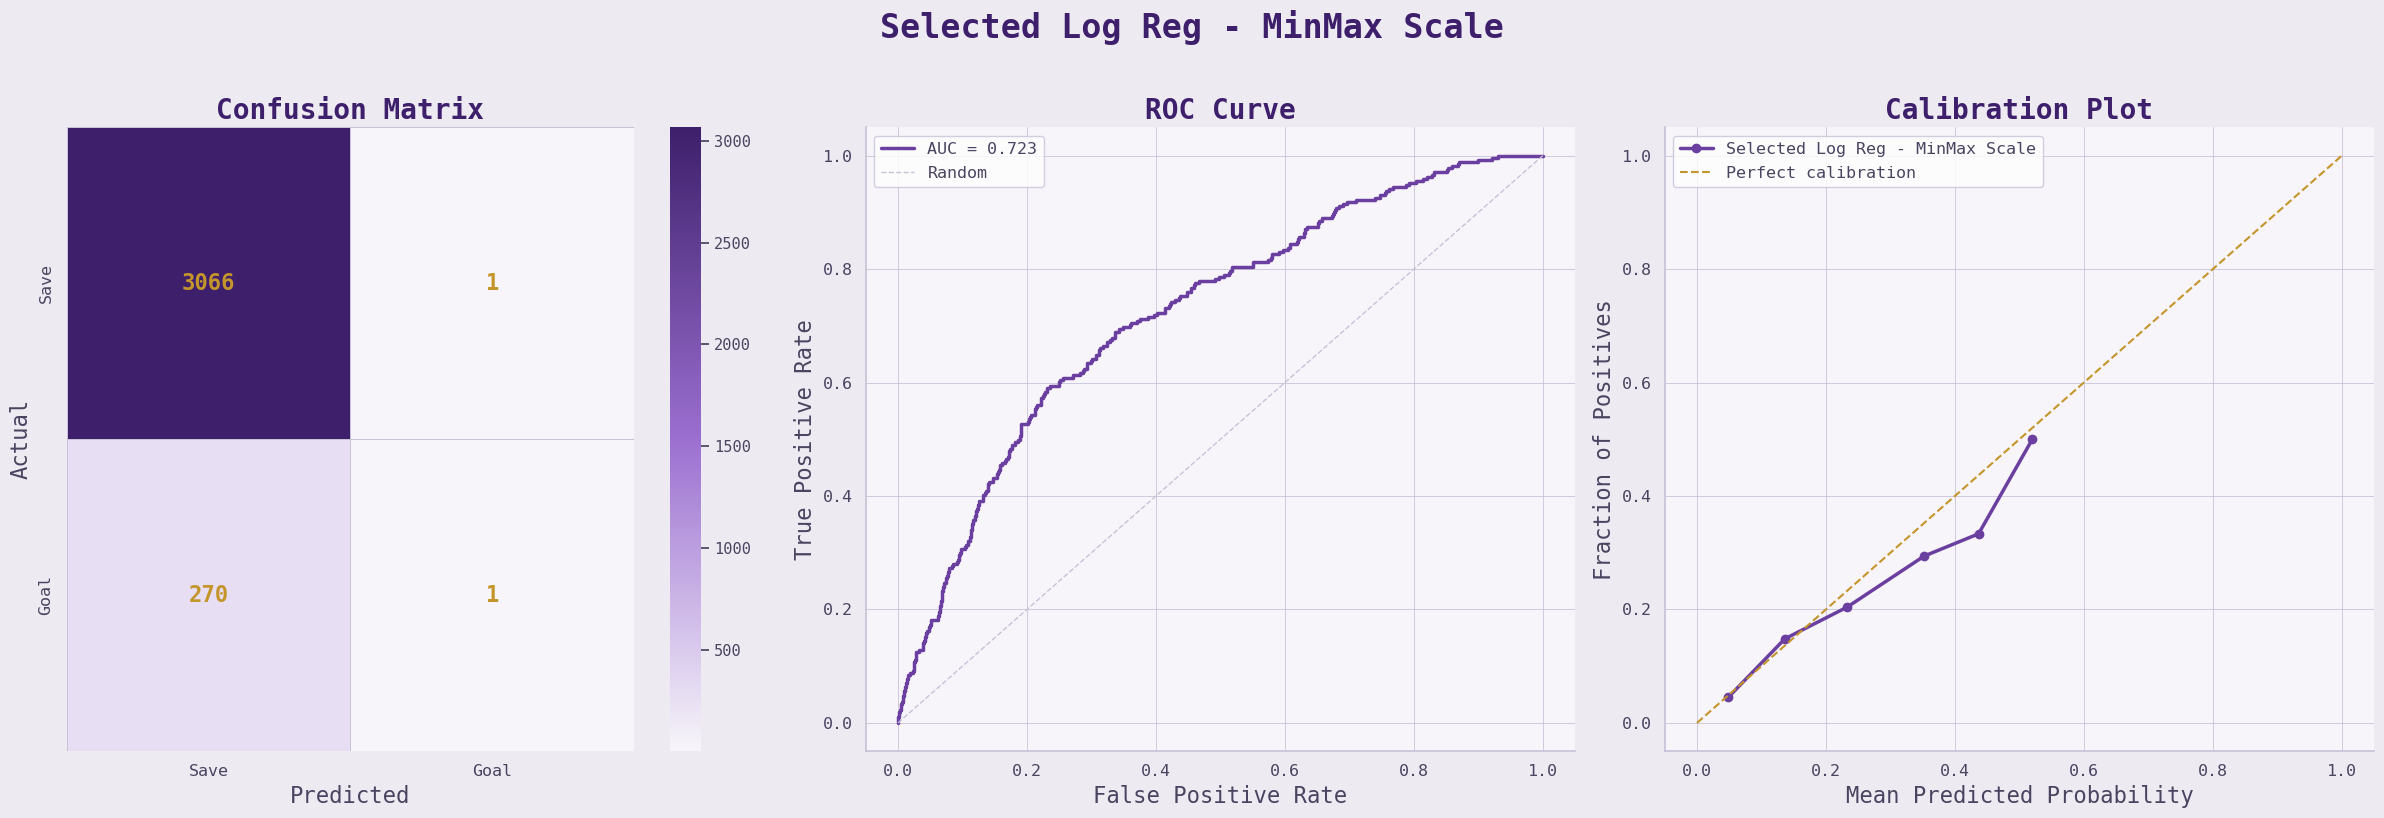

In [25]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(random_state=29))
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, "Selected Log Reg - MinMax Scale")

Unfortunately the scaling did not do much to improve the modelling.  Given that only 8% of shots go in, the next step will be to balance the data and see if that has an effect of the accuracy.

I will try to do this within the standard Logistic Regression, and if that does not yield better results I will apply SMOTE to the dataset and retry.


  Balanced Log Reg — Full Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       67.05%
  AUC:                            0.773
  Log Loss:                       0.576
  Avg Precision (PR-AUC):         0.236

              precision    recall  f1-score   support

        Save       0.97      0.66      0.79      3067
        Goal       0.16      0.73      0.27       271

    accuracy                           0.67      3338
   macro avg       0.56      0.70      0.53      3338
weighted avg       0.90      0.67      0.75      3338



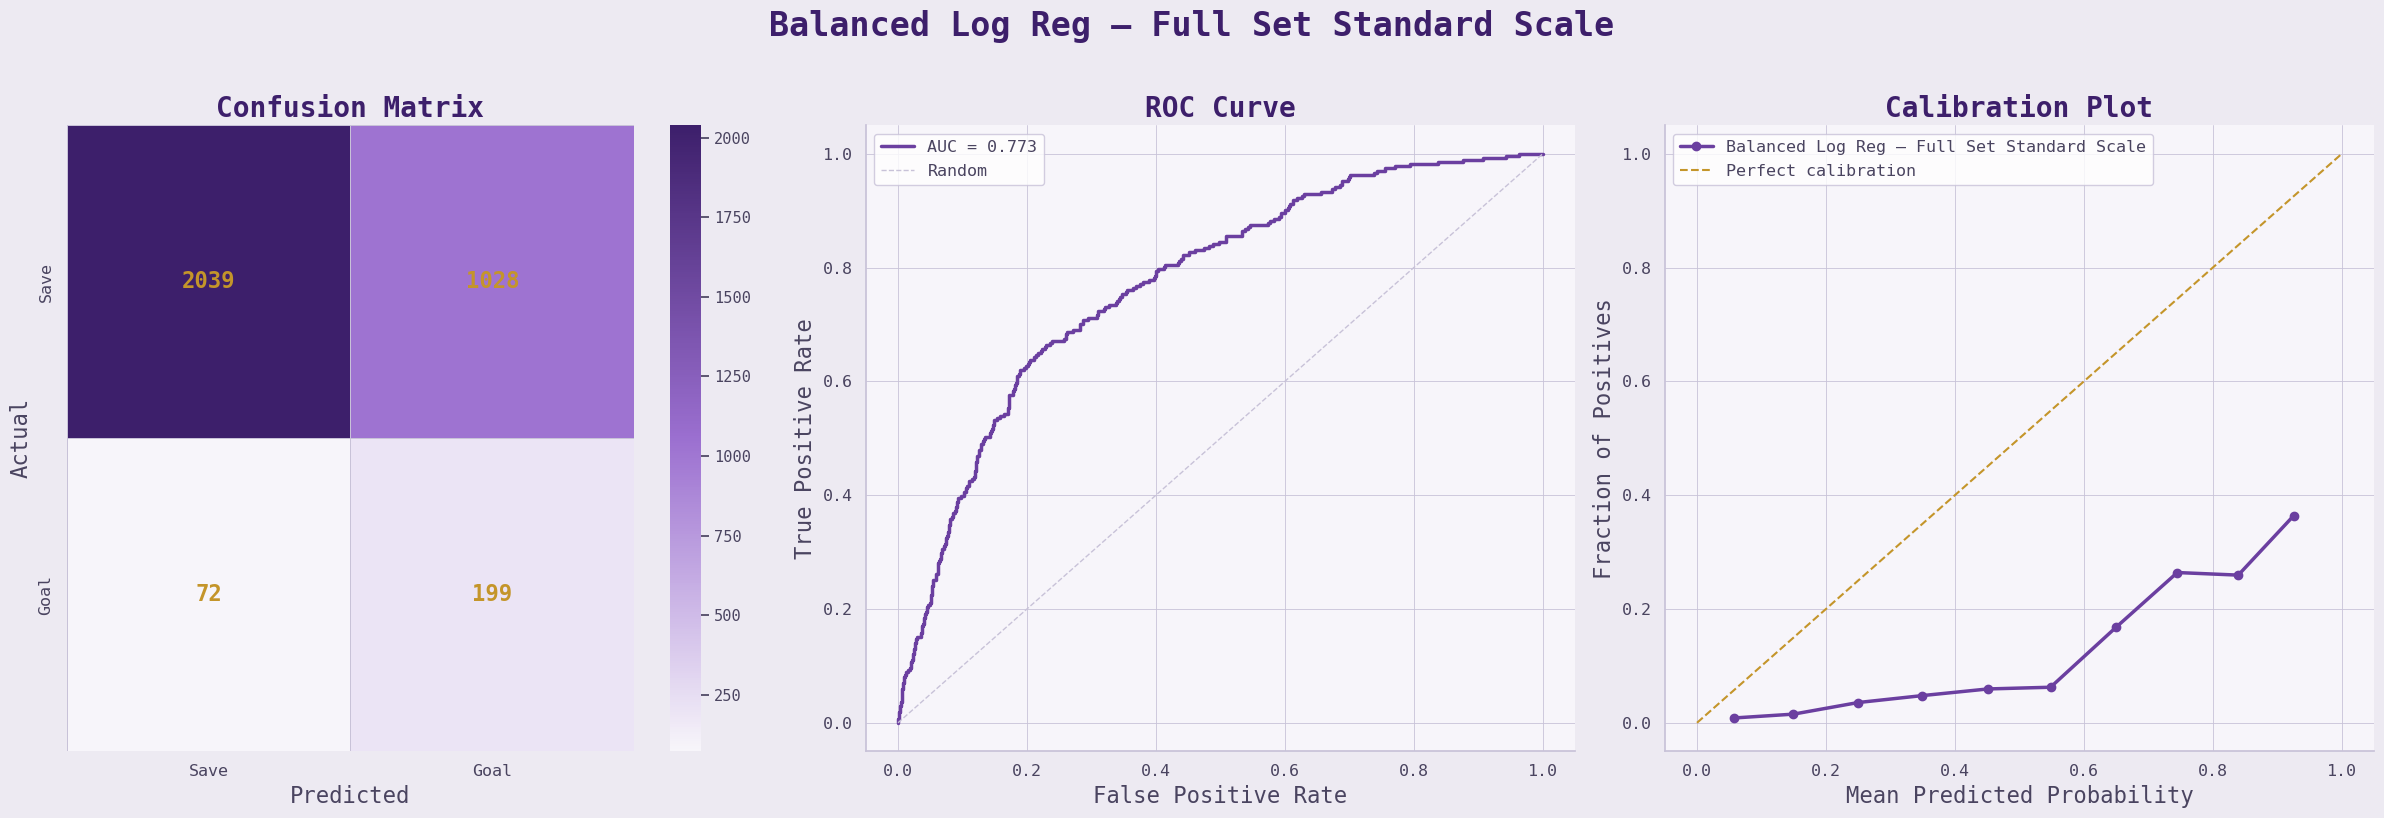

In [26]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(class_weight = 'balanced', random_state=29))
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, model_name="Balanced Log Reg — Full Set Standard Scale")


  Balanced Log Reg — Full Set MinMax Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       67.35%
  AUC:                            0.772
  Log Loss:                       0.577
  Avg Precision (PR-AUC):         0.235

              precision    recall  f1-score   support

        Save       0.97      0.67      0.79      3067
        Goal       0.16      0.74      0.27       271

    accuracy                           0.67      3338
   macro avg       0.57      0.70      0.53      3338
weighted avg       0.90      0.67      0.75      3338



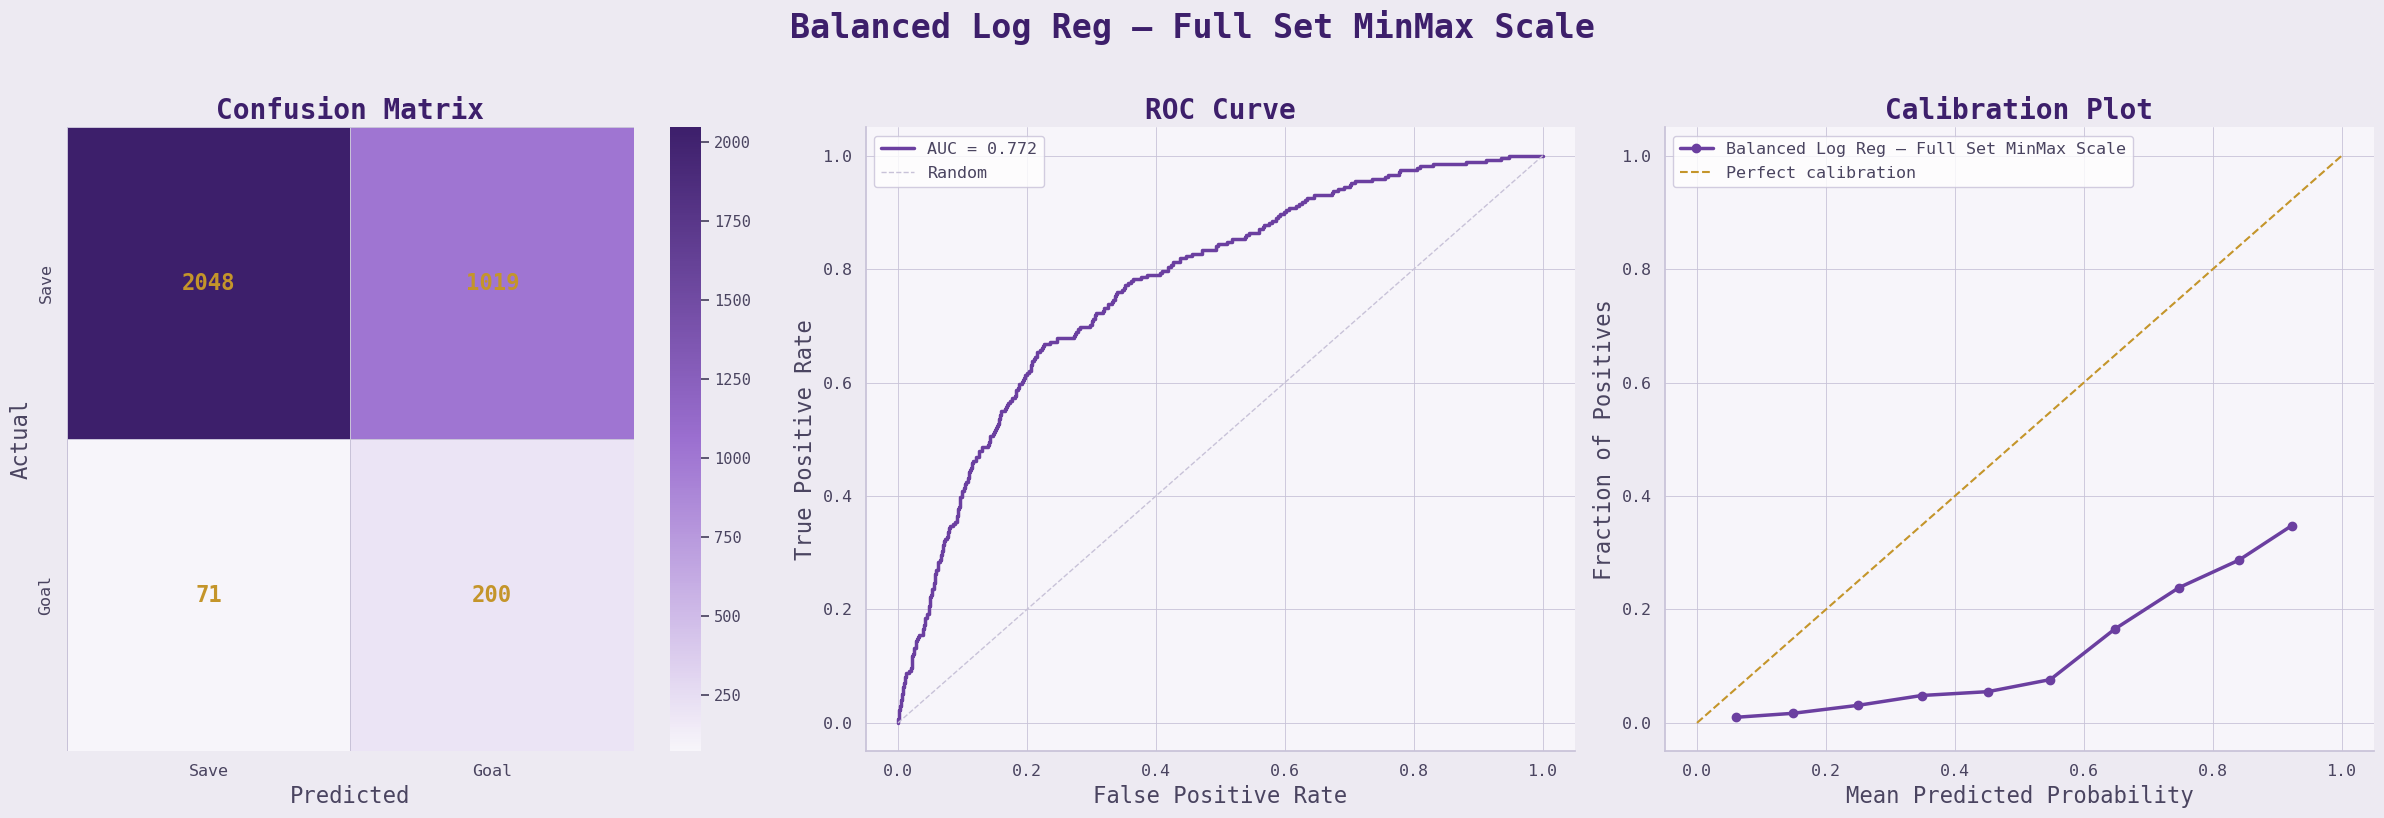

In [27]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(class_weight = 'balanced', random_state=29))
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, model_name="Balanced Log Reg — Full Set MinMax Scale")


  Balanced Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       63.18%
  AUC:                            0.721
  Log Loss:                       0.622
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.96      0.63      0.76      3067
        Goal       0.14      0.71      0.24       271

    accuracy                           0.63      3338
   macro avg       0.55      0.67      0.50      3338
weighted avg       0.89      0.63      0.72      3338



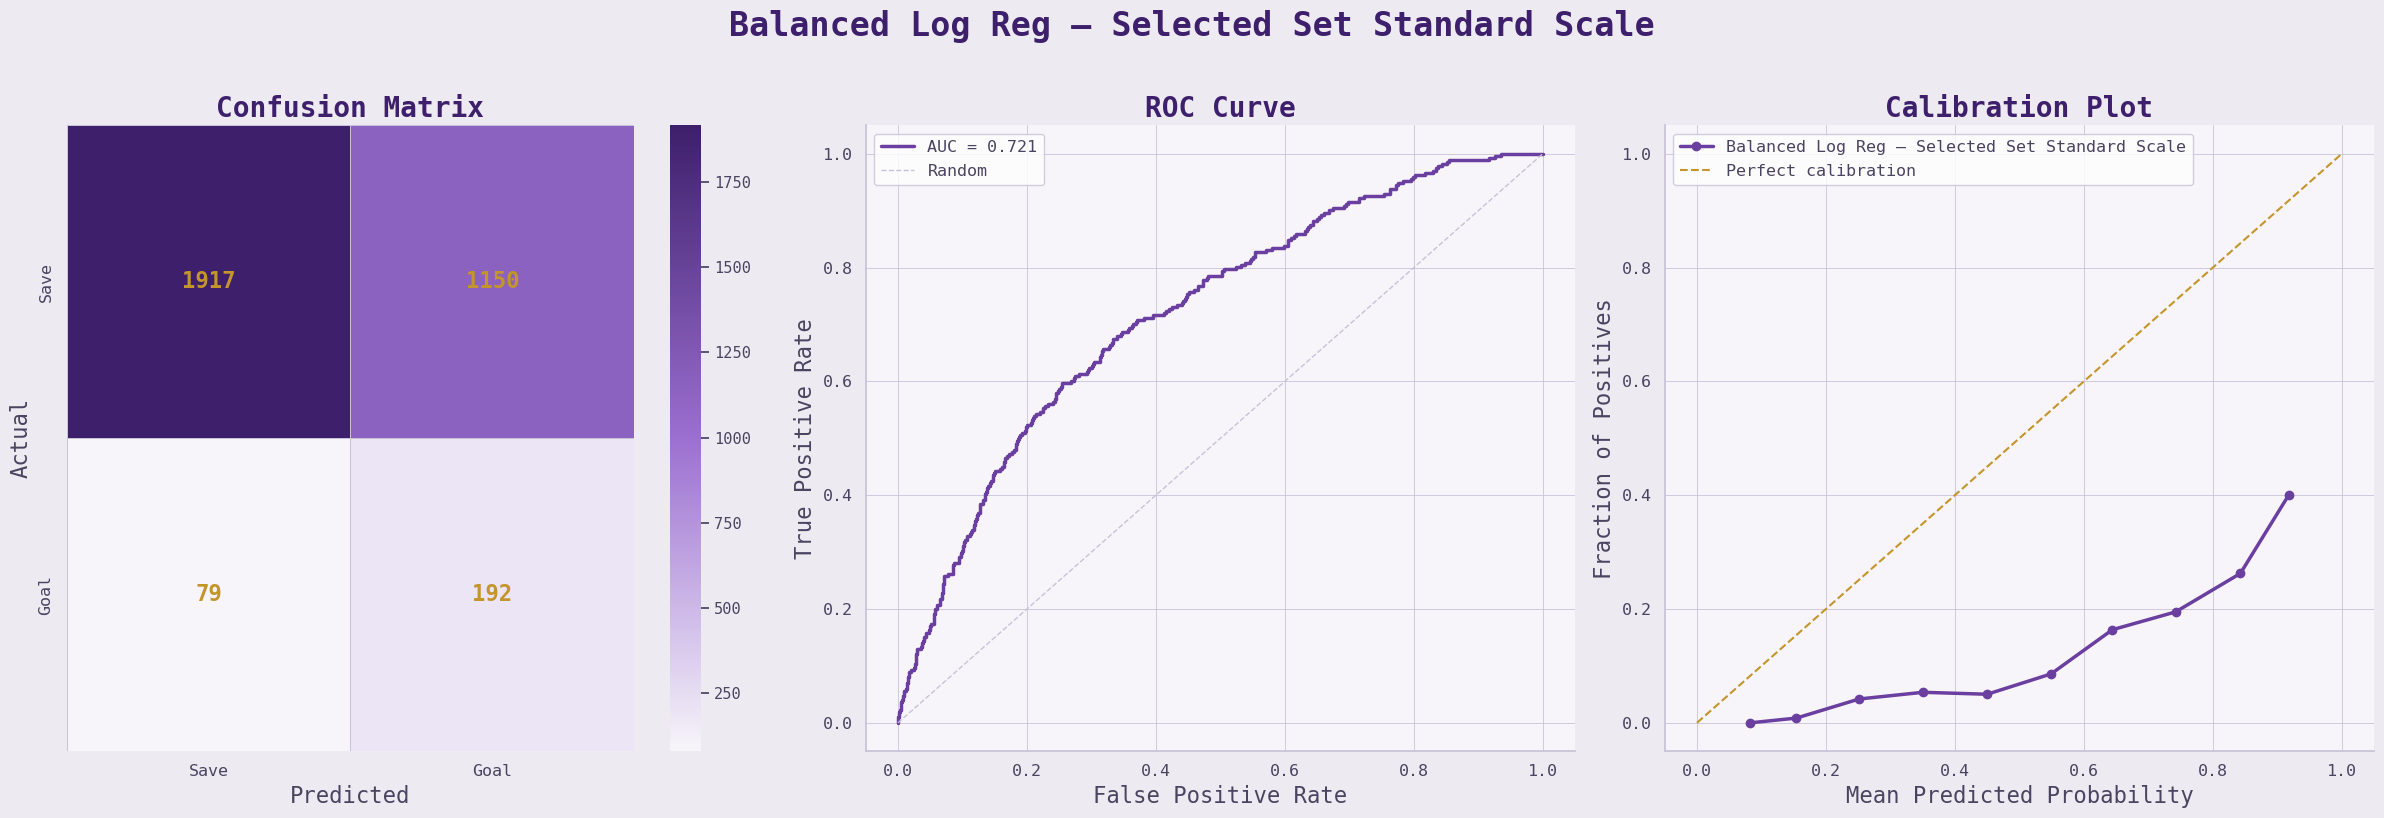

In [28]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(class_weight = 'balanced', random_state=29))
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, model_name="Balanced Log Reg — Selected Set Standard Scale")


  Balanced Log Reg — Selected Set MinMax Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       63.0%
  AUC:                            0.721
  Log Loss:                       0.622
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.96      0.62      0.76      3067
        Goal       0.14      0.71      0.24       271

    accuracy                           0.63      3338
   macro avg       0.55      0.67      0.50      3338
weighted avg       0.89      0.63      0.71      3338



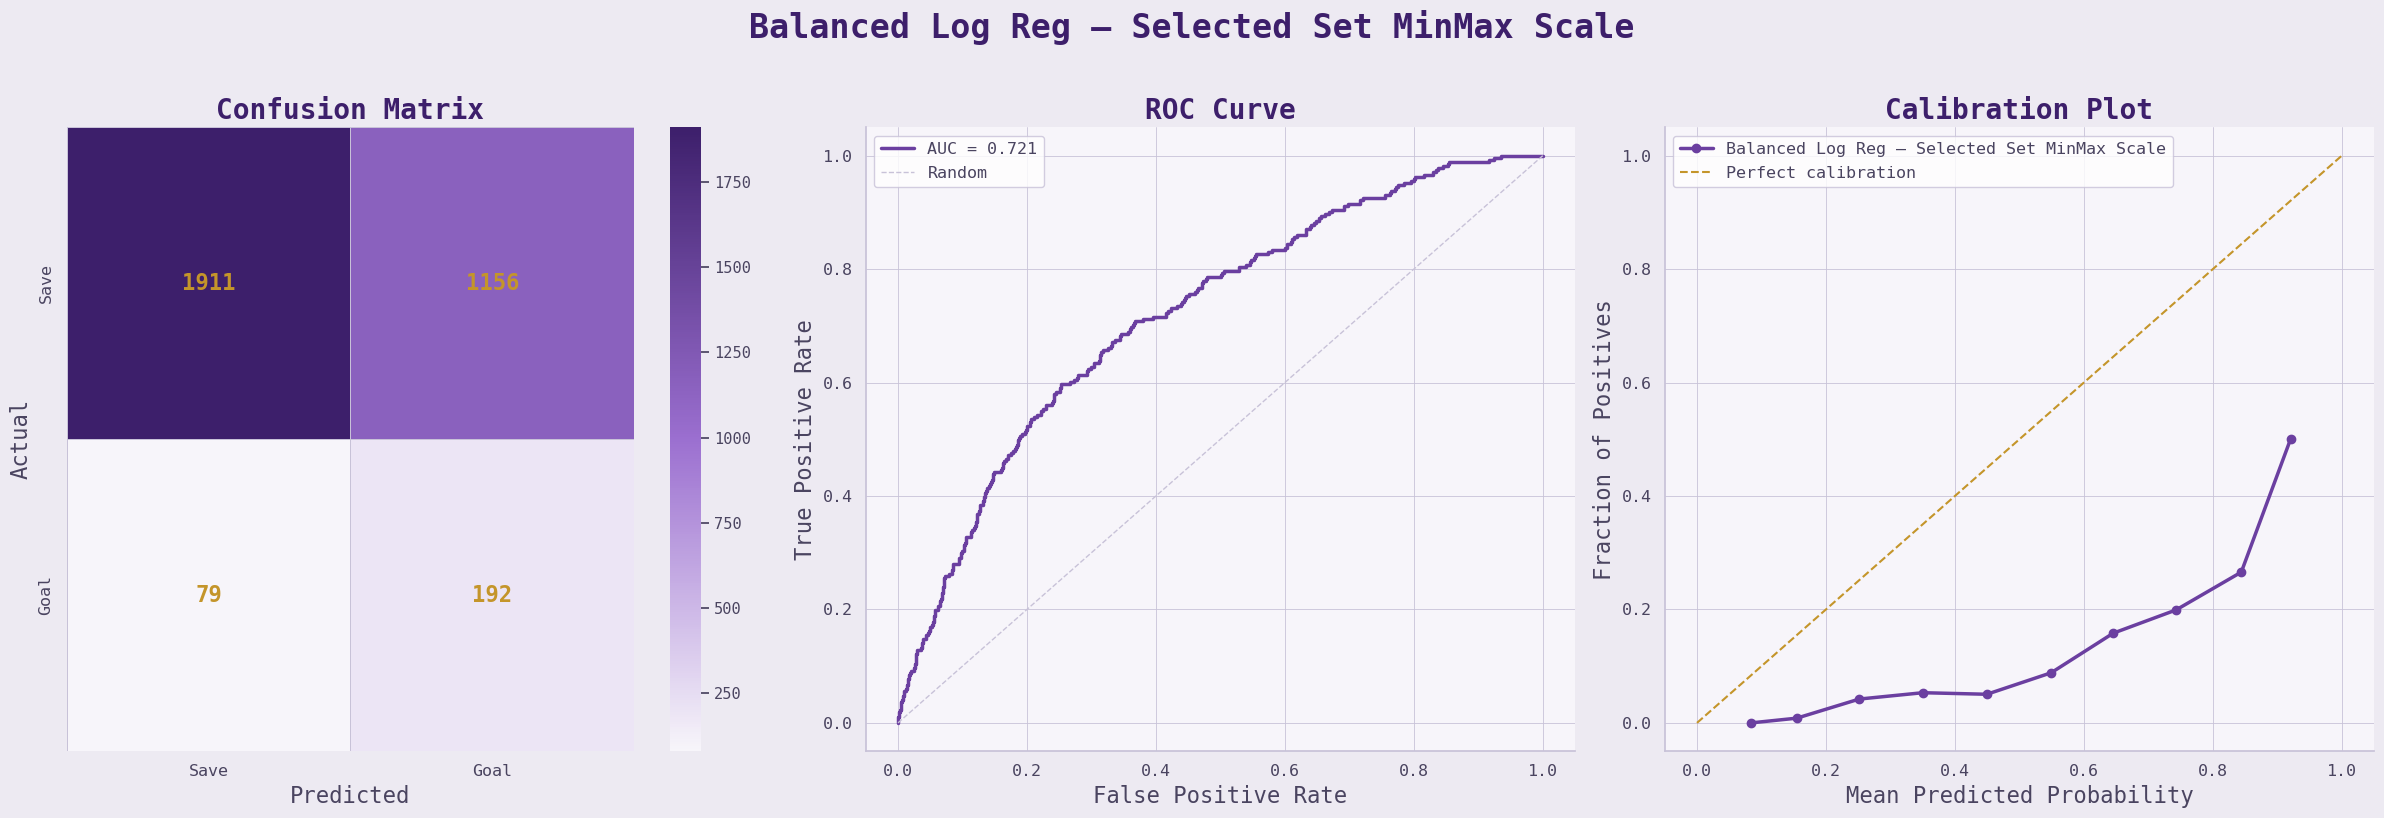

In [29]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(class_weight = 'balanced', random_state=29))
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, model_name="Balanced Log Reg — Selected Set MinMax Scale")

Unfortunately these models were not very successful either.  They at least started to predict goals, but significantly over-predicted them.  These models actually increased the precision on saves, but for an effective xG model, we want to have much better precision on Goals.  So now I will try to use SMOTE instead to balance the data.


  SMOTE Log Reg — Full Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       67.65%
  AUC:                            0.771
  Log Loss:                       0.571
  Avg Precision (PR-AUC):         0.234

              precision    recall  f1-score   support

        Save       0.97      0.67      0.79      3067
        Goal       0.17      0.74      0.27       271

    accuracy                           0.68      3338
   macro avg       0.57      0.71      0.53      3338
weighted avg       0.90      0.68      0.75      3338



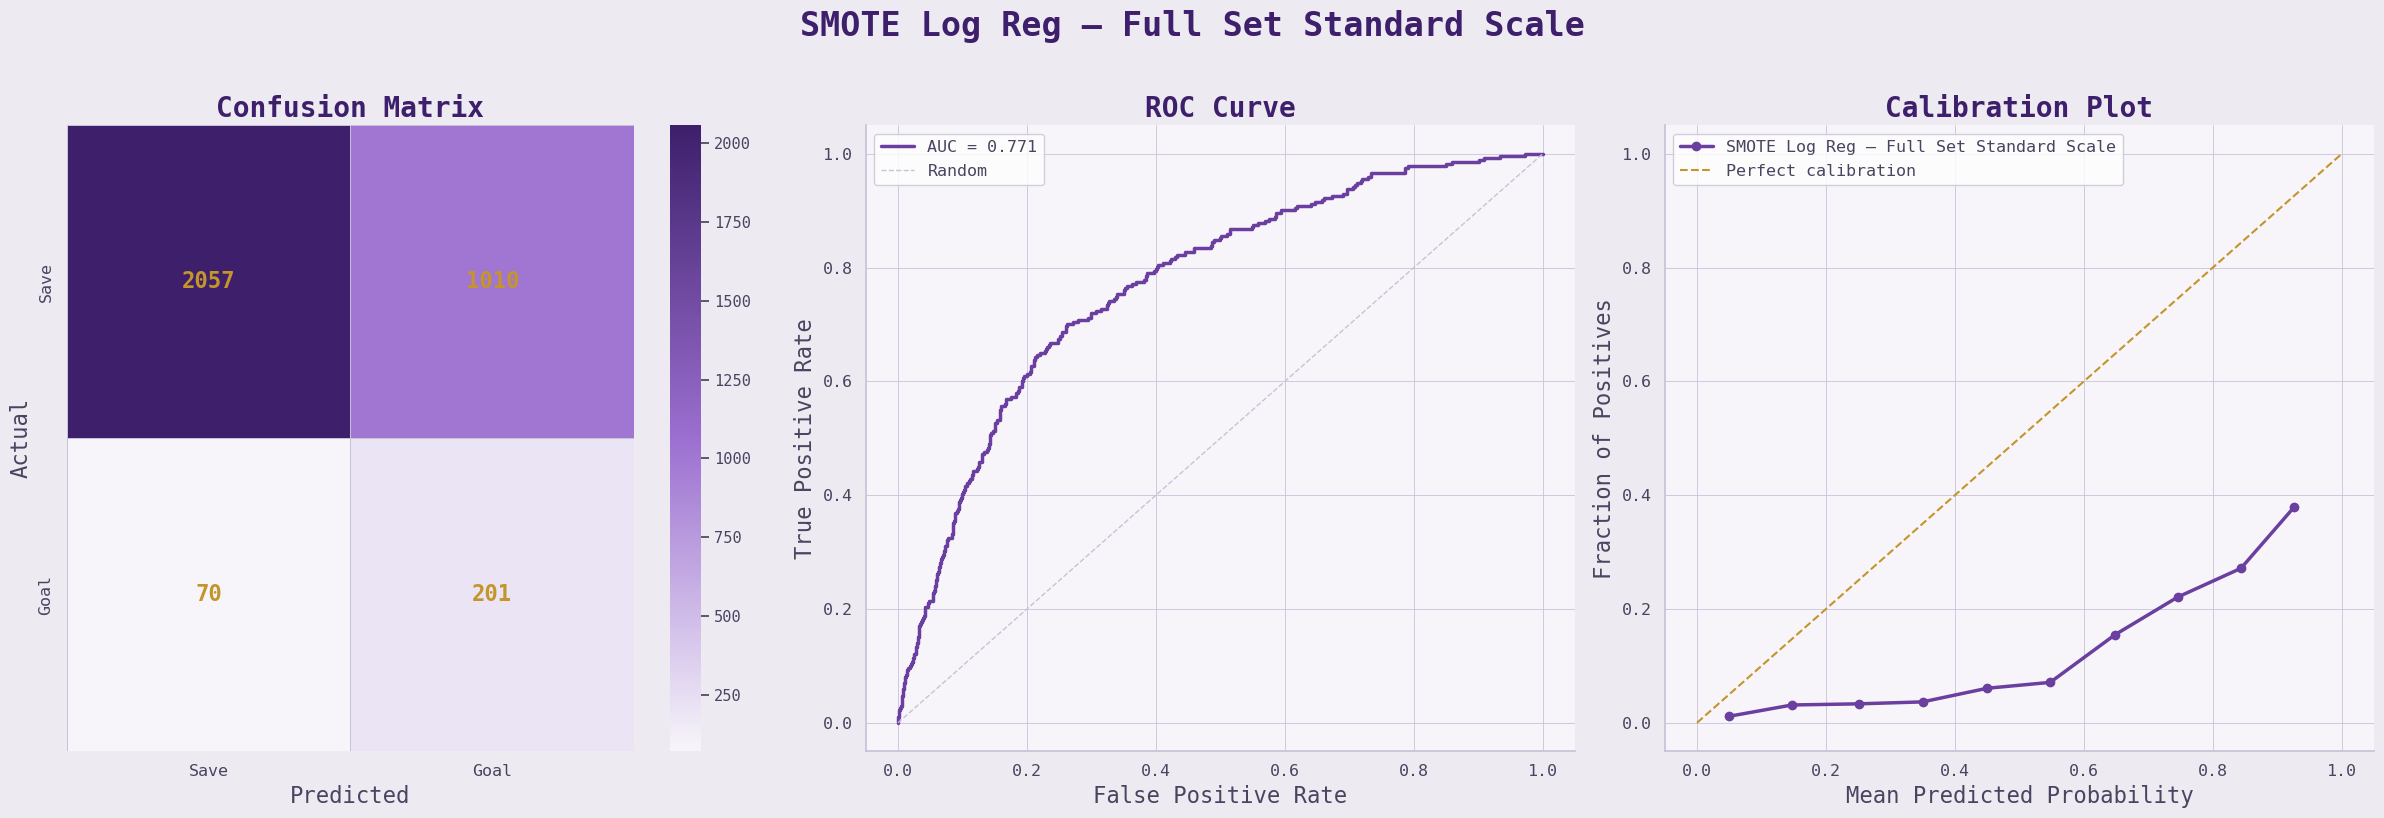

In [30]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote',        SMOTE(random_state=29)),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, model_name="SMOTE Log Reg — Full Set Standard Scale")


  SMOTE Log Reg — Full Set MinMax Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       67.62%
  AUC:                            0.772
  Log Loss:                       0.574
  Avg Precision (PR-AUC):         0.231

              precision    recall  f1-score   support

        Save       0.97      0.67      0.79      3067
        Goal       0.17      0.75      0.27       271

    accuracy                           0.68      3338
   macro avg       0.57      0.71      0.53      3338
weighted avg       0.90      0.68      0.75      3338



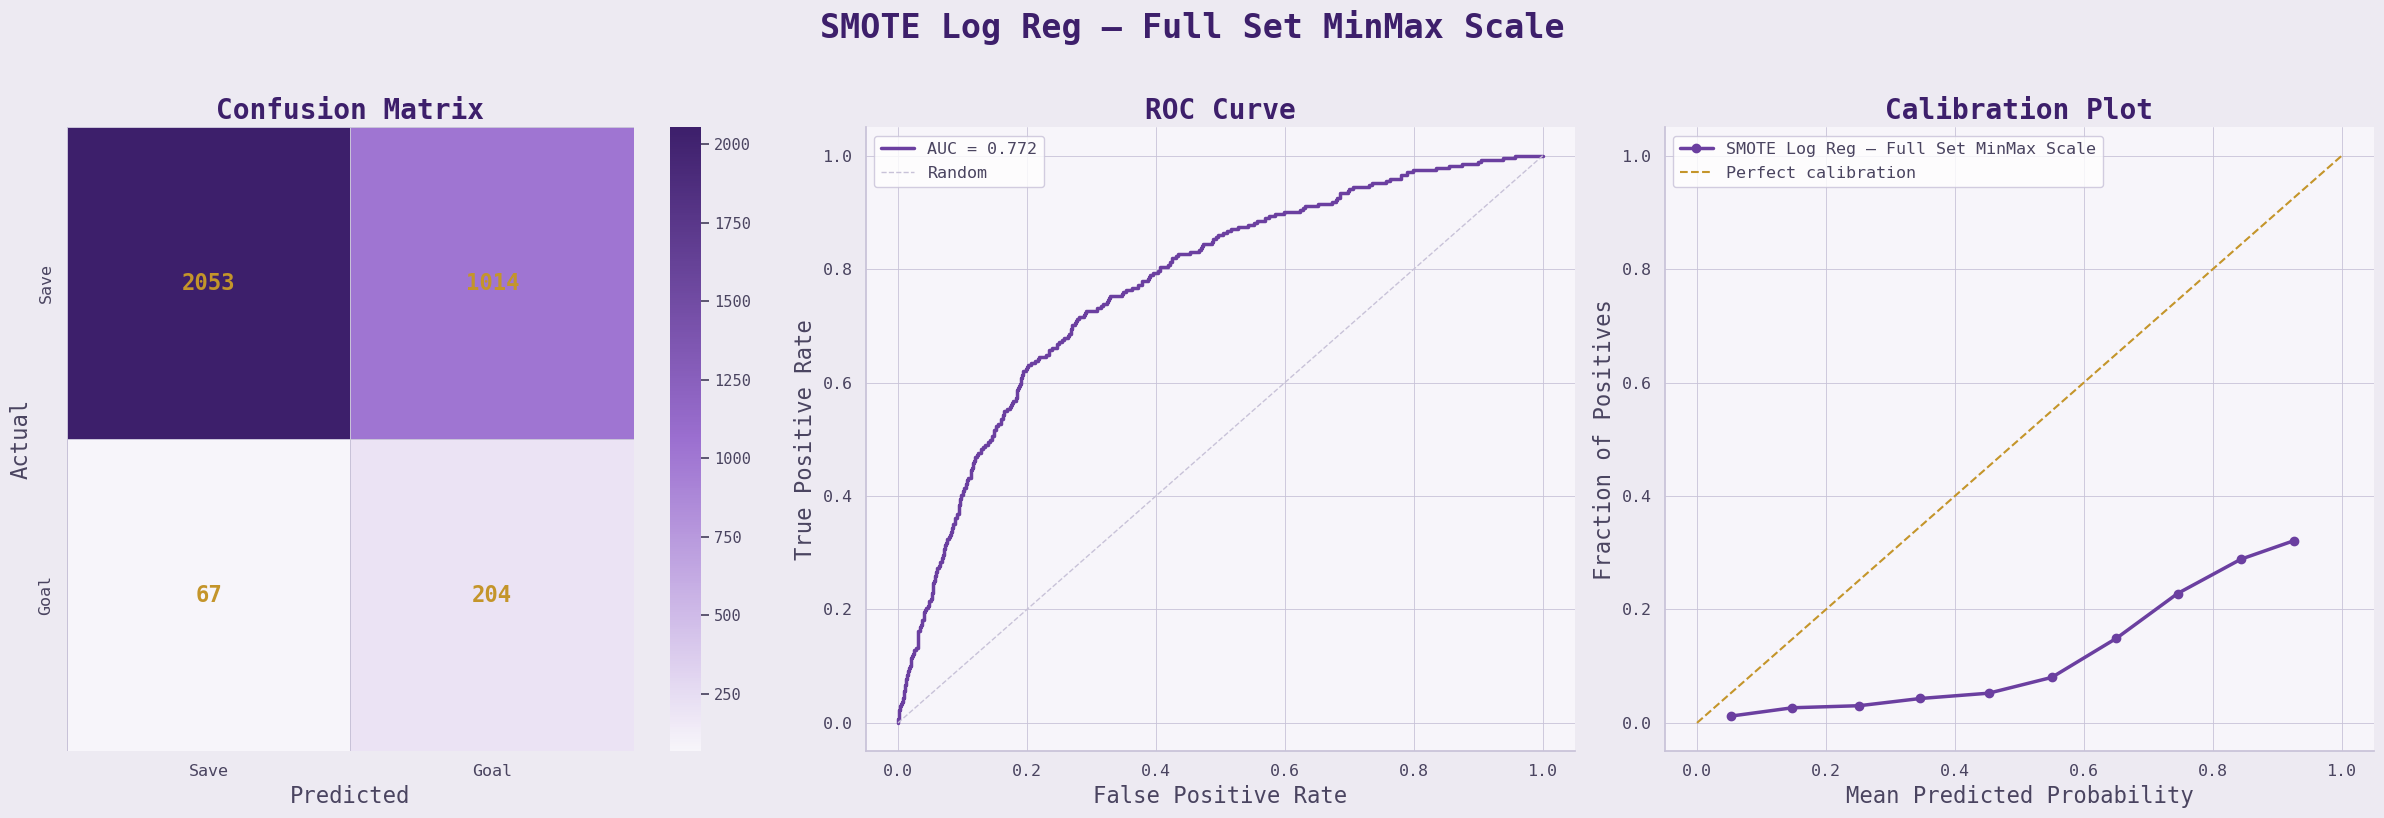

In [31]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote',        SMOTE(random_state=29)),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, model_name="SMOTE Log Reg — Full Set MinMax Scale")


  SMOTE Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       63.15%
  AUC:                            0.721
  Log Loss:                       0.62
  Avg Precision (PR-AUC):         0.194

              precision    recall  f1-score   support

        Save       0.96      0.63      0.76      3067
        Goal       0.14      0.70      0.24       271

    accuracy                           0.63      3338
   macro avg       0.55      0.66      0.50      3338
weighted avg       0.89      0.63      0.71      3338



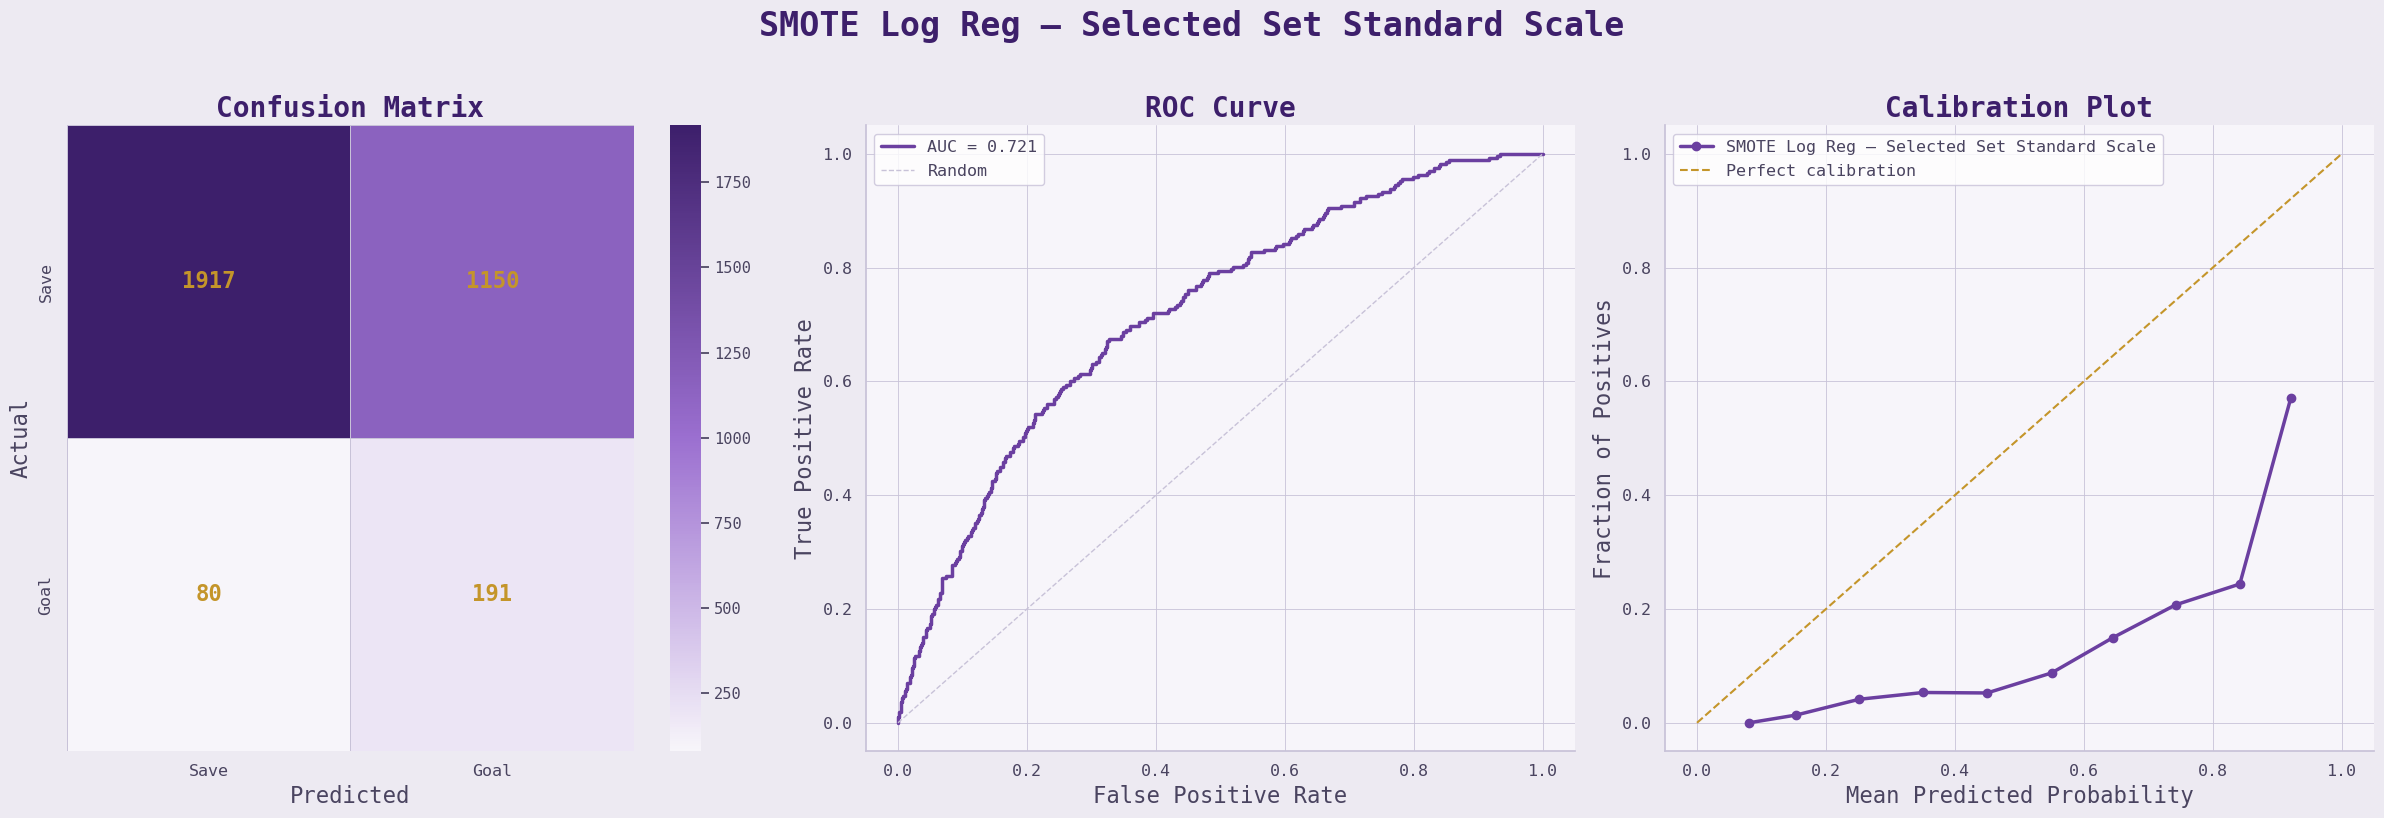

In [32]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote',        SMOTE(random_state=29)),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, model_name="SMOTE Log Reg — Selected Set Standard Scale")


  SMOTE Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       63.06%
  AUC:                            0.72
  Log Loss:                       0.621
  Avg Precision (PR-AUC):         0.194

              precision    recall  f1-score   support

        Save       0.96      0.62      0.76      3067
        Goal       0.14      0.70      0.23       271

    accuracy                           0.63      3338
   macro avg       0.55      0.66      0.50      3338
weighted avg       0.89      0.63      0.71      3338



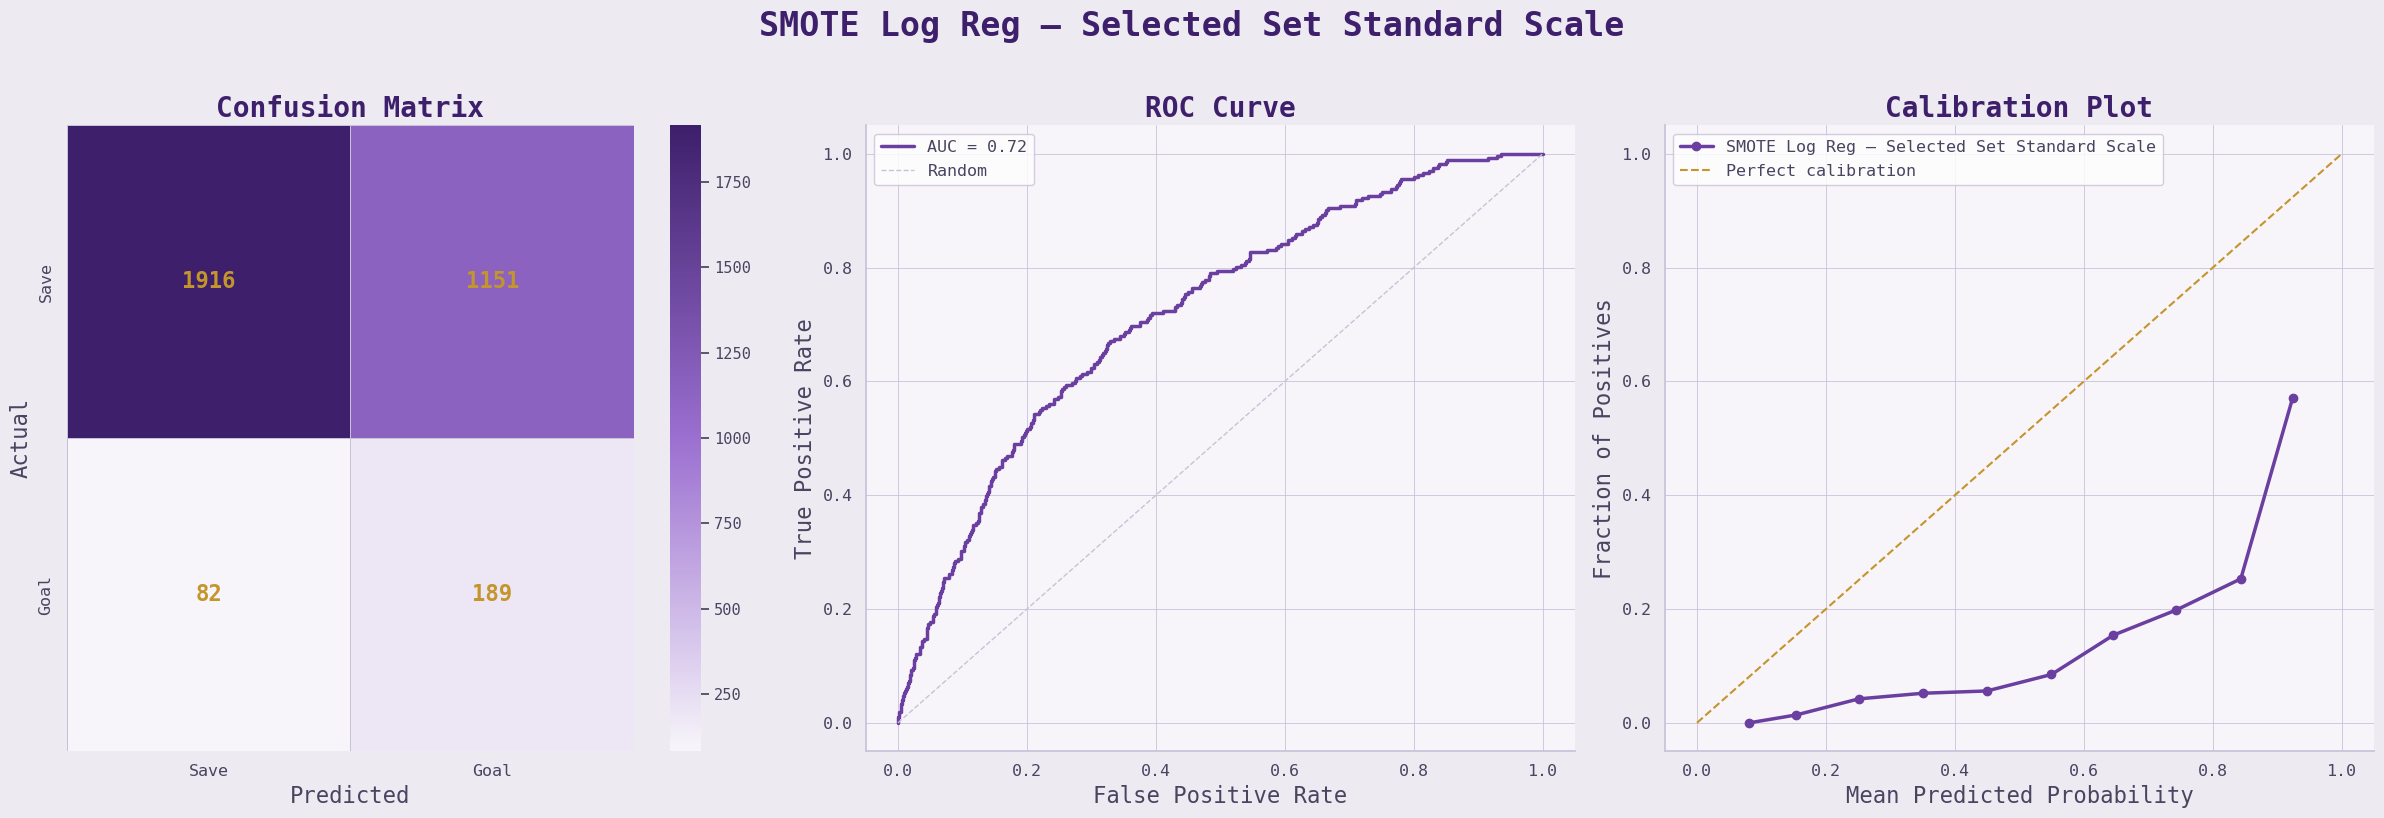

In [33]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote',        SMOTE(random_state=29)),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, model_name="SMOTE Log Reg — Selected Set Standard Scale")

Using smote yielded similar results without any improvement.

Balancing the data did yield some guesses for goals, but without precision.  I am going to return to the unbalanced data but lower the threshold for predicting a goal.  The hope is that the models will increase the number of guesses for goals, which may lower the accuracy of the model but improve its applicability.


   Lowered (0.25) Log Reg — Full Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       90.08%
  AUC:                            0.774
  Log Loss:                       0.244
  Avg Precision (PR-AUC):         0.242

              precision    recall  f1-score   support

        Save       0.93      0.97      0.95      3067
        Goal       0.30      0.17      0.21       271

    accuracy                           0.90      3338
   macro avg       0.61      0.57      0.58      3338
weighted avg       0.88      0.90      0.89      3338



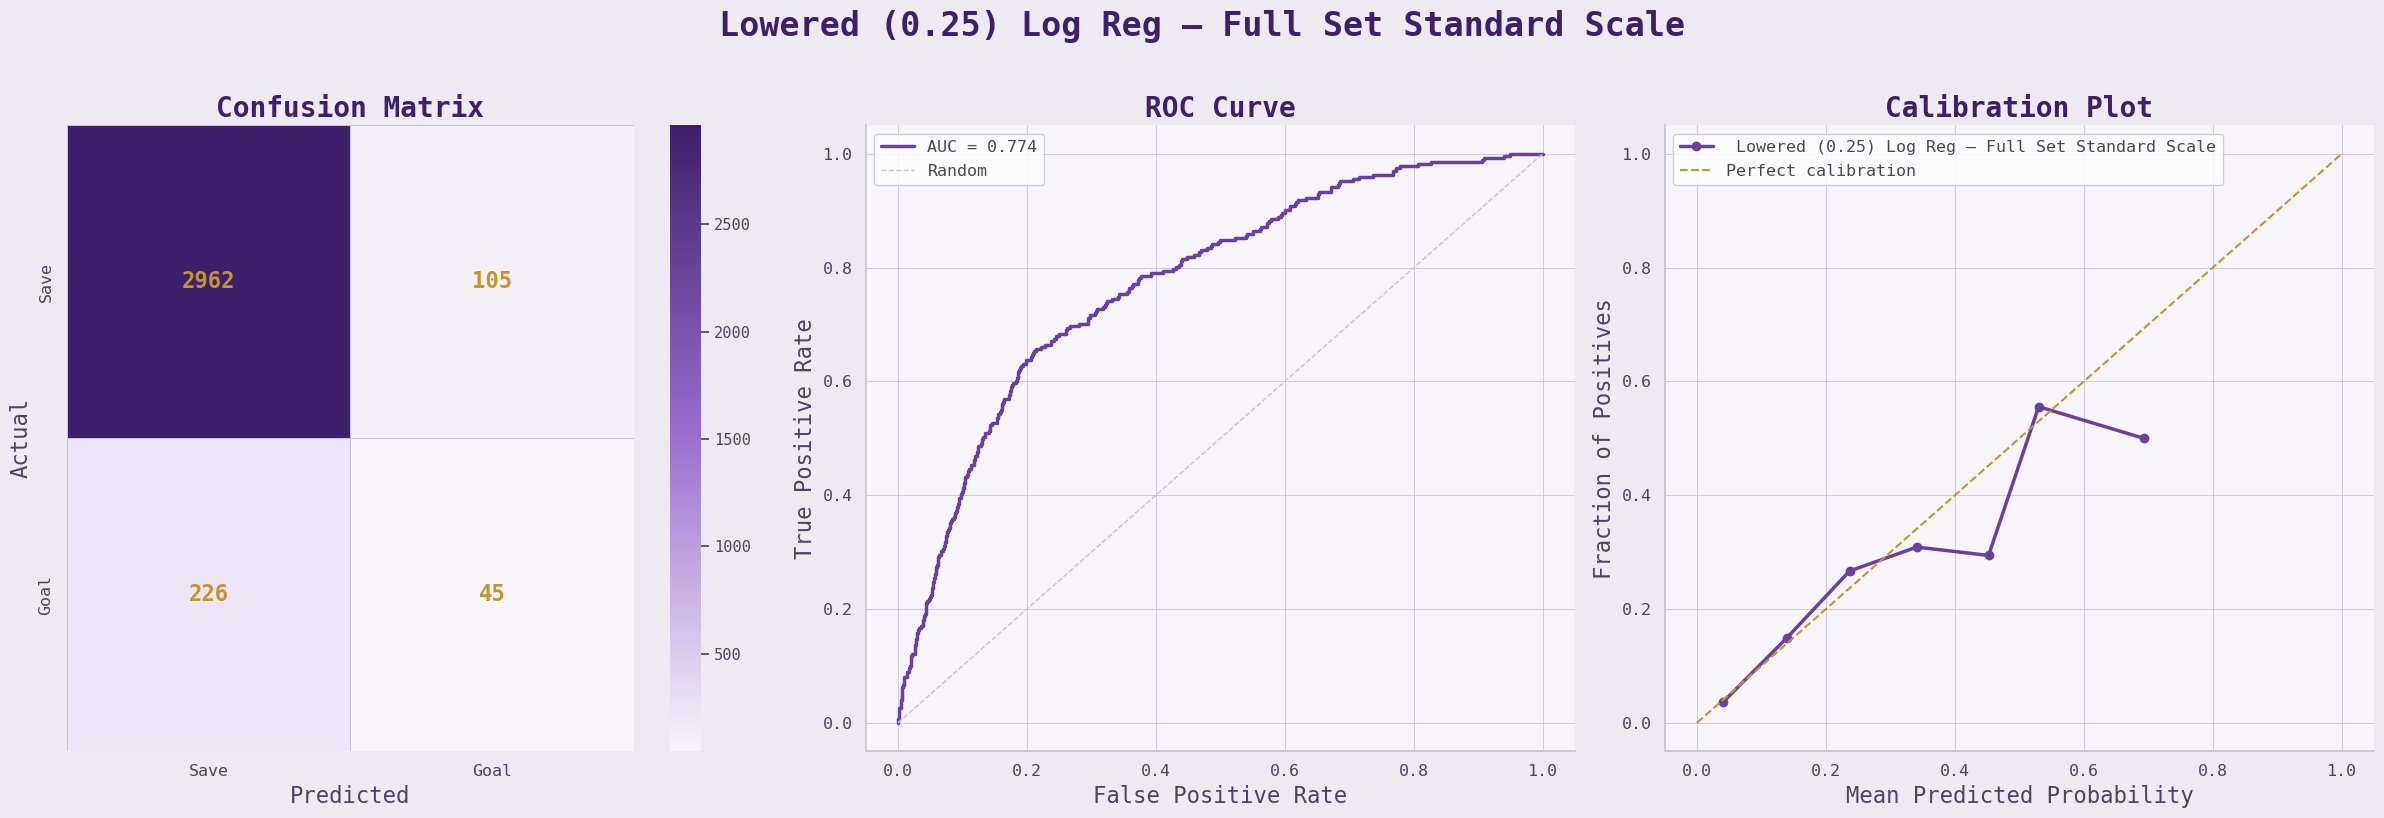

In [34]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name=" Lowered (0.25) Log Reg — Full Set Standard Scale",
           threshold = 0.25)

We got more guesses for goals, but the recall is pretty low (though better than the balanced data) for guessing goals.  I'll lower the threshold even lower to see the effect on the model.


   Lowered (0.1) Log Reg — Full Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       73.49%
  AUC:                            0.774
  Log Loss:                       0.244
  Avg Precision (PR-AUC):         0.242

              precision    recall  f1-score   support

        Save       0.96      0.74      0.84      3067
        Goal       0.19      0.69      0.30       271

    accuracy                           0.73      3338
   macro avg       0.58      0.71      0.57      3338
weighted avg       0.90      0.73      0.79      3338



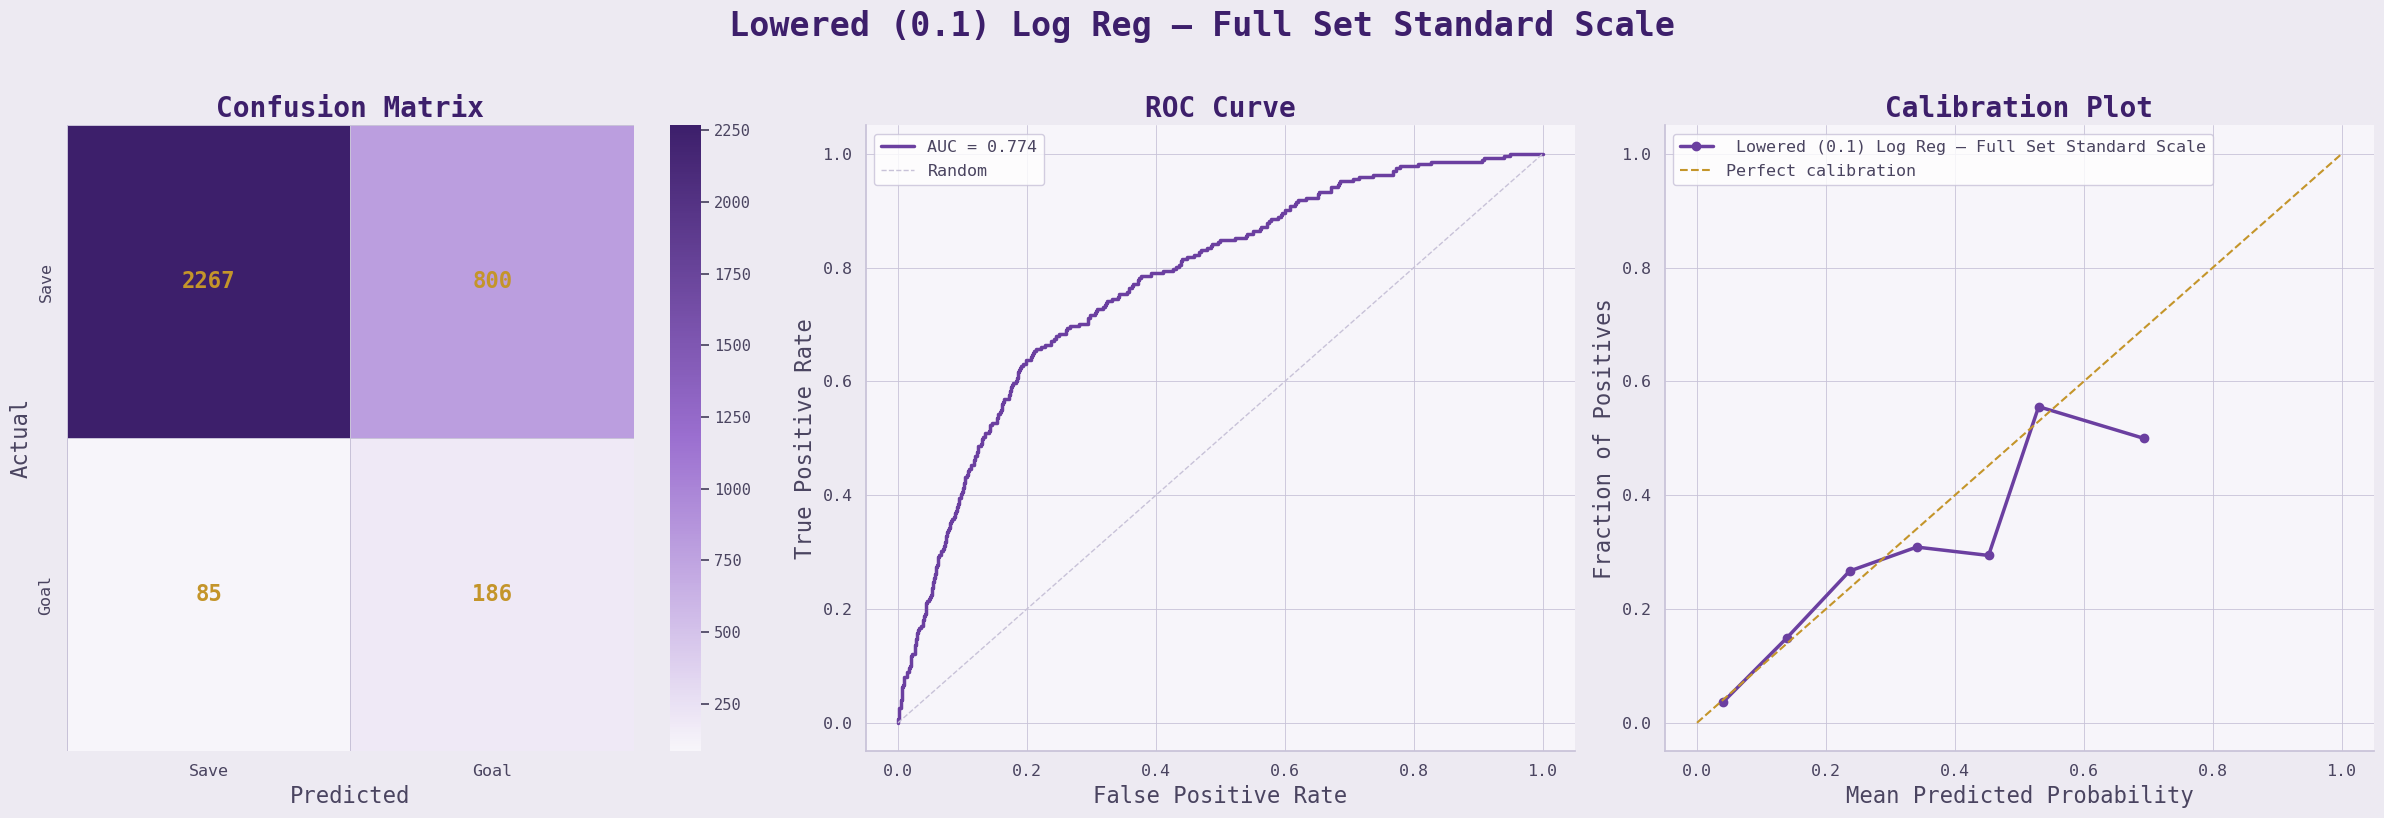

In [35]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name=" Lowered (0.1) Log Reg — Full Set Standard Scale",
           threshold = 0.1)

This one has ticked over and is now over guessing goals and the accuracy is lowering.  I'll try again with the limited dataset.


   Lowered (0.25) Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       90.56%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.92      0.98      0.95      3067
        Goal       0.27      0.09      0.14       271

    accuracy                           0.91      3338
   macro avg       0.60      0.53      0.54      3338
weighted avg       0.87      0.91      0.88      3338



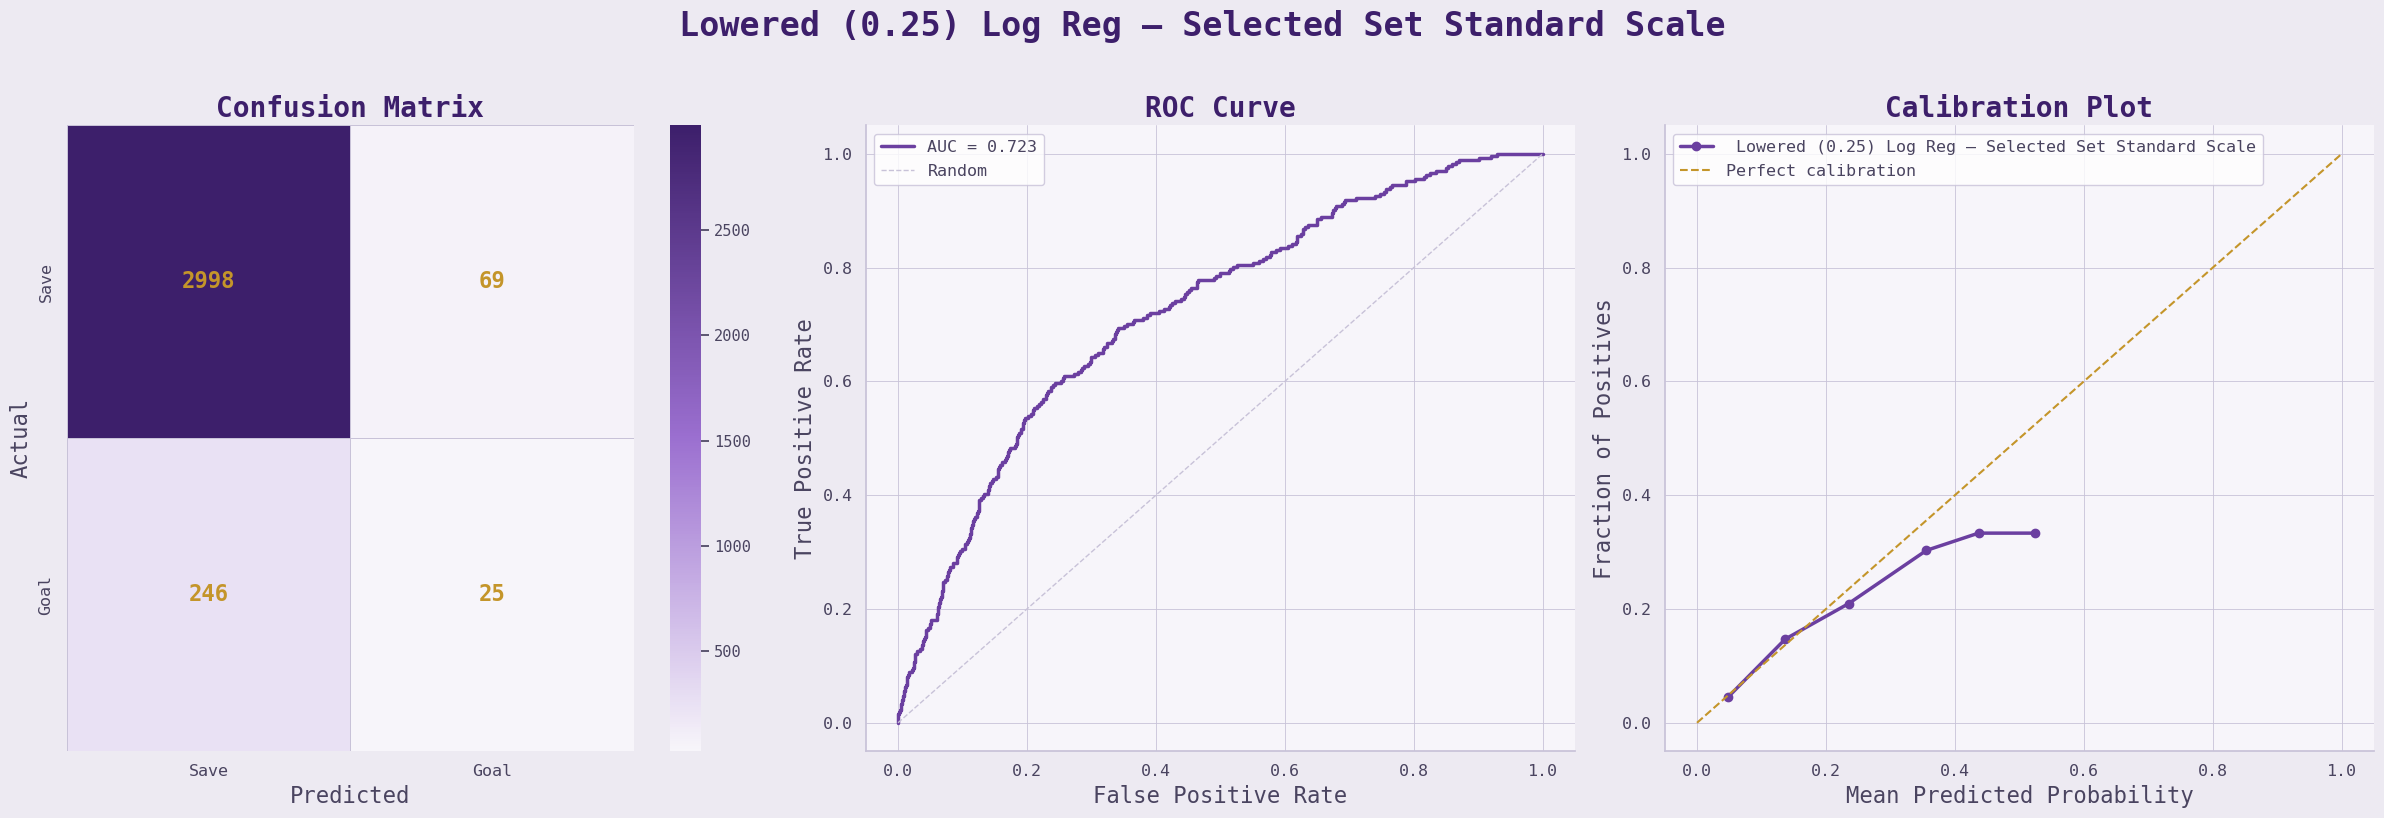

In [36]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name=" Lowered (0.25) Log Reg — Selected Set Standard Scale",
           threshold = 0.25)


   Lowered (0.1) Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       71.63%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.95      0.73      0.82      3067
        Goal       0.16      0.61      0.26       271

    accuracy                           0.72      3338
   macro avg       0.56      0.67      0.54      3338
weighted avg       0.89      0.72      0.78      3338



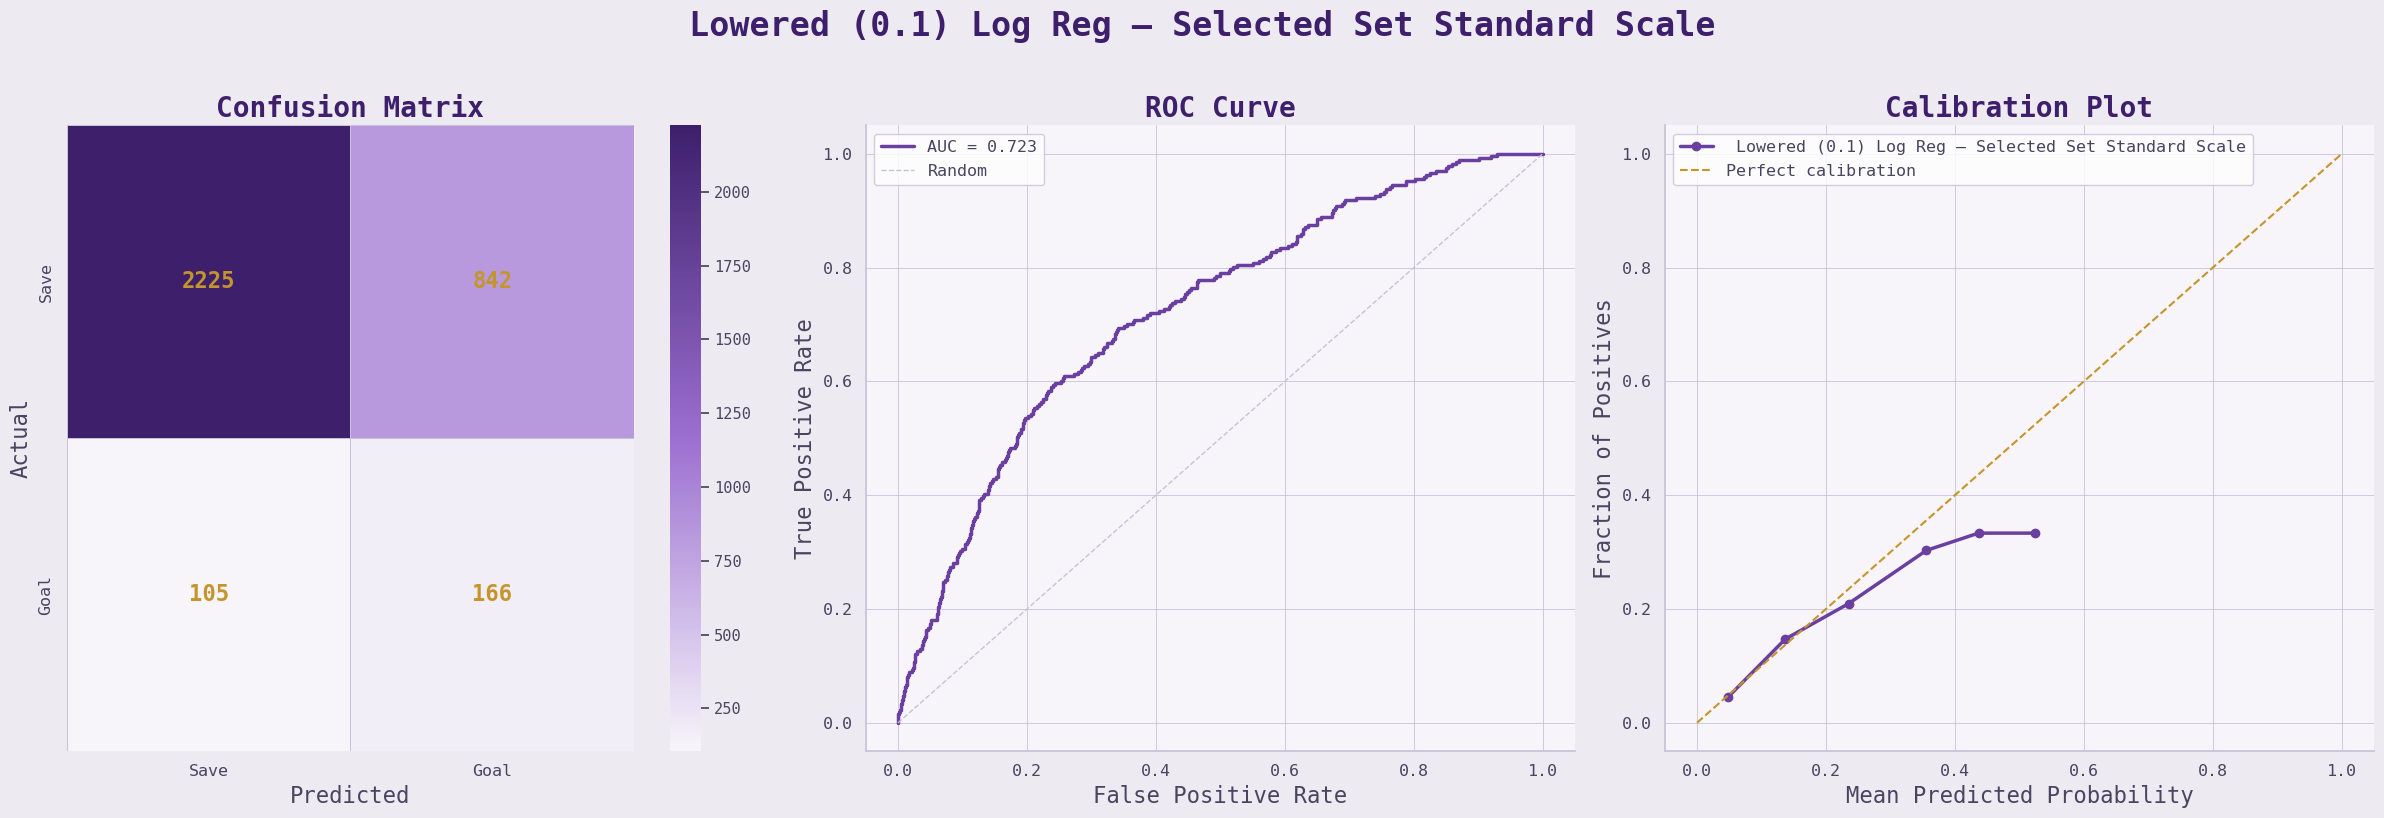

In [37]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name=" Lowered (0.1) Log Reg — Selected Set Standard Scale",
           threshold = 0.1)


   Lowered (0.25) Log Reg — Selected Set MinMax Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       90.59%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.92      0.98      0.95      3067
        Goal       0.26      0.09      0.13       271

    accuracy                           0.91      3338
   macro avg       0.59      0.53      0.54      3338
weighted avg       0.87      0.91      0.88      3338



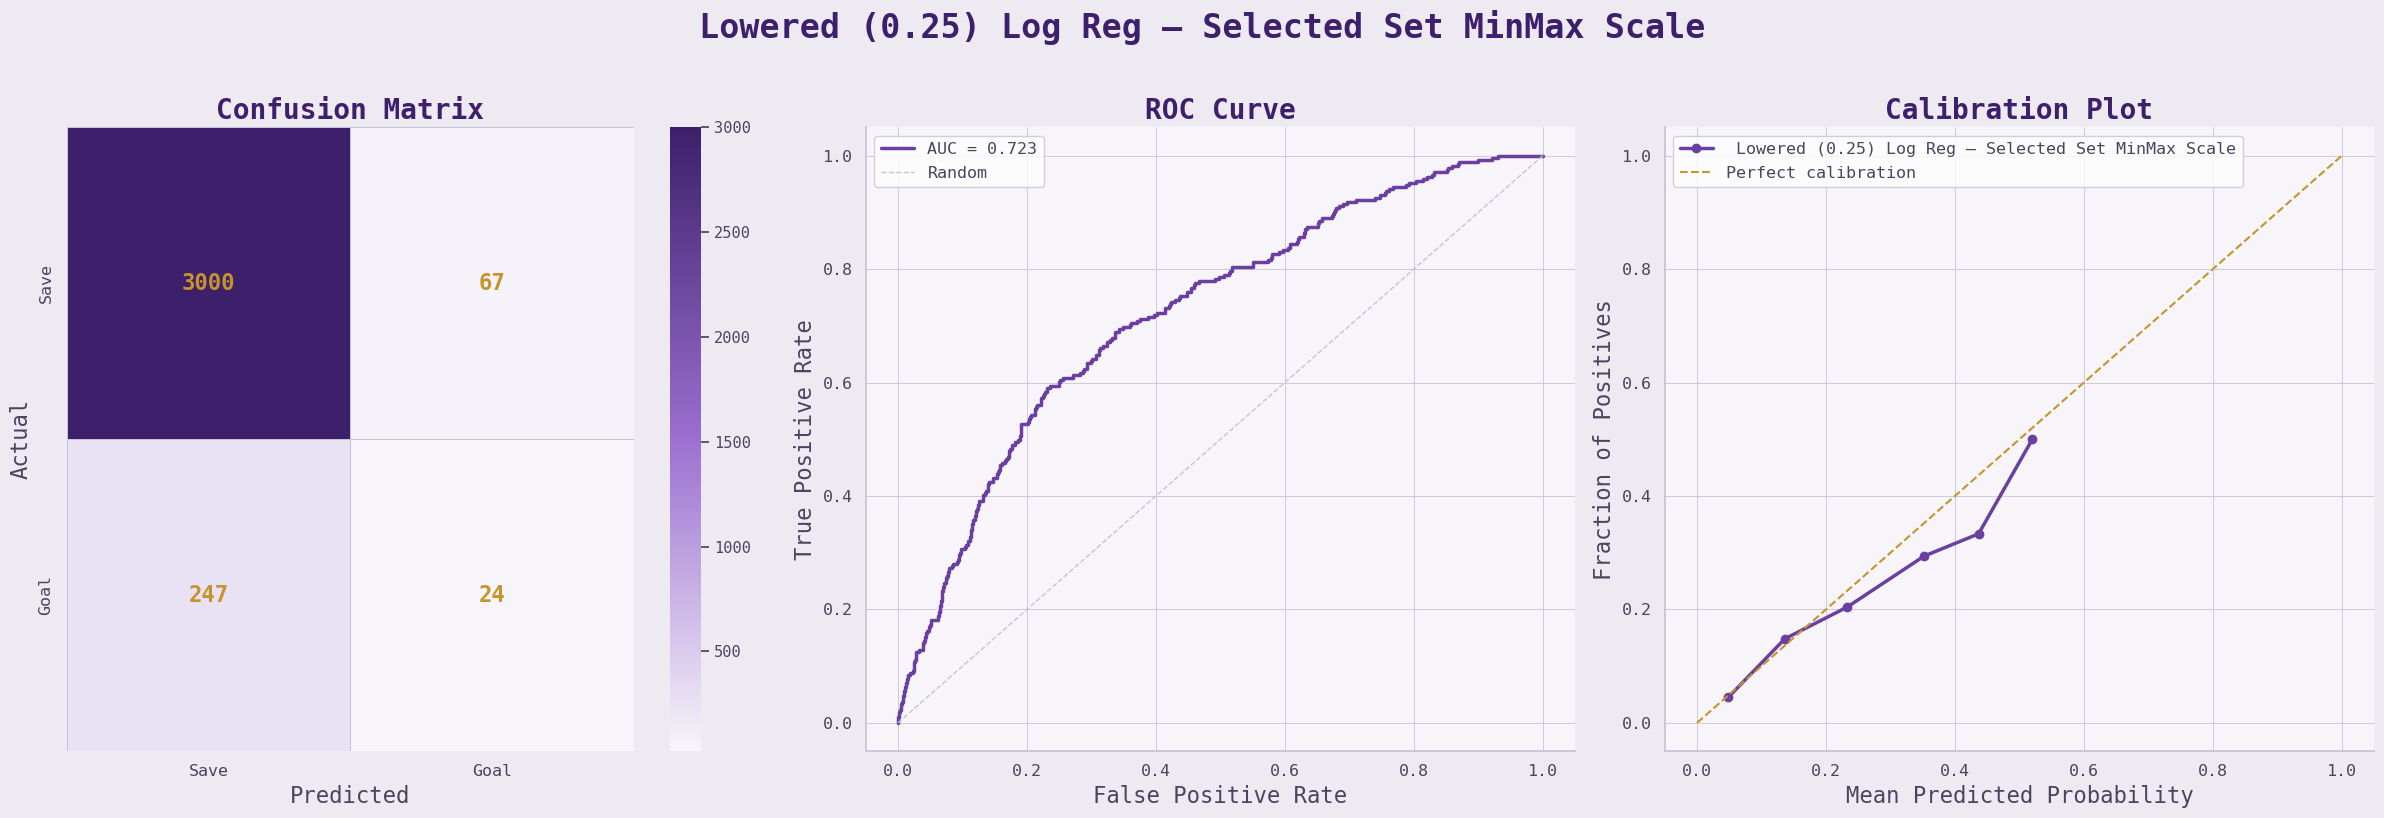

In [38]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name=" Lowered (0.25) Log Reg — Selected Set MinMax Scale",
           threshold = 0.25)


   Lowered (0.1) Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       71.63%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.95      0.73      0.82      3067
        Goal       0.16      0.61      0.26       271

    accuracy                           0.72      3338
   macro avg       0.56      0.67      0.54      3338
weighted avg       0.89      0.72      0.78      3338



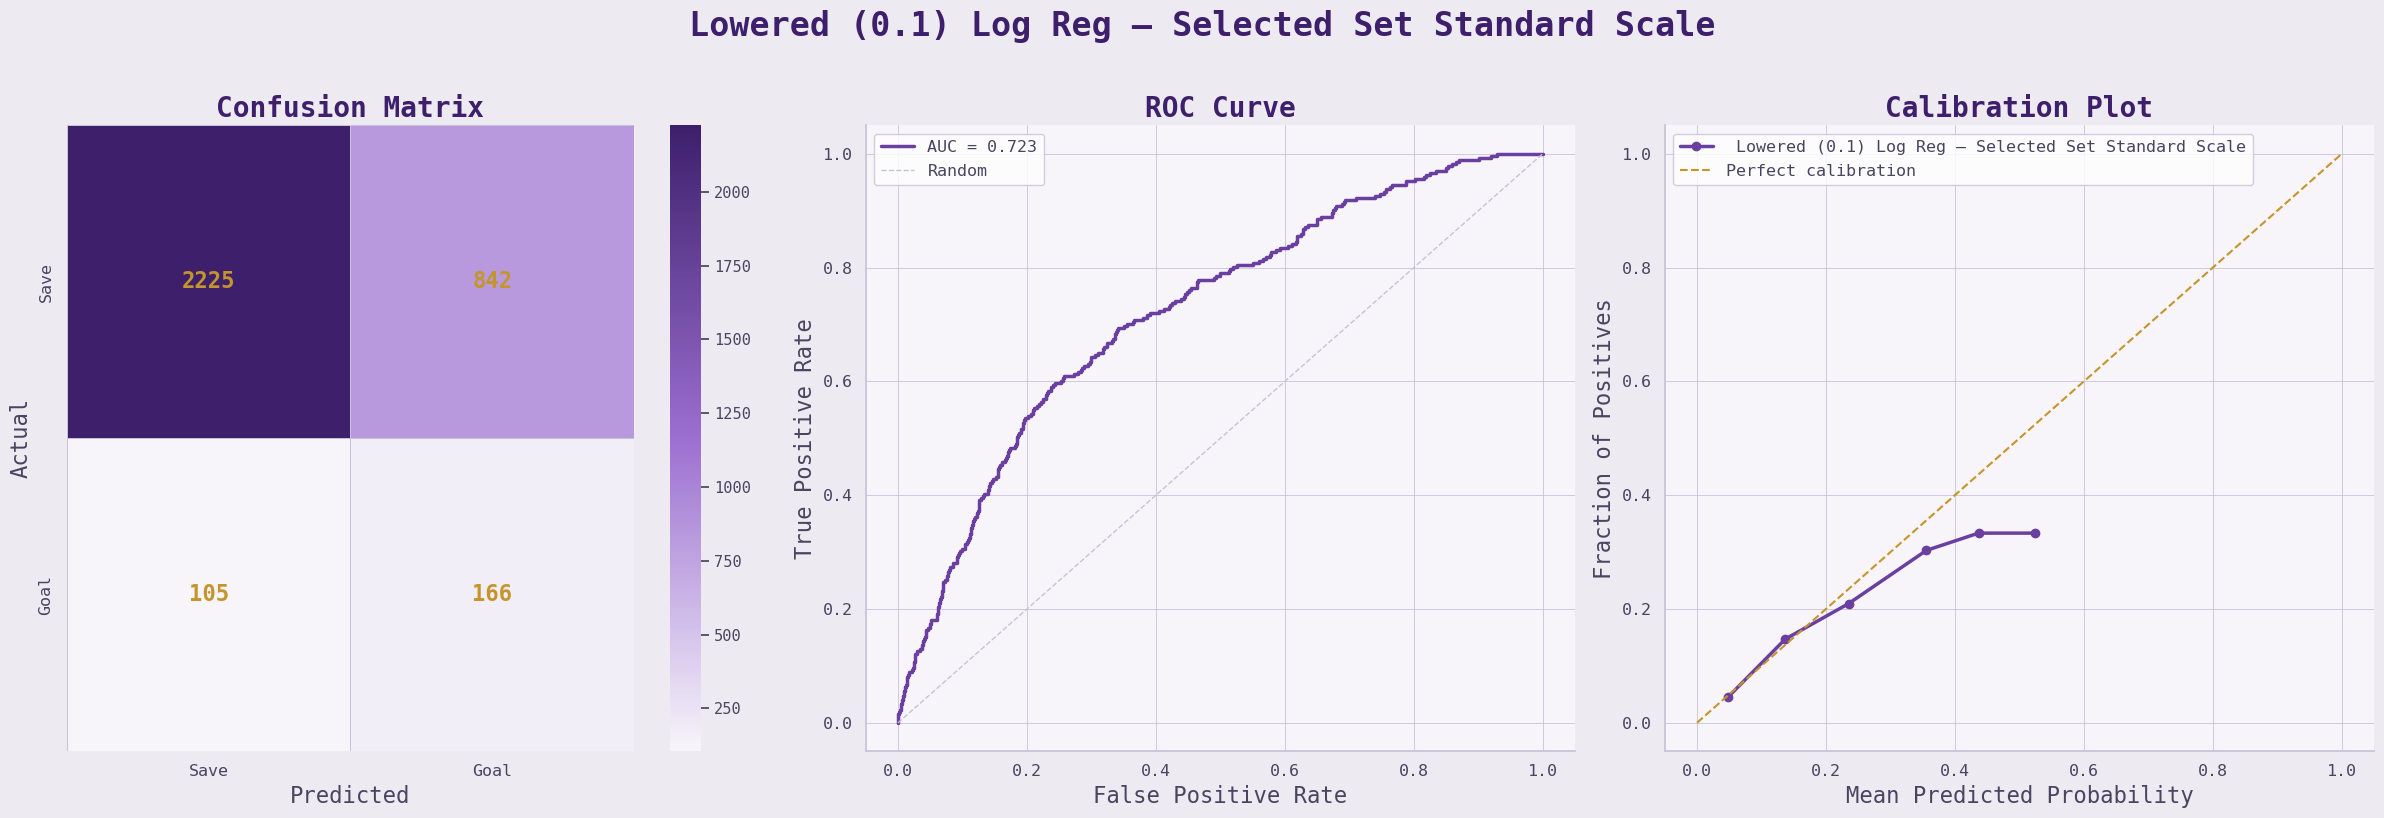

In [39]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name=" Lowered (0.1) Log Reg — Selected Set Standard Scale",
           threshold = 0.1, )

In [40]:
pd.DataFrame(eval_list).sort_values(['auc', 'accuracy'], ascending = [False, False])

model  accuracy     auc  \
2                   Log Reg — Full Set Standard Scale    0.9191  0.7743   
14   Lowered (0.25) Log Reg — Full Set Standard Scale    0.9008  0.7743   
15    Lowered (0.1) Log Reg — Full Set Standard Scale    0.7349  0.7743   
6          Balanced Log Reg — Full Set Standard Scale    0.6705  0.7734   
7            Balanced Log Reg — Full Set MinMax Scale    0.6735  0.7721   
11              SMOTE Log Reg — Full Set MinMax Scale    0.6762  0.7717   
10            SMOTE Log Reg — Full Set Standard Scale    0.6765  0.7714   
3                     Log Reg - Full Set MinMax Scale    0.9185  0.7709   
0                            Base Logistic Regression    0.9185  0.7485   
5                     Selected Log Reg - MinMax Scale    0.9188  0.7229   
18   Lowered (0.25) Log Reg — Selected Set MinMax ...    0.9059  0.7229   
4                   Selected Log Reg - Standard Scale    0.9185  0.7226   
16   Lowered (0.25) Log Reg — Selected Set Standar...    0.9056  0.7226   
17   Lowered (0.1) Log Reg — Selected Set Standard...    0.7163  0.7226   
19   Lowered (0.1) Log Reg — Selected Set Standard...    0.7163  0.7226   
9        Balanced Log Reg — Selected Set MinMax Scale    0.6300  0.7209   
8      Balanced Log Reg — Selected Set Standard Scale    0.6318  0.7208   
12        SMOTE Log Reg — Selected Set Standard Scale    0.6315  0.7207   
13        SMOTE Log Reg — Selected Set Standard Scale    0.6306  0.7204   
1                        Selected Logistic Regression    0.9188  0.7152   

    log_loss  avg_prec  
2     0.2443    0.2418  
14    0.2443    0.2418  
15    0.2443    0.2418  
6     0.5755    0.2361  
7     0.5770    0.2349  
11    0.5741    0.2313  
10    0.5712    0.2342  
3     0.2454    0.2372  
0     0.2521    0.1994  
5     0.2575    0.1948  
18    0.2575    0.1948  
4     0.2576    0.1952  
16    0.2576    0.1952  
17    0.2576    0.1952  
19    0.2576    0.1952  
9     0.6216    0.1947  
8     0.6218    0.1947  
12    0.6203    0.1940  
13    0.6205    0.1937  
1     0.2597    0.1854

There does seem to be some success in lowering the threshold in making predictions for goals, but not in a meaningful way in improving the models.

Up to this point:
- Scaling has a good impact, but difference between standard and minmax scaling so we'll stick to Standard
- Balancing the data had an overall negative impact on the models
- Lowering the threshold succeeded at making more goal predictions with a smaller decrease having a smaller negative impact on accuracy
- The full set of data is yielding better results than the smaller subset but fairly small.

I will try to tune the C-value hyperparameter in order to see if that will have an effect on the model.  Given what I've seen so far, I will focus on Standard Scaled data but will try different thresholds for predictions along with using the full and the selected datasets.

In [41]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

In [42]:
param_grid = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 5000]}
grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)

{'model__C': 500} 0.773947822754419


In [43]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(C = 500))
])


  Log Reg C 500 — Full Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       91.88%
  AUC:                            0.775
  Log Loss:                       0.244
  Avg Precision (PR-AUC):         0.241

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.50      0.02      0.04       271

    accuracy                           0.92      3338
   macro avg       0.71      0.51      0.50      3338
weighted avg       0.89      0.92      0.88      3338



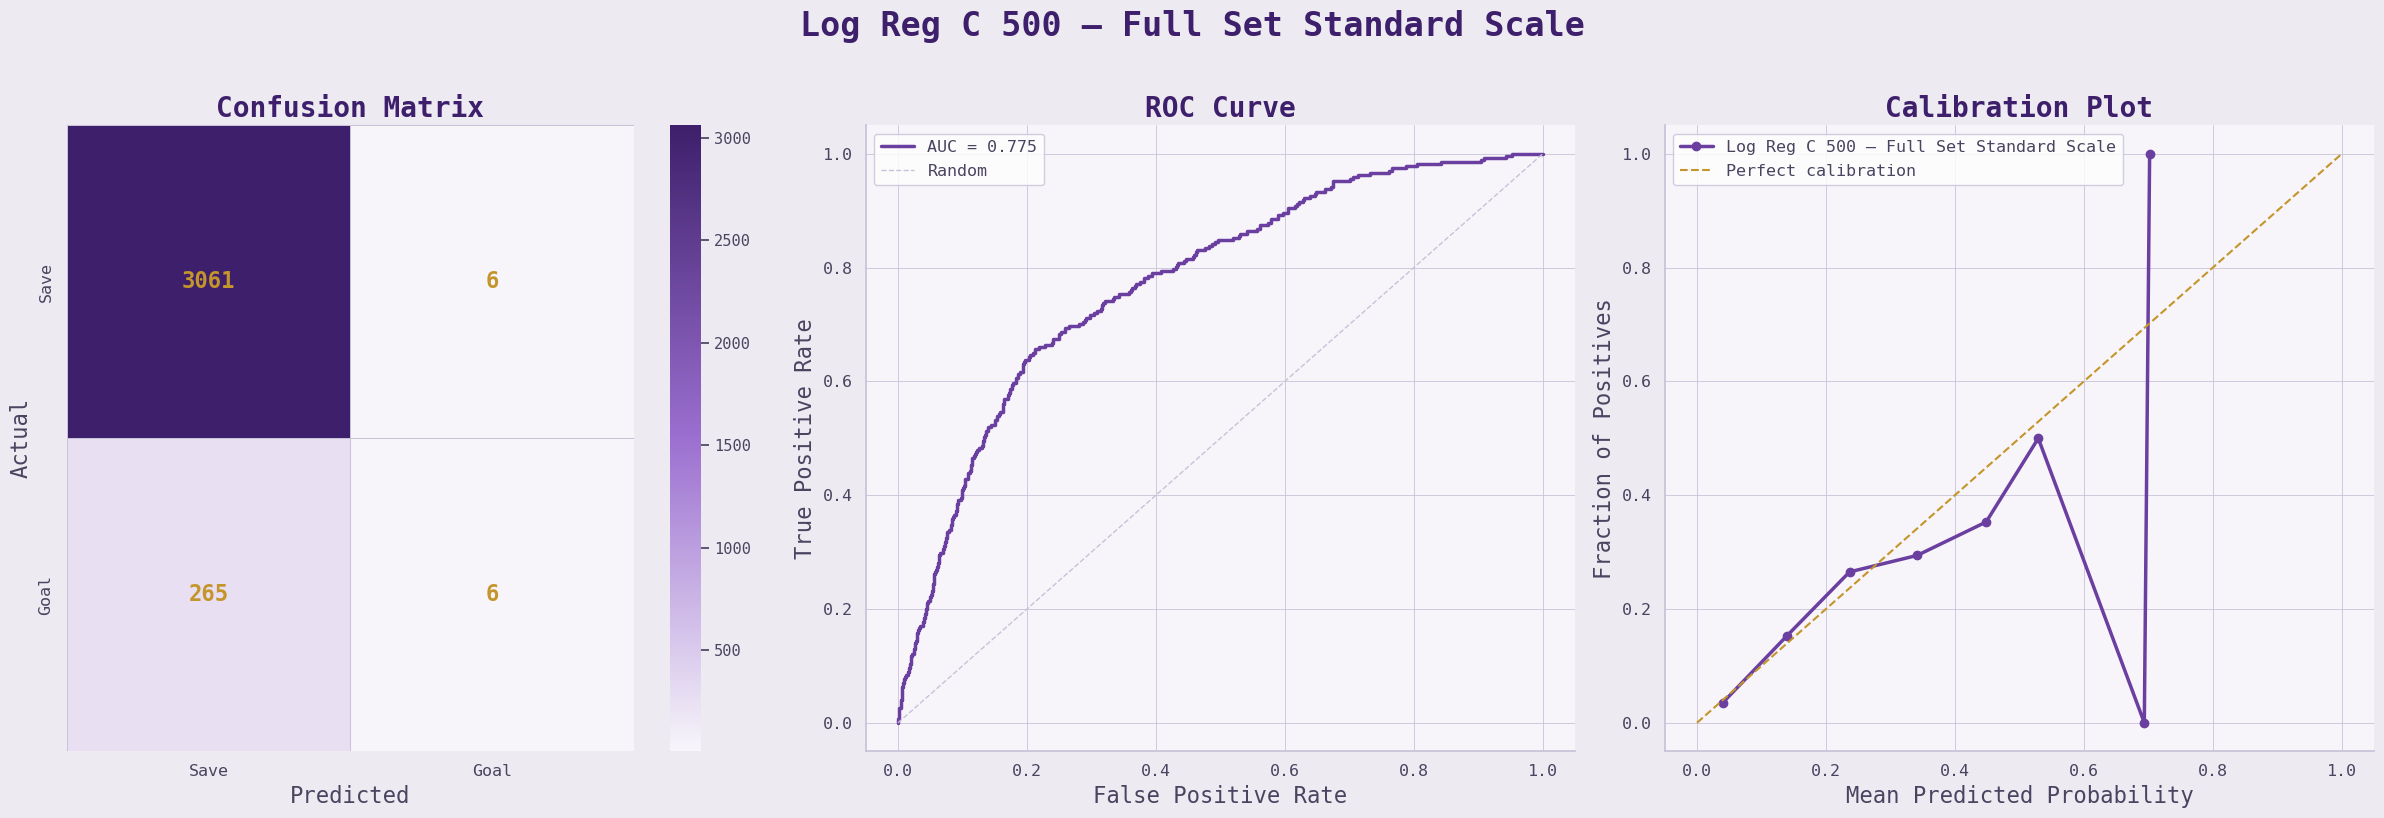

In [44]:
pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name="Log Reg C 500 — Full Set Standard Scale")


  Lowered (0.25) Log Reg C 500 — Full Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       90.05%
  AUC:                            0.775
  Log Loss:                       0.244
  Avg Precision (PR-AUC):         0.241

              precision    recall  f1-score   support

        Save       0.93      0.97      0.95      3067
        Goal       0.30      0.17      0.22       271

    accuracy                           0.90      3338
   macro avg       0.62      0.57      0.58      3338
weighted avg       0.88      0.90      0.89      3338



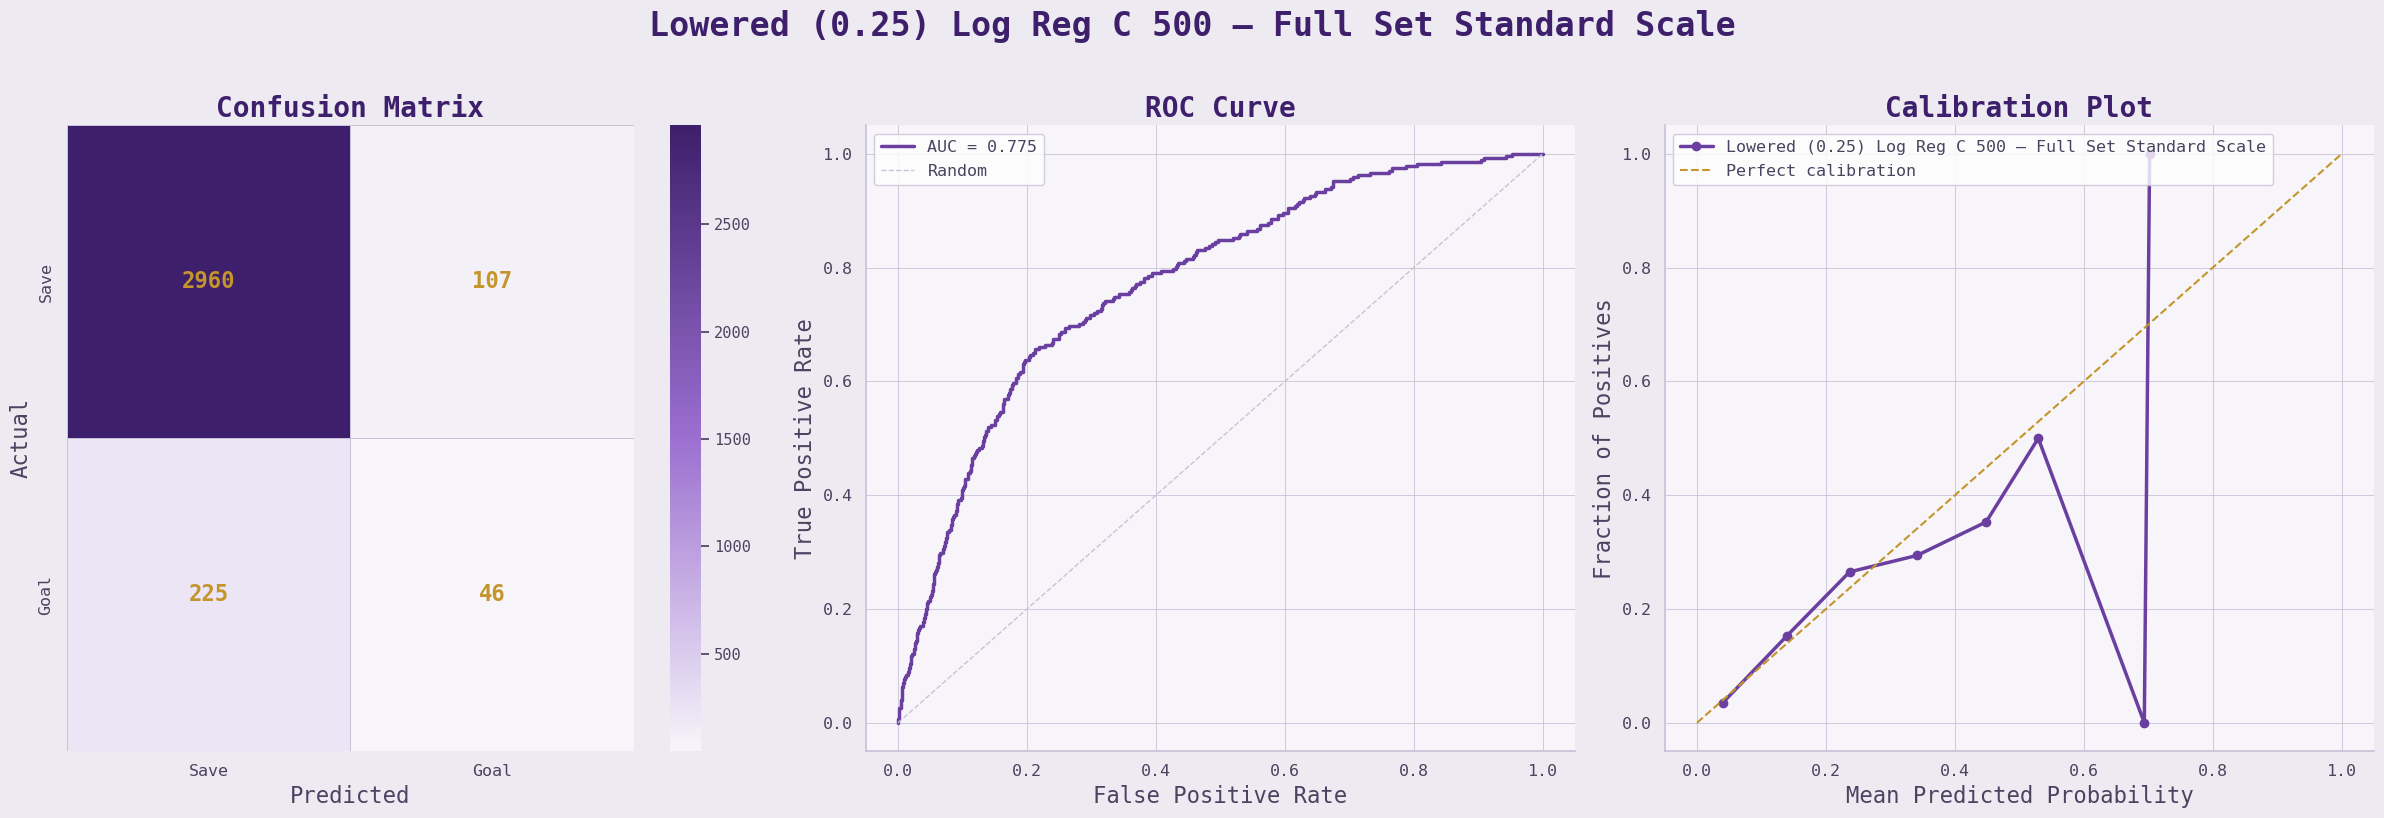

In [45]:
pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name="Lowered (0.25) Log Reg C 500 — Full Set Standard Scale",
           threshold = 0.25)

In [46]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

In [47]:
param_grid = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 5000]}
grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
grid.fit(X_train[selected_cols], y_train)
print(grid.best_params_, grid.best_score_)

{'model__C': 1000} 0.7288470245218402


In [48]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(C = 1000))
])


  Log Reg C 1000 — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       91.88%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.50      0.01      0.01       271

    accuracy                           0.92      3338
   macro avg       0.71      0.50      0.49      3338
weighted avg       0.89      0.92      0.88      3338



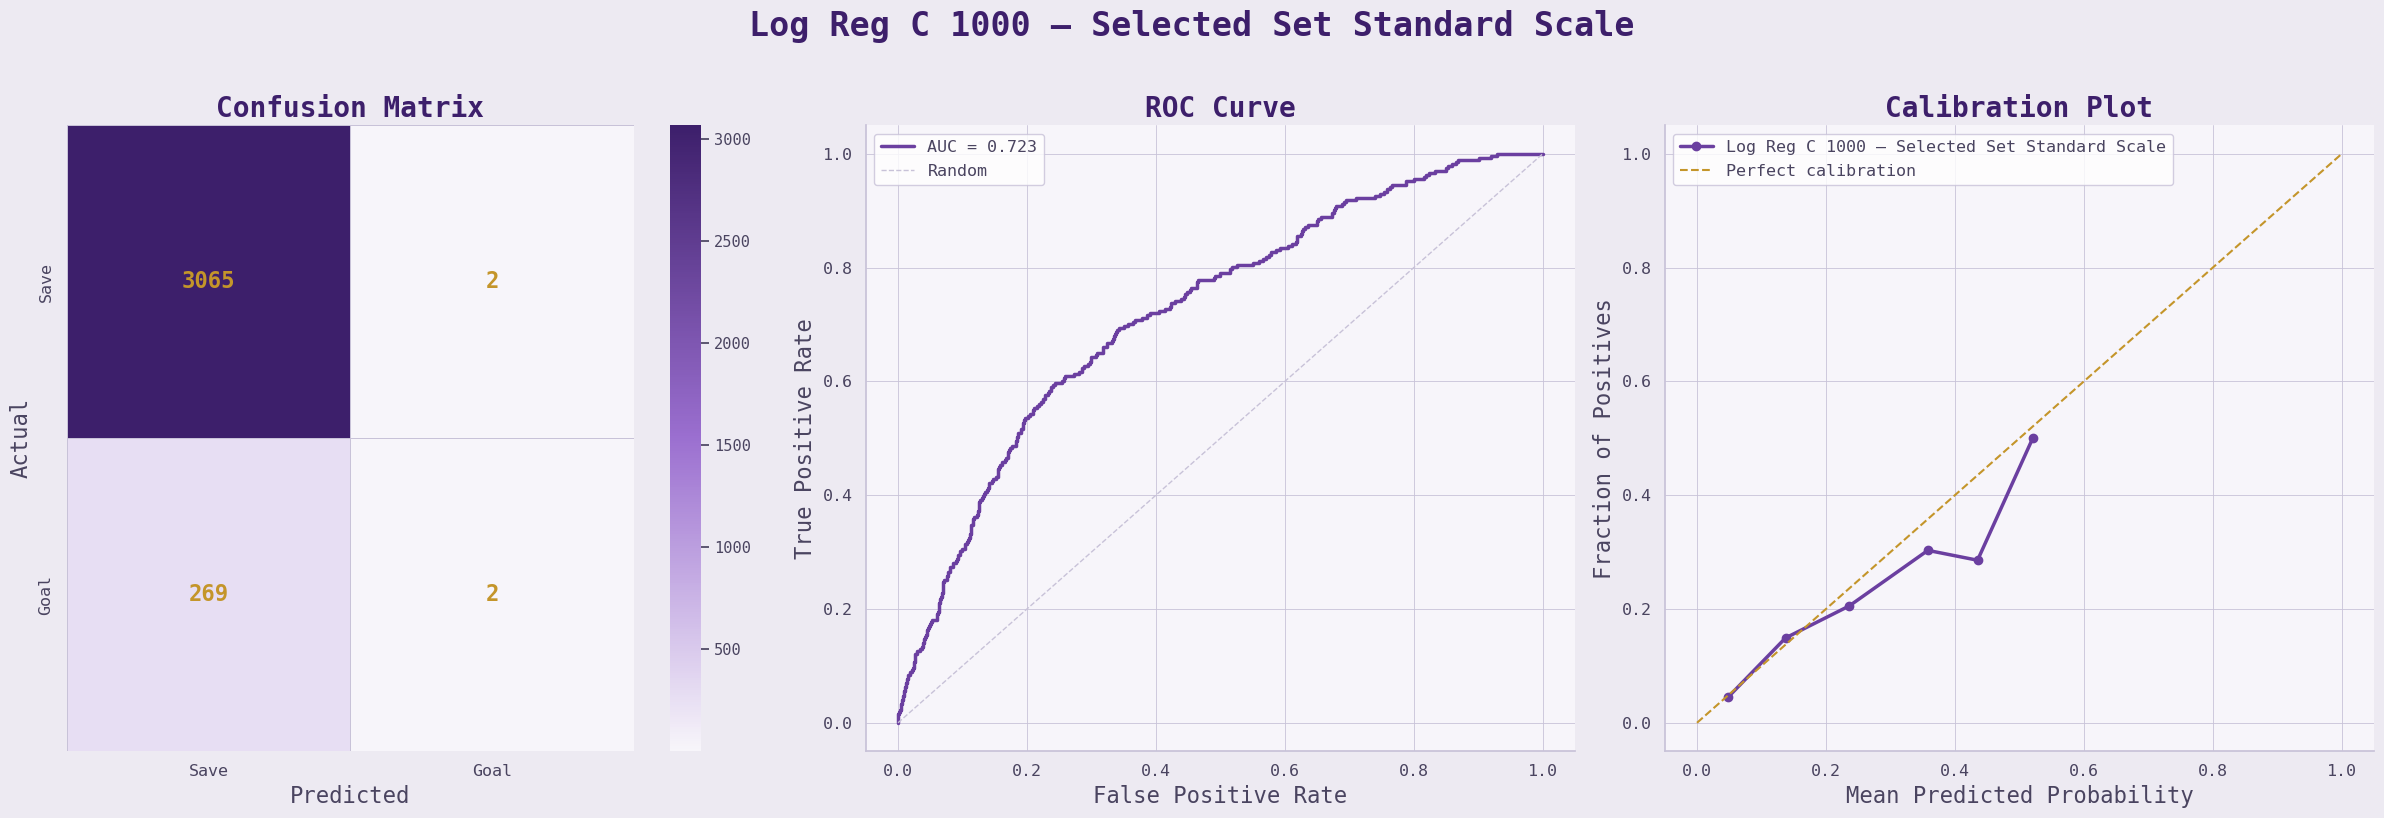

In [49]:
pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name="Log Reg C 1000 — Selected Set Standard Scale")


  Lowered (0.25) Log Reg C 1000 — Selected Set Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       90.5%
  AUC:                            0.723
  Log Loss:                       0.258
  Avg Precision (PR-AUC):         0.195

              precision    recall  f1-score   support

        Save       0.92      0.98      0.95      3067
        Goal       0.26      0.09      0.14       271

    accuracy                           0.91      3338
   macro avg       0.59      0.53      0.54      3338
weighted avg       0.87      0.91      0.88      3338



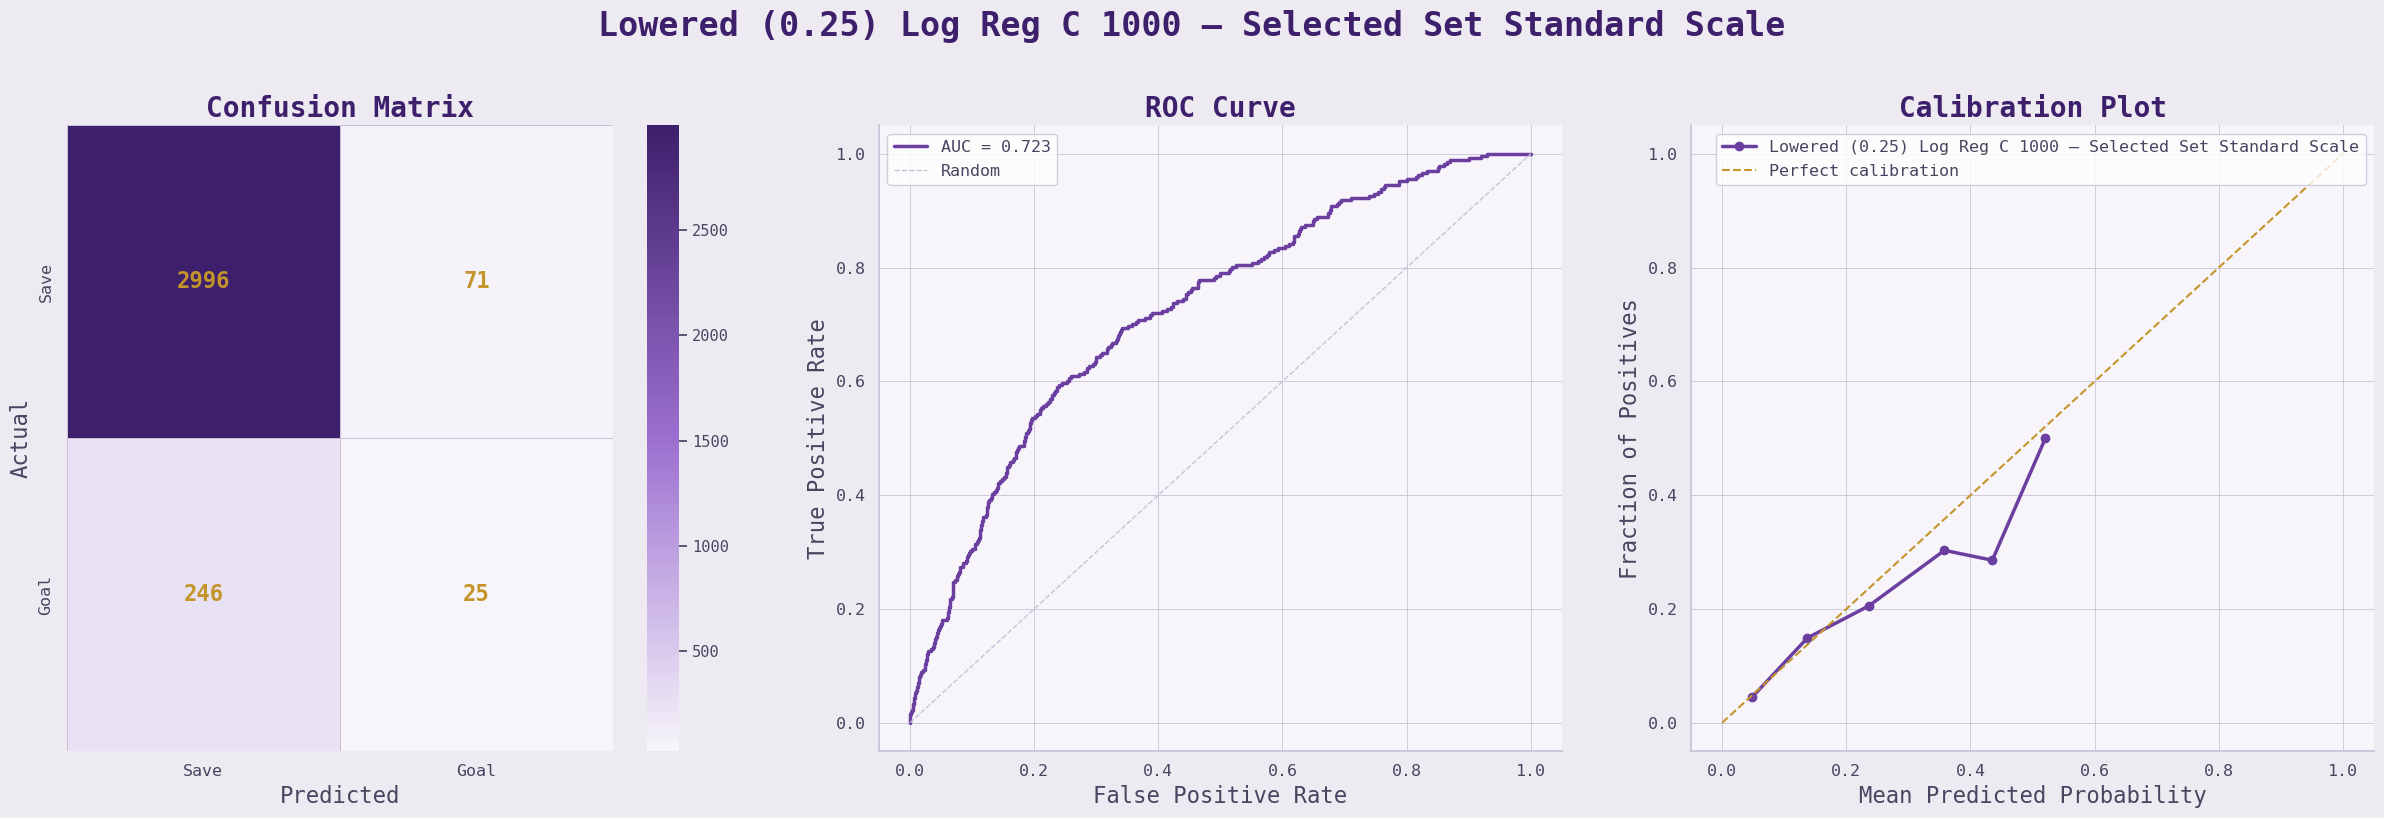

In [50]:
pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name="Lowered (0.25) Log Reg C 1000 — Selected Set Standard Scale",
           threshold = 0.25)

As a last chance to improve the model, I'm going to focus on just Even Strength situations.  As it is, this will include 5v5, 4v4 and 3v3 situations, but the hope is by narrowing the focus to these situations we will get a more accurate model for the time on ice that takes up the vast majority of the game.

Given the results so far, I will tune the C-value for Standard Scaled data, and try with a lower threshold, as those models seem to be performing the best.  If there is a distinct improvement, I will revisit other methods of modelling with the Even Strength data.

In [51]:
X_train_es = X_train[X_train['es'] == 1].drop(['es', 'pp', 'sh', 'skater_diff'], axis=1)
y_train_es = y_train[X_train['es'] == 1]

X_test_es  = X_test[X_test['es'] == 1].drop(['es', 'pp', 'sh', 'skater_diff'], axis=1)
y_test_es  = y_test[X_test['es'] == 1]

In [52]:
continuous_col_es = [c for c in continuous_col if c not in ["skater_diff"]]
boolean_col_es = [c for c in boolean_col if c not in ["es", "sh", "pp"]]

In [53]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_es),
    ('pass',  'passthrough',    boolean_col_es)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

In [54]:
param_grid = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 5000]}
grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
grid.fit(X_train_es, y_train_es)
print(grid.best_params_, grid.best_score_)

{'model__C': 10} 0.7514250461741537


In [55]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_es),
    ('pass',  'passthrough',    boolean_col_es)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(C = 10))
])


  Log Reg C 10 — Even Strength Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       90.87%
  AUC:                            0.759
  Log Loss:                       0.269
  Avg Precision (PR-AUC):         0.244

              precision    recall  f1-score   support

        Save       0.91      1.00      0.95      2608
        Goal       0.45      0.02      0.04       261

    accuracy                           0.91      2869
   macro avg       0.68      0.51      0.49      2869
weighted avg       0.87      0.91      0.87      2869



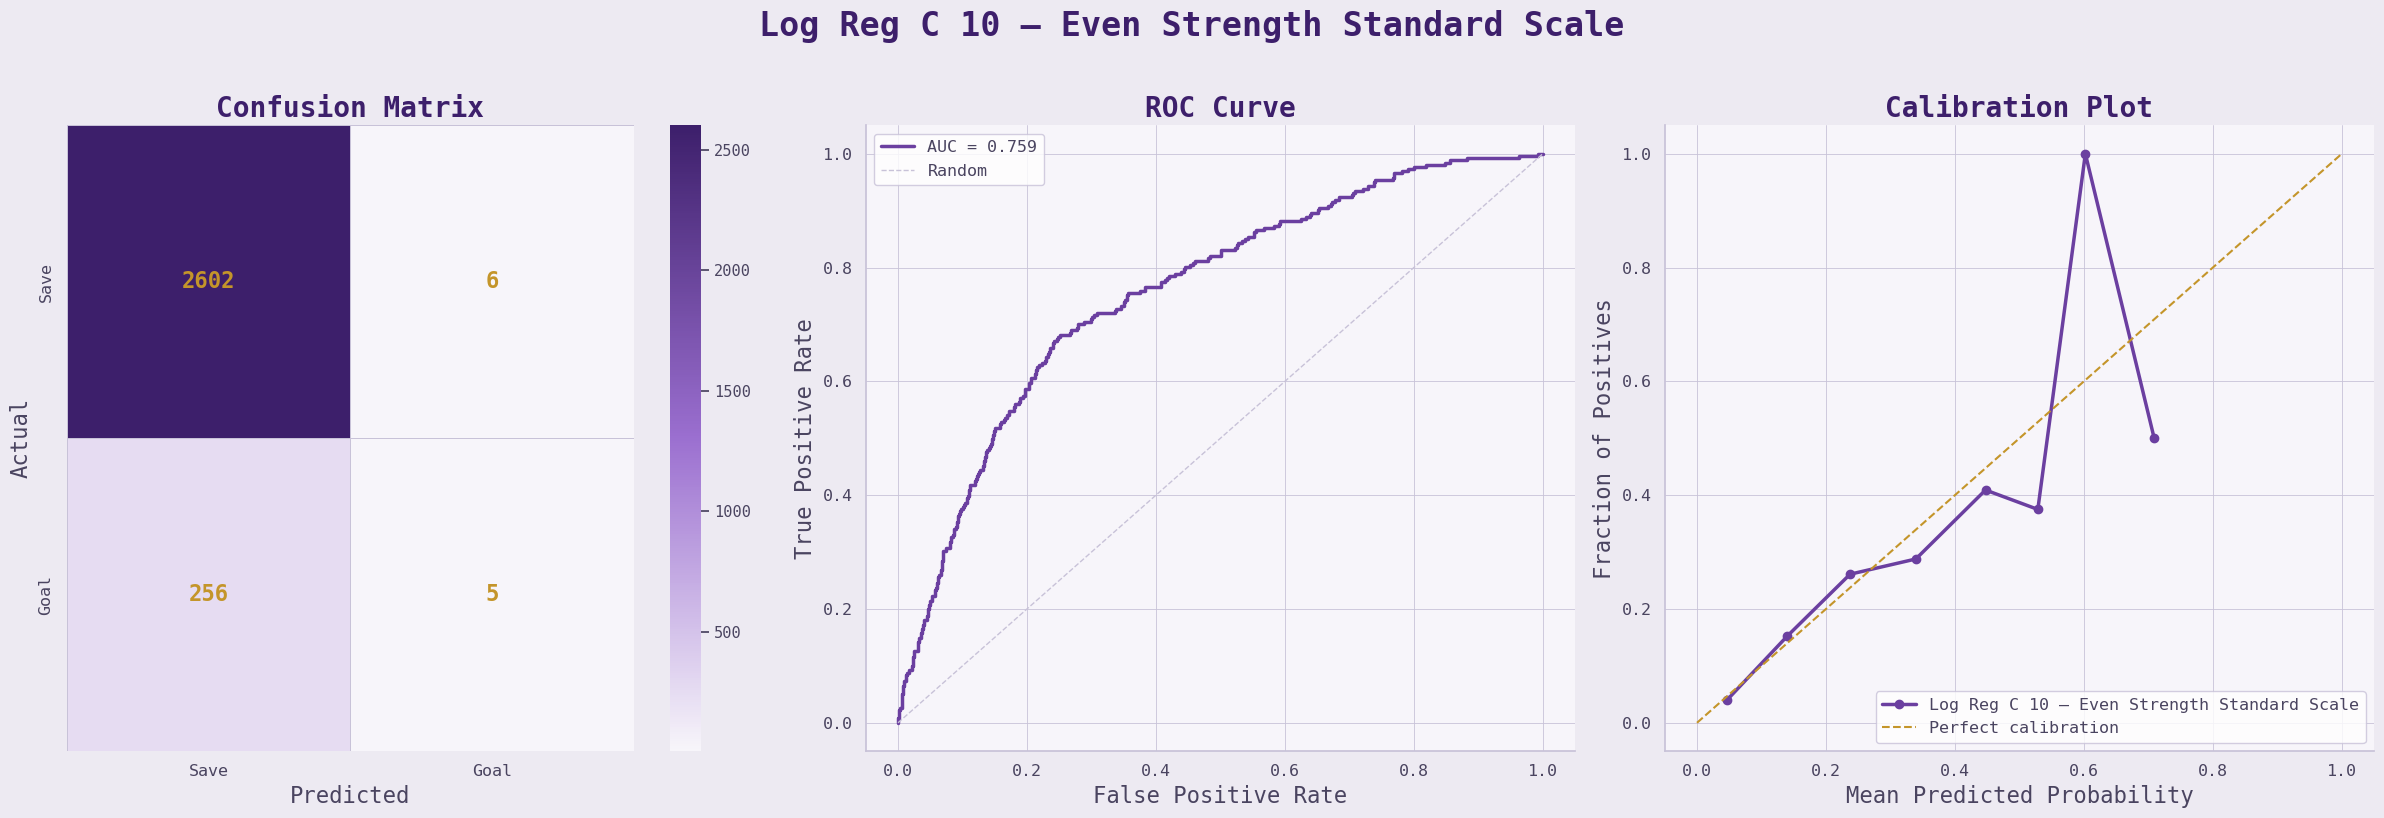

In [56]:
pipeline.fit(X_train_es, y_train_es)
model_eval(pipeline,
           X_test_es,
           y_test_es,
           model_name="Log Reg C 10 — Even Strength Standard Scale")


  Lowered (0.25) Log Reg C 10 — Even Strength Standard Scale
  Baseline (always predict save): 91.87%
  Accuracy:                       88.81%
  AUC:                            0.759
  Log Loss:                       0.269
  Avg Precision (PR-AUC):         0.244

              precision    recall  f1-score   support

        Save       0.92      0.96      0.94      2608
        Goal       0.31      0.18      0.23       261

    accuracy                           0.89      2869
   macro avg       0.61      0.57      0.58      2869
weighted avg       0.87      0.89      0.87      2869



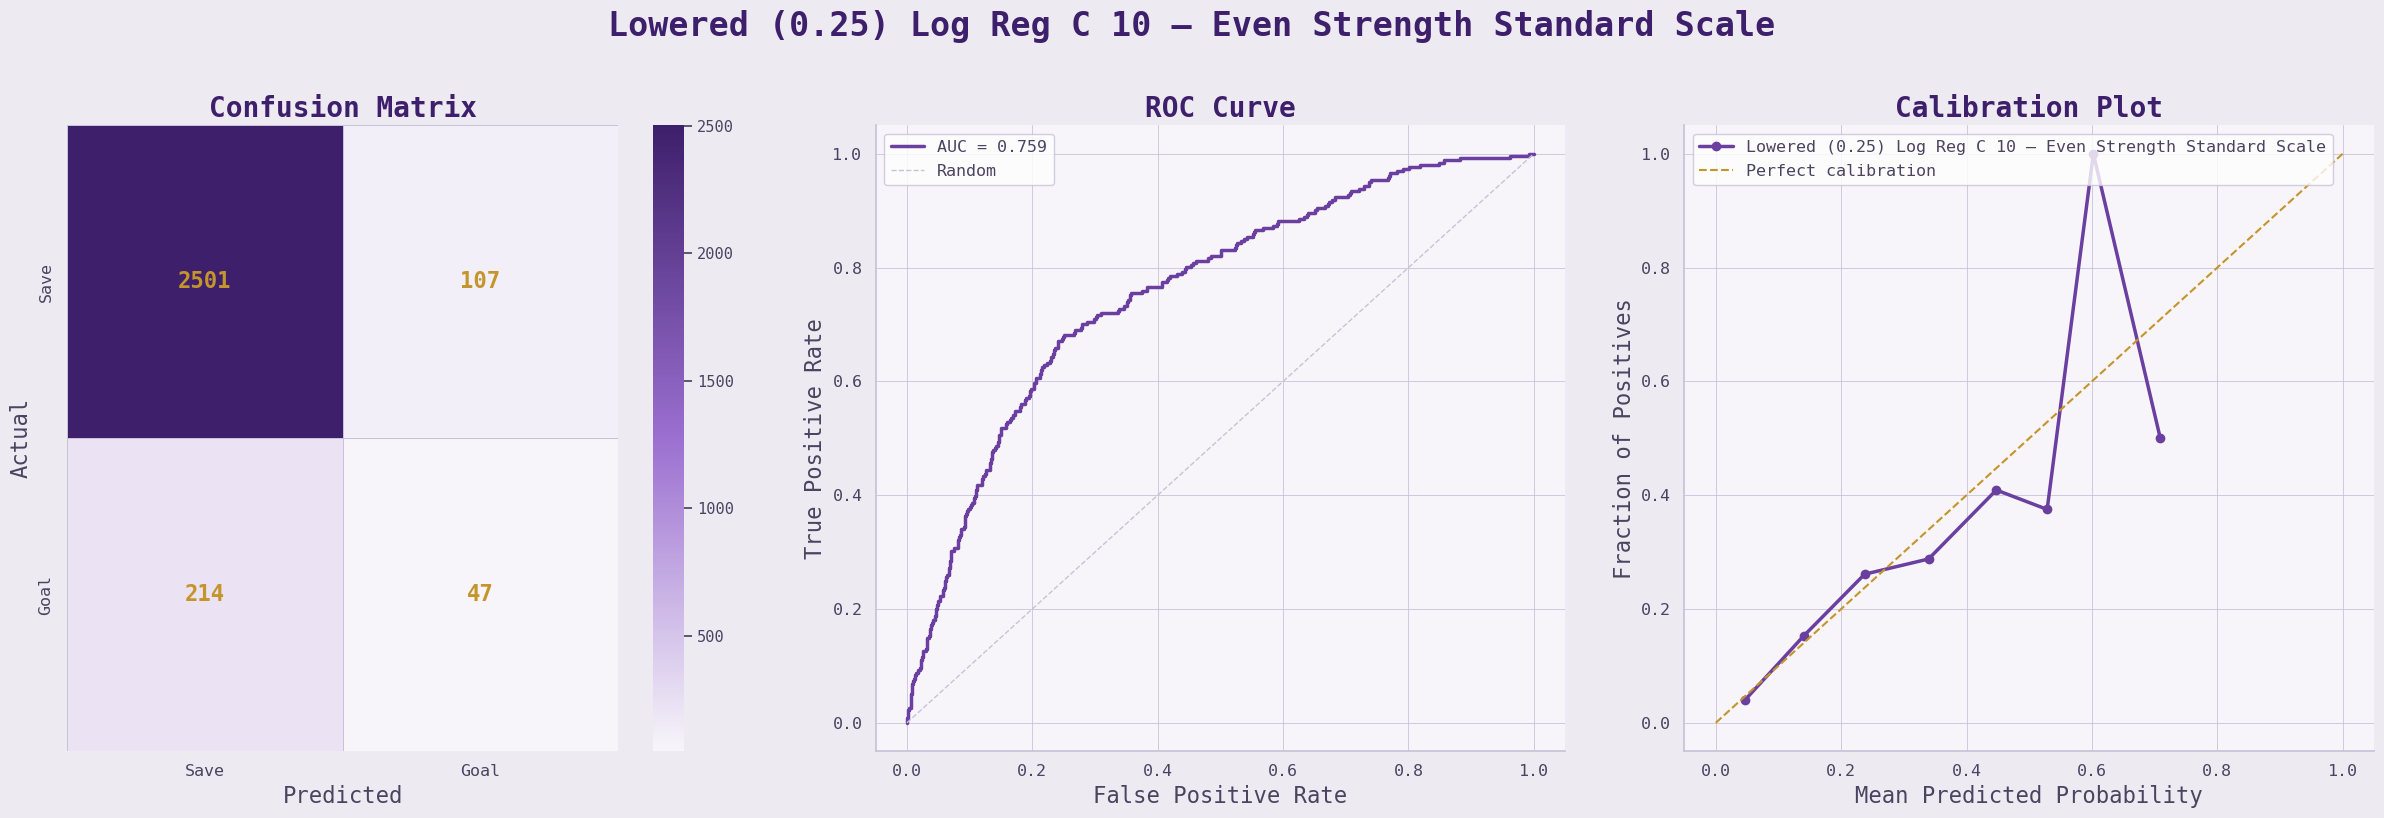

In [57]:
pipeline.fit(X_train_es, y_train_es)
model_eval(pipeline,
           X_test_es,
           y_test_es,
           model_name="Lowered (0.25) Log Reg C 10 — Even Strength Standard Scale",
          threshold = 0.25)

In [58]:
pd.DataFrame(eval_list).sort_values(['auc', 'accuracy'], ascending = [False, False])

model  accuracy     auc  \
20            Log Reg C 500 — Full Set Standard Scale    0.9188  0.7747   
21  Lowered (0.25) Log Reg C 500 — Full Set Standa...    0.9005  0.7747   
2                   Log Reg — Full Set Standard Scale    0.9191  0.7743   
14   Lowered (0.25) Log Reg — Full Set Standard Scale    0.9008  0.7743   
15    Lowered (0.1) Log Reg — Full Set Standard Scale    0.7349  0.7743   
6          Balanced Log Reg — Full Set Standard Scale    0.6705  0.7734   
7            Balanced Log Reg — Full Set MinMax Scale    0.6735  0.7721   
11              SMOTE Log Reg — Full Set MinMax Scale    0.6762  0.7717   
10            SMOTE Log Reg — Full Set Standard Scale    0.6765  0.7714   
3                     Log Reg - Full Set MinMax Scale    0.9185  0.7709   
24        Log Reg C 10 — Even Strength Standard Scale    0.9087  0.7585   
25  Lowered (0.25) Log Reg C 10 — Even Strength St...    0.8881  0.7585   
0                            Base Logistic Regression    0.9185  0.7485   
5                     Selected Log Reg - MinMax Scale    0.9188  0.7229   
18   Lowered (0.25) Log Reg — Selected Set MinMax ...    0.9059  0.7229   
22       Log Reg C 1000 — Selected Set Standard Scale    0.9188  0.7226   
4                   Selected Log Reg - Standard Scale    0.9185  0.7226   
16   Lowered (0.25) Log Reg — Selected Set Standar...    0.9056  0.7226   
23  Lowered (0.25) Log Reg C 1000 — Selected Set S...    0.9050  0.7226   
17   Lowered (0.1) Log Reg — Selected Set Standard...    0.7163  0.7226   
19   Lowered (0.1) Log Reg — Selected Set Standard...    0.7163  0.7226   
9        Balanced Log Reg — Selected Set MinMax Scale    0.6300  0.7209   
8      Balanced Log Reg — Selected Set Standard Scale    0.6318  0.7208   
12        SMOTE Log Reg — Selected Set Standard Scale    0.6315  0.7207   
13        SMOTE Log Reg — Selected Set Standard Scale    0.6306  0.7204   
1                        Selected Logistic Regression    0.9188  0.7152   

    log_loss  avg_prec  
20    0.2442    0.2415  
21    0.2442    0.2415  
2     0.2443    0.2418  
14    0.2443    0.2418  
15    0.2443    0.2418  
6     0.5755    0.2361  
7     0.5770    0.2349  
11    0.5741    0.2313  
10    0.5712    0.2342  
3     0.2454    0.2372  
24    0.2689    0.2436  
25    0.2689    0.2436  
0     0.2521    0.1994  
5     0.2575    0.1948  
18    0.2575    0.1948  
22    0.2576    0.1951  
4     0.2576    0.1952  
16    0.2576    0.1952  
23    0.2576    0.1951  
17    0.2576    0.1952  
19    0.2576    0.1952  
9     0.6216    0.1947  
8     0.6218    0.1947  
12    0.6203    0.1940  
13    0.6205    0.1937  
1     0.2597    0.1854

### Logistic Regression Summary

The best performing Logistic Regression Models used the full dataset with Standard scaling.  Tuning the c-value up to 500 produced the highest performing model with an **AUC = 0.7749**.

However, it was difficult to get the Logistic Regression models to reliably predict goals in general.  The best performing model only made *12* goal predictions, with a precision of 50%.  Decreasing the threshold did increase the number of goal predictions, but lowered the precision for goal predictions down to 30%.

An effective xG model will need to predict goals reliably, and have more precision in doing so.  Therefore we will move to a more advanced model. 

<a id = 'xgboost'></a>

## 2. XGBoost Modelling


  XGBoost - Base
  Baseline (always predict save): 91.87%
  Accuracy:                       91.34%
  AUC:                            0.734
  Log Loss:                       0.279
  Avg Precision (PR-AUC):         0.185

              precision    recall  f1-score   support

        Save       0.92      0.99      0.95      3067
        Goal       0.24      0.03      0.05       271

    accuracy                           0.91      3338
   macro avg       0.58      0.51      0.50      3338
weighted avg       0.86      0.91      0.88      3338



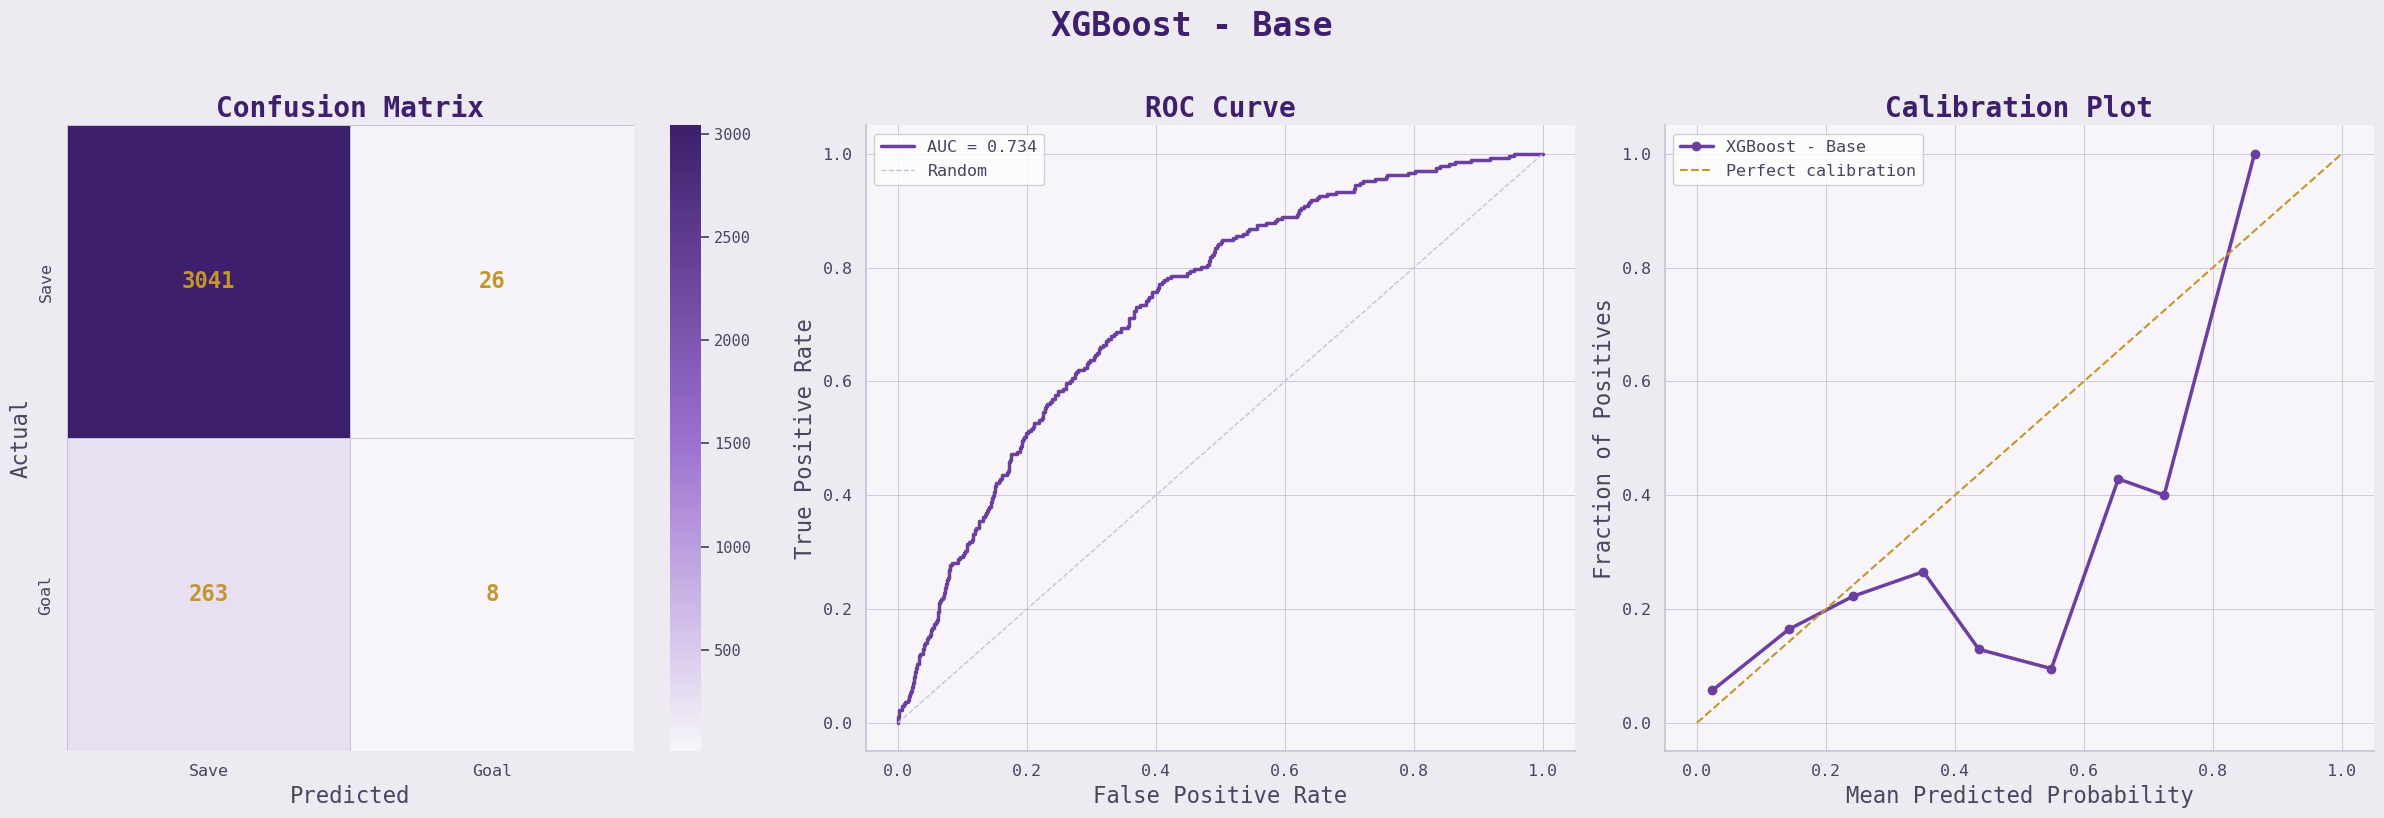

In [76]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss')

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Base")

This is a more promising start compared to the Logistic Regression models.  The AUC is lower, but the base model is already predicting more goals, albeit still a small number.

The first adjustment I want to make is to address the class imbalance.  I'll try a weighting that reflects the mismatch in the classes, and then try to strengthen and weaken the weighting.


  XGBoost - Balanced
  Baseline (always predict save): 91.87%
  Accuracy:                       85.83%
  AUC:                            0.732
  Log Loss:                       0.333
  Avg Precision (PR-AUC):         0.185

              precision    recall  f1-score   support

        Save       0.94      0.91      0.92      3067
        Goal       0.23      0.31      0.26       271

    accuracy                           0.86      3338
   macro avg       0.58      0.61      0.59      3338
weighted avg       0.88      0.86      0.87      3338



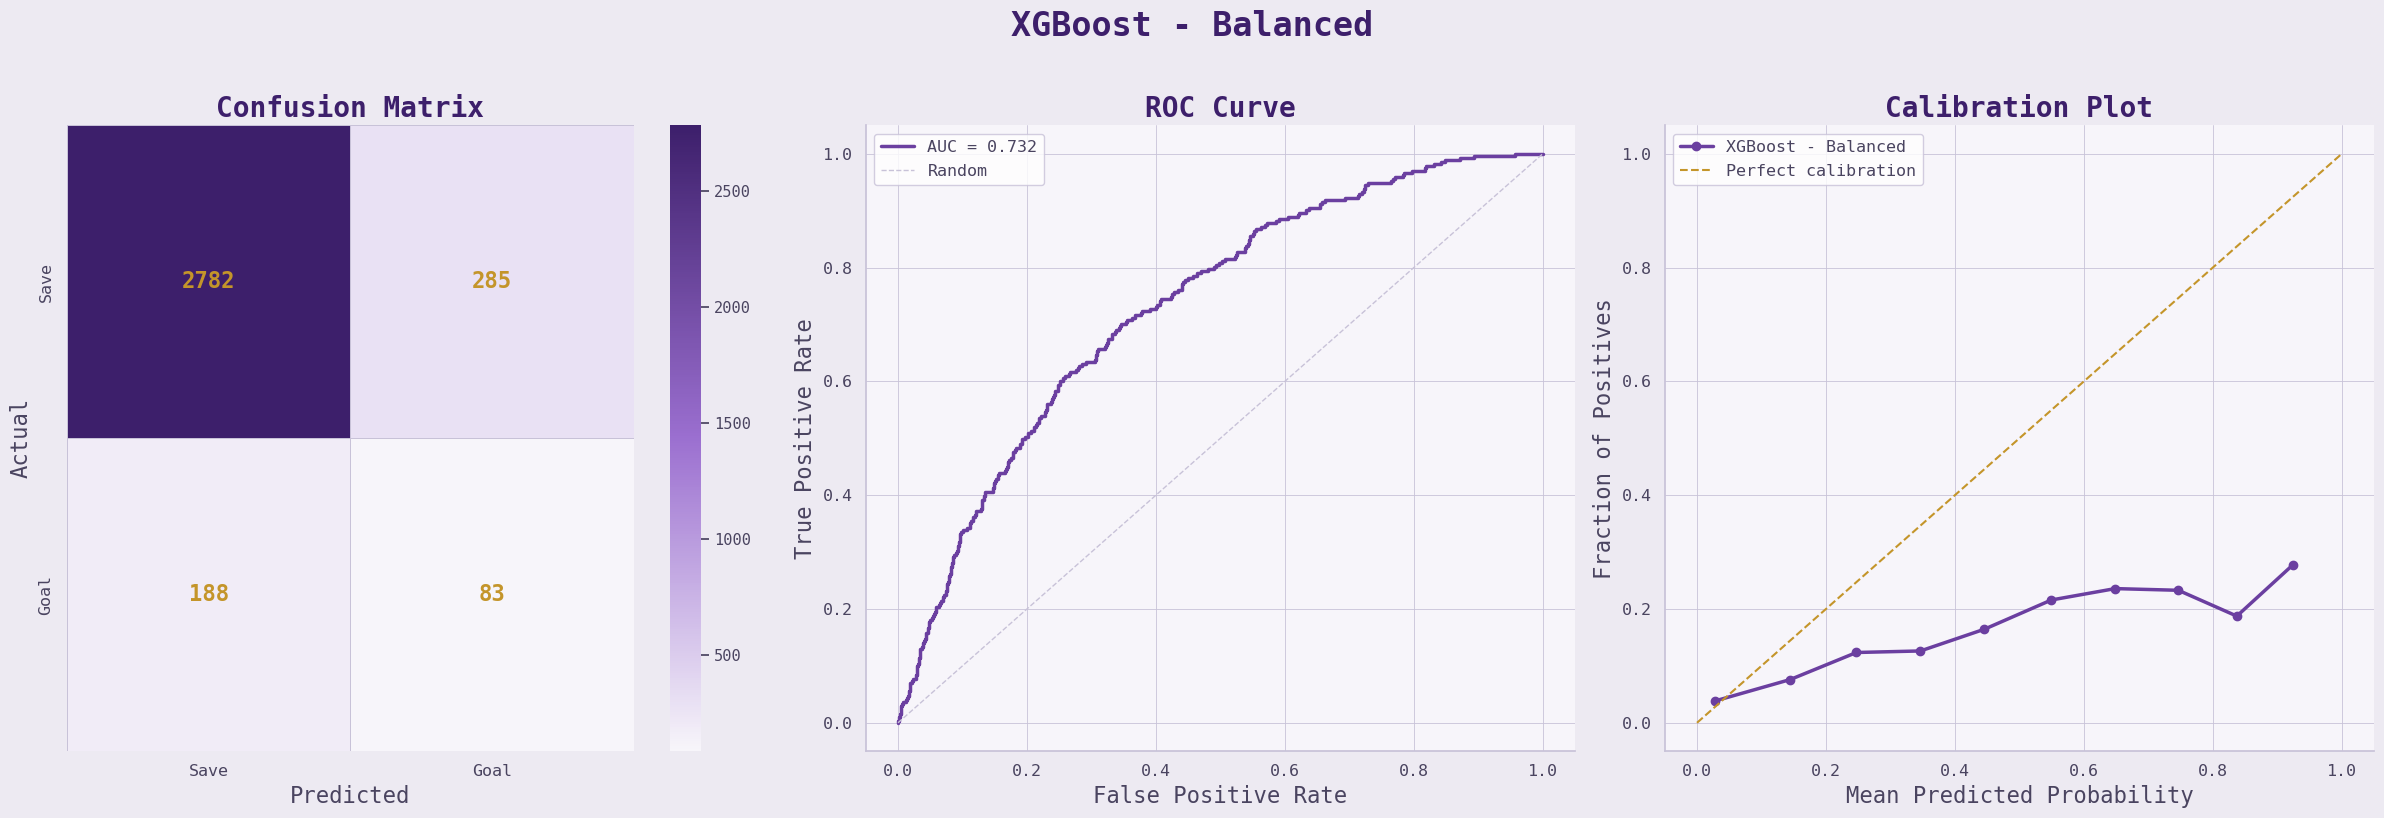

In [77]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]))

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Weighted")


  XGBoost - Balance Doubled
  Baseline (always predict save): 91.87%
  Accuracy:                       83.19%
  AUC:                            0.721
  Log Loss:                       0.383
  Avg Precision (PR-AUC):         0.171

              precision    recall  f1-score   support

        Save       0.94      0.87      0.91      3067
        Goal       0.20      0.36      0.26       271

    accuracy                           0.83      3338
   macro avg       0.57      0.62      0.58      3338
weighted avg       0.88      0.83      0.85      3338



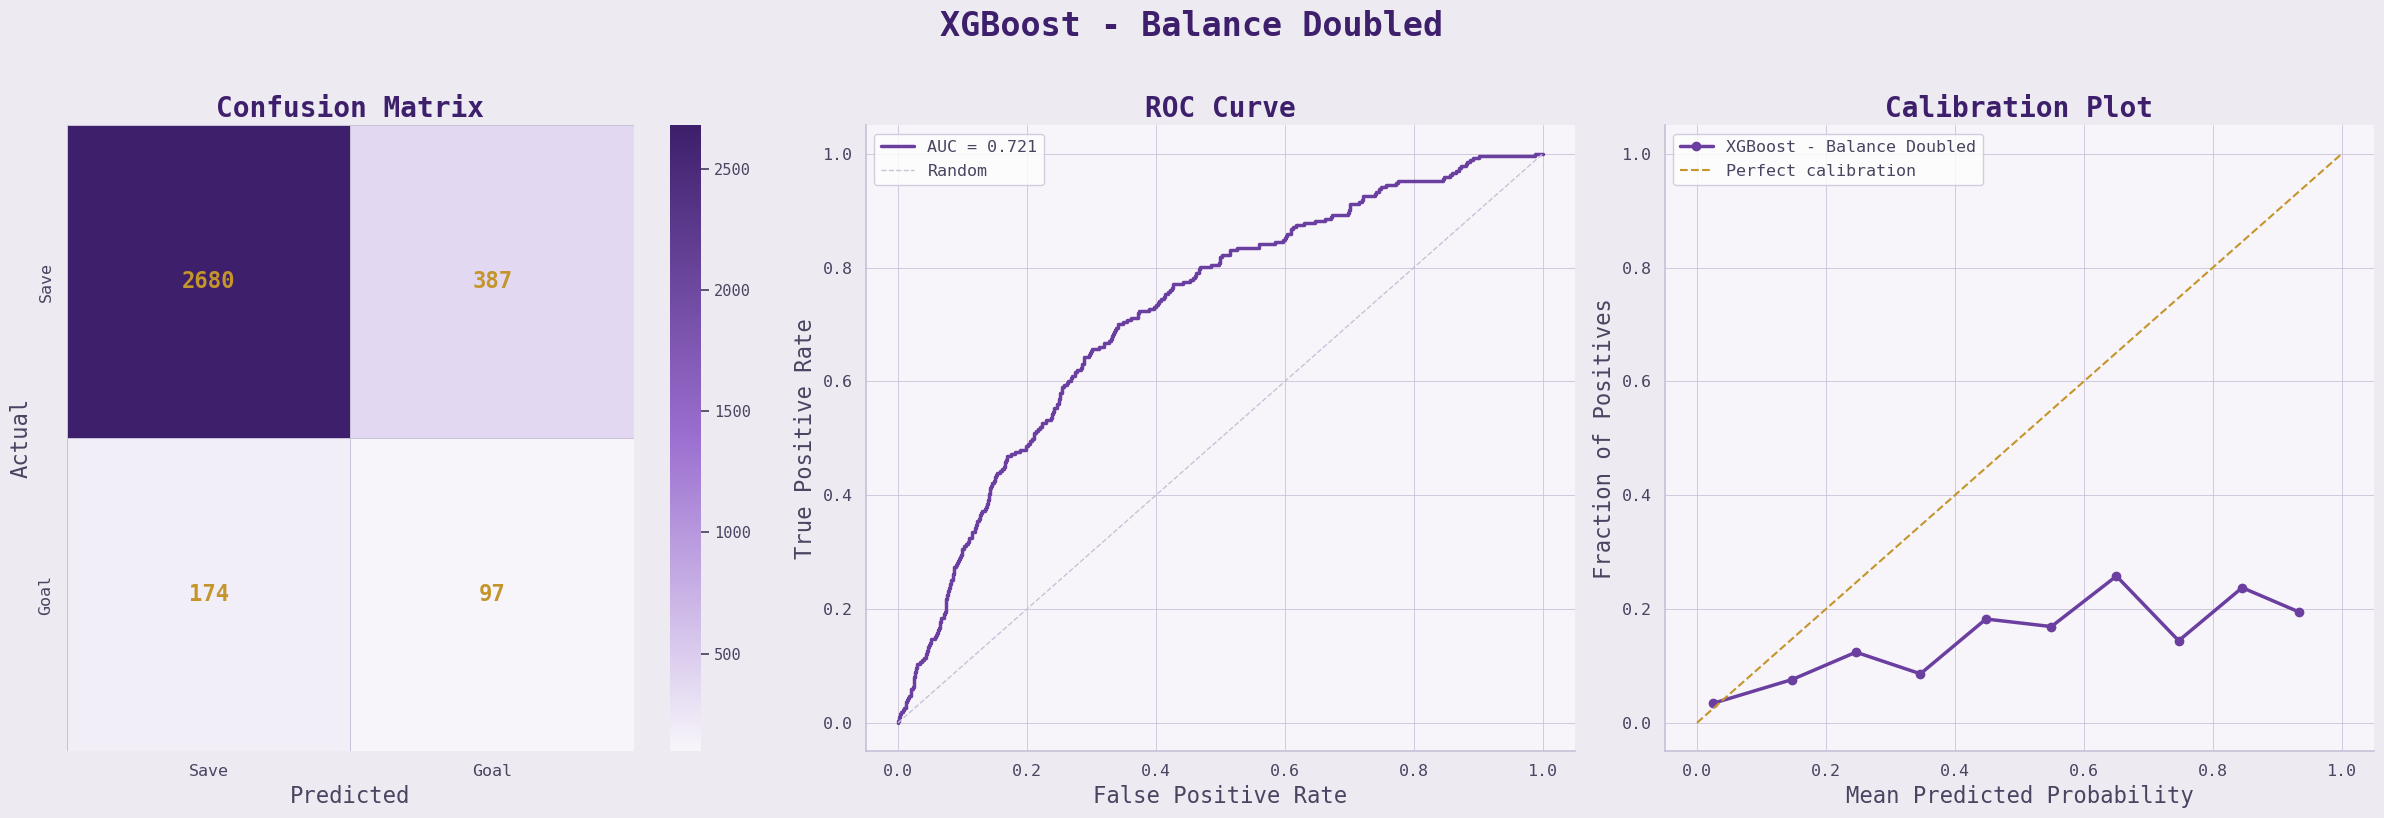

In [84]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])*2))

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Weighted Doubled")


  XGBoost - Weighted Halved
  Baseline (always predict save): 91.87%
  Accuracy:                       88.44%
  AUC:                            0.719
  Log Loss:                       0.303
  Avg Precision (PR-AUC):         0.184

              precision    recall  f1-score   support

        Save       0.93      0.95      0.94      3067
        Goal       0.21      0.15      0.18       271

    accuracy                           0.88      3338
   macro avg       0.57      0.55      0.56      3338
weighted avg       0.87      0.88      0.88      3338



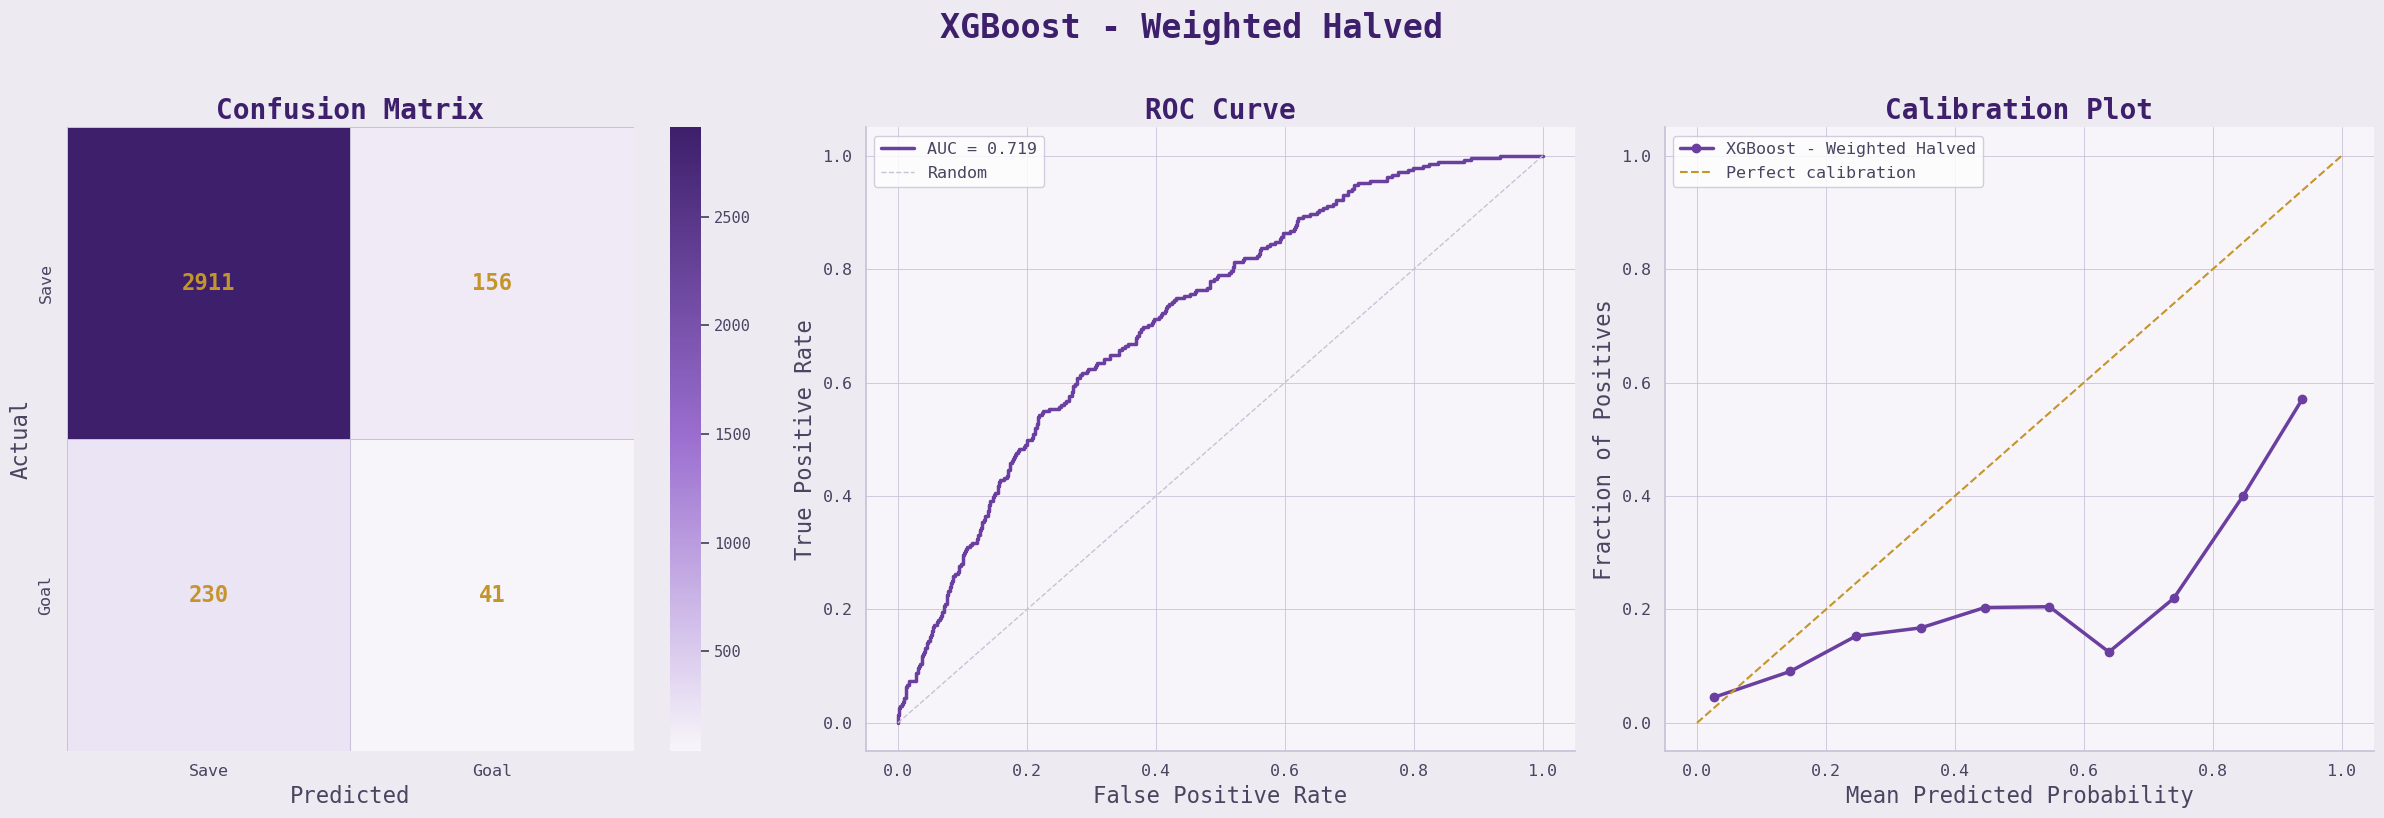

In [85]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])/2))

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Weighted Halved")


  XGBoost Base
  Baseline (always predict save): 91.87%
  Accuracy:                       91.34%
  AUC:                            0.734
  Log Loss:                       0.279
  Avg Precision (PR-AUC):         0.185

              precision    recall  f1-score   support

        Save       0.92      0.99      0.95      3067
        Goal       0.24      0.03      0.05       271

    accuracy                           0.91      3338
   macro avg       0.58      0.51      0.50      3338
weighted avg       0.86      0.91      0.88      3338



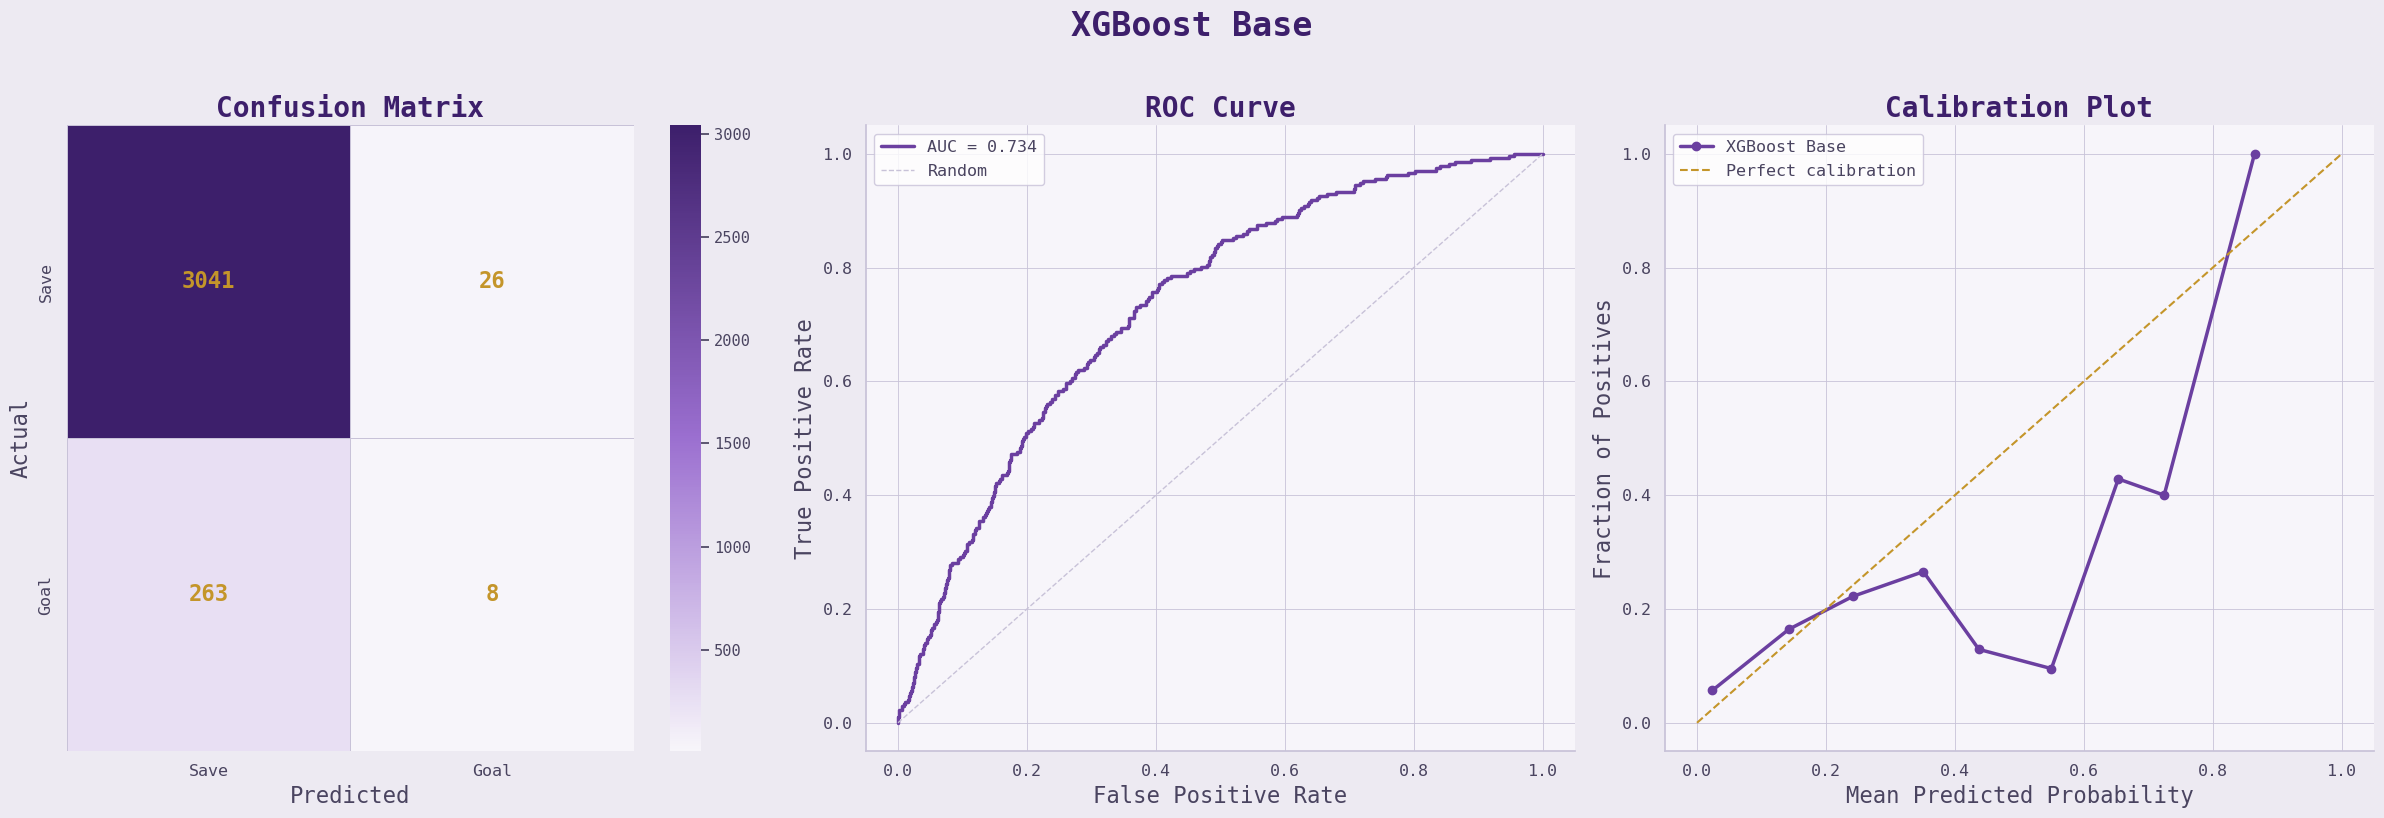

In [62]:
model_eval(model, X_test, y_test, "XGBoost Base")

In [92]:
param_grid = {
    'n_estimators':  [100, 200, 300, 400, 500],
    'max_depth':     [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample':     [0.5, 0.6, 0.7, 0.8],
}

grid = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6} 0.7705354677146952



  XGBoost - Tuned Unweighted
  Baseline (always predict save): 91.87%
  Accuracy:                       91.91%
  AUC:                            0.775
  Log Loss:                       0.244
  Avg Precision (PR-AUC):         0.236

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.56      0.02      0.04       271

    accuracy                           0.92      3338
   macro avg       0.74      0.51      0.50      3338
weighted avg       0.89      0.92      0.88      3338



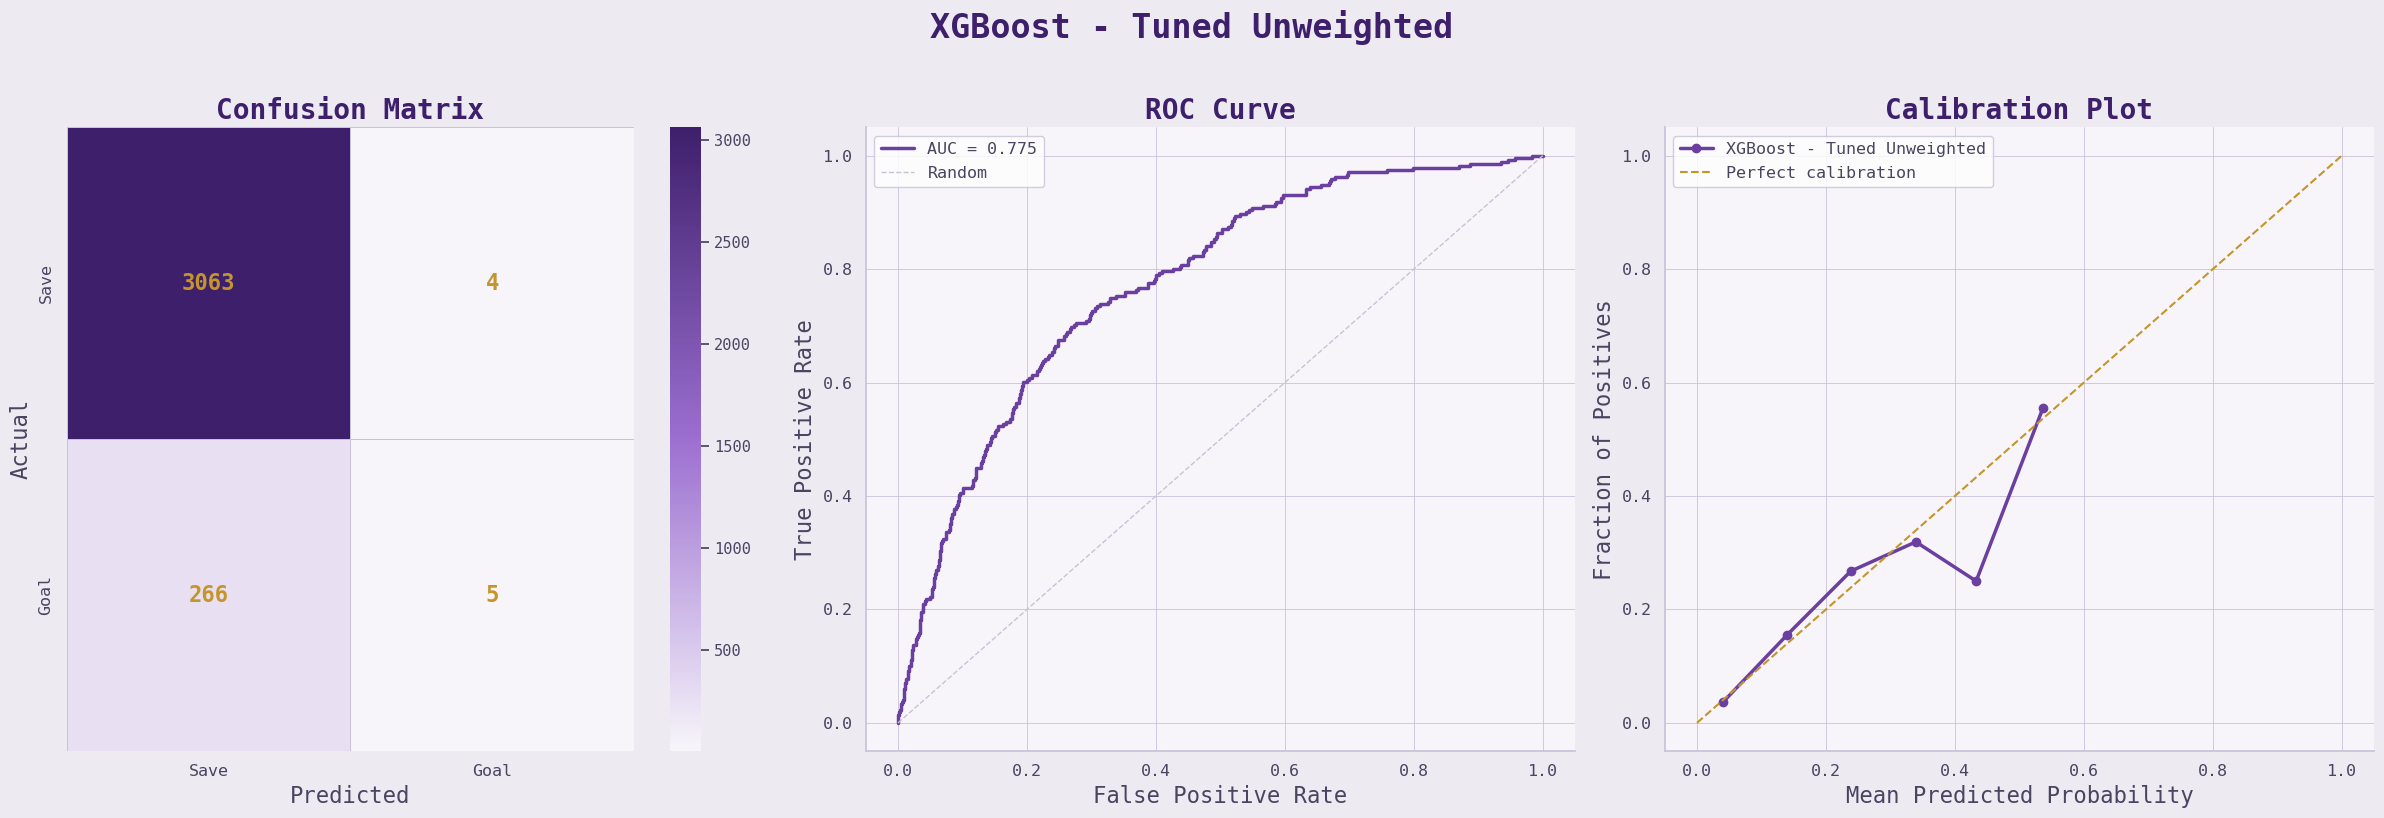

In [93]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 200,
                    max_depth = 3,
                    learning_rate = 0.05,
                    subsample = 0.6)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Tuned Unweighted")

In [88]:
pd.DataFrame(eval_list).sort_values(['auc', 'accuracy'], ascending = [False, False])

model  accuracy     auc  \
20            Log Reg C 500 — Full Set Standard Scale    0.9188  0.7747   
21  Lowered (0.25) Log Reg C 500 — Full Set Standa...    0.9005  0.7747   
2                   Log Reg — Full Set Standard Scale    0.9191  0.7743   
14   Lowered (0.25) Log Reg — Full Set Standard Scale    0.9008  0.7743   
15    Lowered (0.1) Log Reg — Full Set Standard Scale    0.7349  0.7743   
6          Balanced Log Reg — Full Set Standard Scale    0.6705  0.7734   
7            Balanced Log Reg — Full Set MinMax Scale    0.6735  0.7721   
11              SMOTE Log Reg — Full Set MinMax Scale    0.6762  0.7717   
10            SMOTE Log Reg — Full Set Standard Scale    0.6765  0.7714   
3                     Log Reg - Full Set MinMax Scale    0.9185  0.7709   
24        Log Reg C 10 — Even Strength Standard Scale    0.9087  0.7585   
25  Lowered (0.25) Log Reg C 10 — Even Strength St...    0.8881  0.7585   
0                            Base Logistic Regression    0.9185  0.7485   
26                                       XGBoost Base    0.9134  0.7341   
27                                     XGBoost - Base    0.9134  0.7341   
28                                 XGBoost - Balanced    0.8583  0.7319   
31                                 XGBoost - Balanced    0.8442  0.7283   
5                     Selected Log Reg - MinMax Scale    0.9188  0.7229   
18   Lowered (0.25) Log Reg — Selected Set MinMax ...    0.9059  0.7229   
22       Log Reg C 1000 — Selected Set Standard Scale    0.9188  0.7226   
4                   Selected Log Reg - Standard Scale    0.9185  0.7226   
16   Lowered (0.25) Log Reg — Selected Set Standar...    0.9056  0.7226   
23  Lowered (0.25) Log Reg C 1000 — Selected Set S...    0.9050  0.7226   
32                                 XGBoost - Balanced    0.8916  0.7226   
17   Lowered (0.1) Log Reg — Selected Set Standard...    0.7163  0.7226   
19   Lowered (0.1) Log Reg — Selected Set Standard...    0.7163  0.7226   
33                                 XGBoost - Balanced    0.8319  0.7210   
34                          XGBoost - Balance Doubled    0.8319  0.7210   
9        Balanced Log Reg — Selected Set MinMax Scale    0.6300  0.7209   
8      Balanced Log Reg — Selected Set Standard Scale    0.6318  0.7208   
12        SMOTE Log Reg — Selected Set Standard Scale    0.6315  0.7207   
13        SMOTE Log Reg — Selected Set Standard Scale    0.6306  0.7204   
35                          XGBoost - Weighted Halved    0.8844  0.7194   
29                              XGBoost - Re-Balanced    0.8553  0.7169   
36                                 XGBoost - Weighted    0.8553  0.7169   
1                        Selected Logistic Regression    0.9188  0.7152   
30                                 XGBoost - Balanced    0.8250  0.7057   

    log_loss  avg_prec  
20    0.2442    0.2415  
21    0.2442    0.2415  
2     0.2443    0.2418  
14    0.2443    0.2418  
15    0.2443    0.2418  
6     0.5755    0.2361  
7     0.5770    0.2349  
11    0.5741    0.2313  
10    0.5712    0.2342  
3     0.2454    0.2372  
24    0.2689    0.2436  
25    0.2689    0.2436  
0     0.2521    0.1994  
26    0.2791    0.1851  
27    0.2791    0.1851  
28    0.3329    0.1852  
31    0.3488    0.1844  
5     0.2575    0.1948  
18    0.2575    0.1948  
22    0.2576    0.1951  
4     0.2576    0.1952  
16    0.2576    0.1952  
23    0.2576    0.1951  
32    0.3005    0.1870  
17    0.2576    0.1952  
19    0.2576    0.1952  
33    0.3834    0.1714  
34    0.3834    0.1714  
9     0.6216    0.1947  
8     0.6218    0.1947  
12    0.6203    0.1940  
13    0.6205    0.1937  
35    0.3026    0.1842  
29    0.3441    0.1752  
36    0.3441    0.1752  
1     0.2597    0.1854  
30    0.3858    0.1726

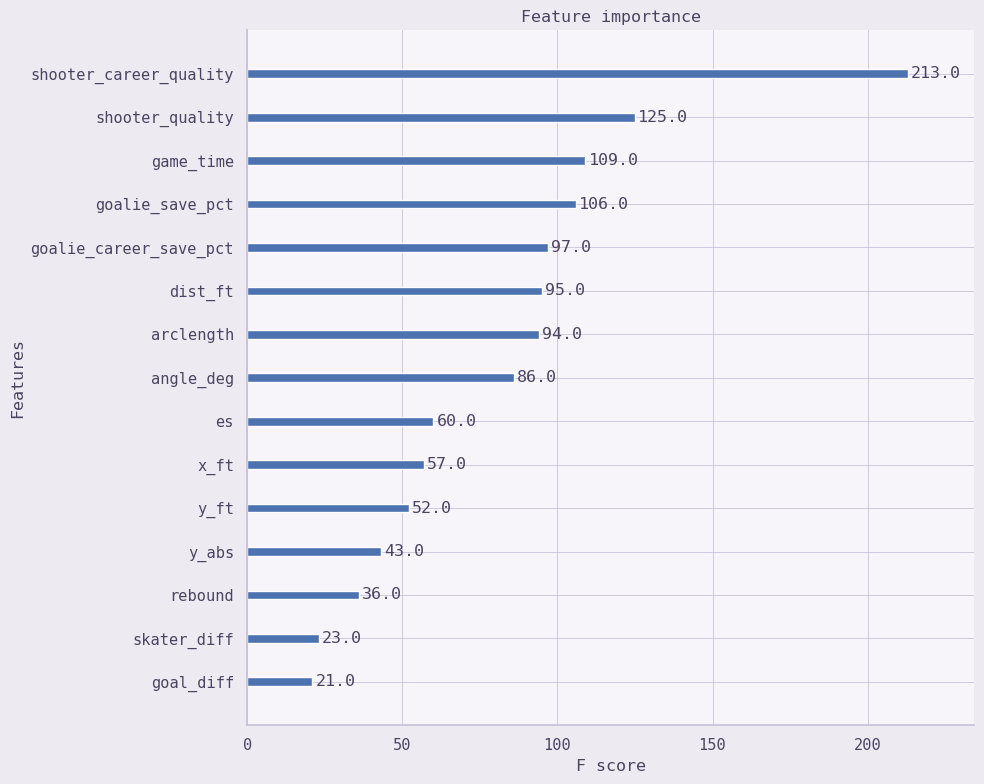

In [95]:
fig, ax = plt.subplots(figsize=(10, 8), facecolor=PWHL["bg"])
plot_importance(xgb, ax=ax, max_num_features=15)
plt.tight_layout()
display(fig)
plt.close(fig)

In [ ]:
param_grid = {
    'n_estimators':  [100, 200, 300, 400, 500],
    'max_depth':     [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample':     [0.5, 0.6, 0.7, 0.8],
}

grid = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)


  XGBoost - Selected Data
  Baseline (always predict save): 91.87%
  Accuracy:                       91.34%
  AUC:                            0.678
  Log Loss:                       0.285
  Avg Precision (PR-AUC):         0.149

              precision    recall  f1-score   support

        Save       0.92      0.99      0.95      3067
        Goal       0.18      0.02      0.03       271

    accuracy                           0.91      3338
   macro avg       0.55      0.51      0.49      3338
weighted avg       0.86      0.91      0.88      3338



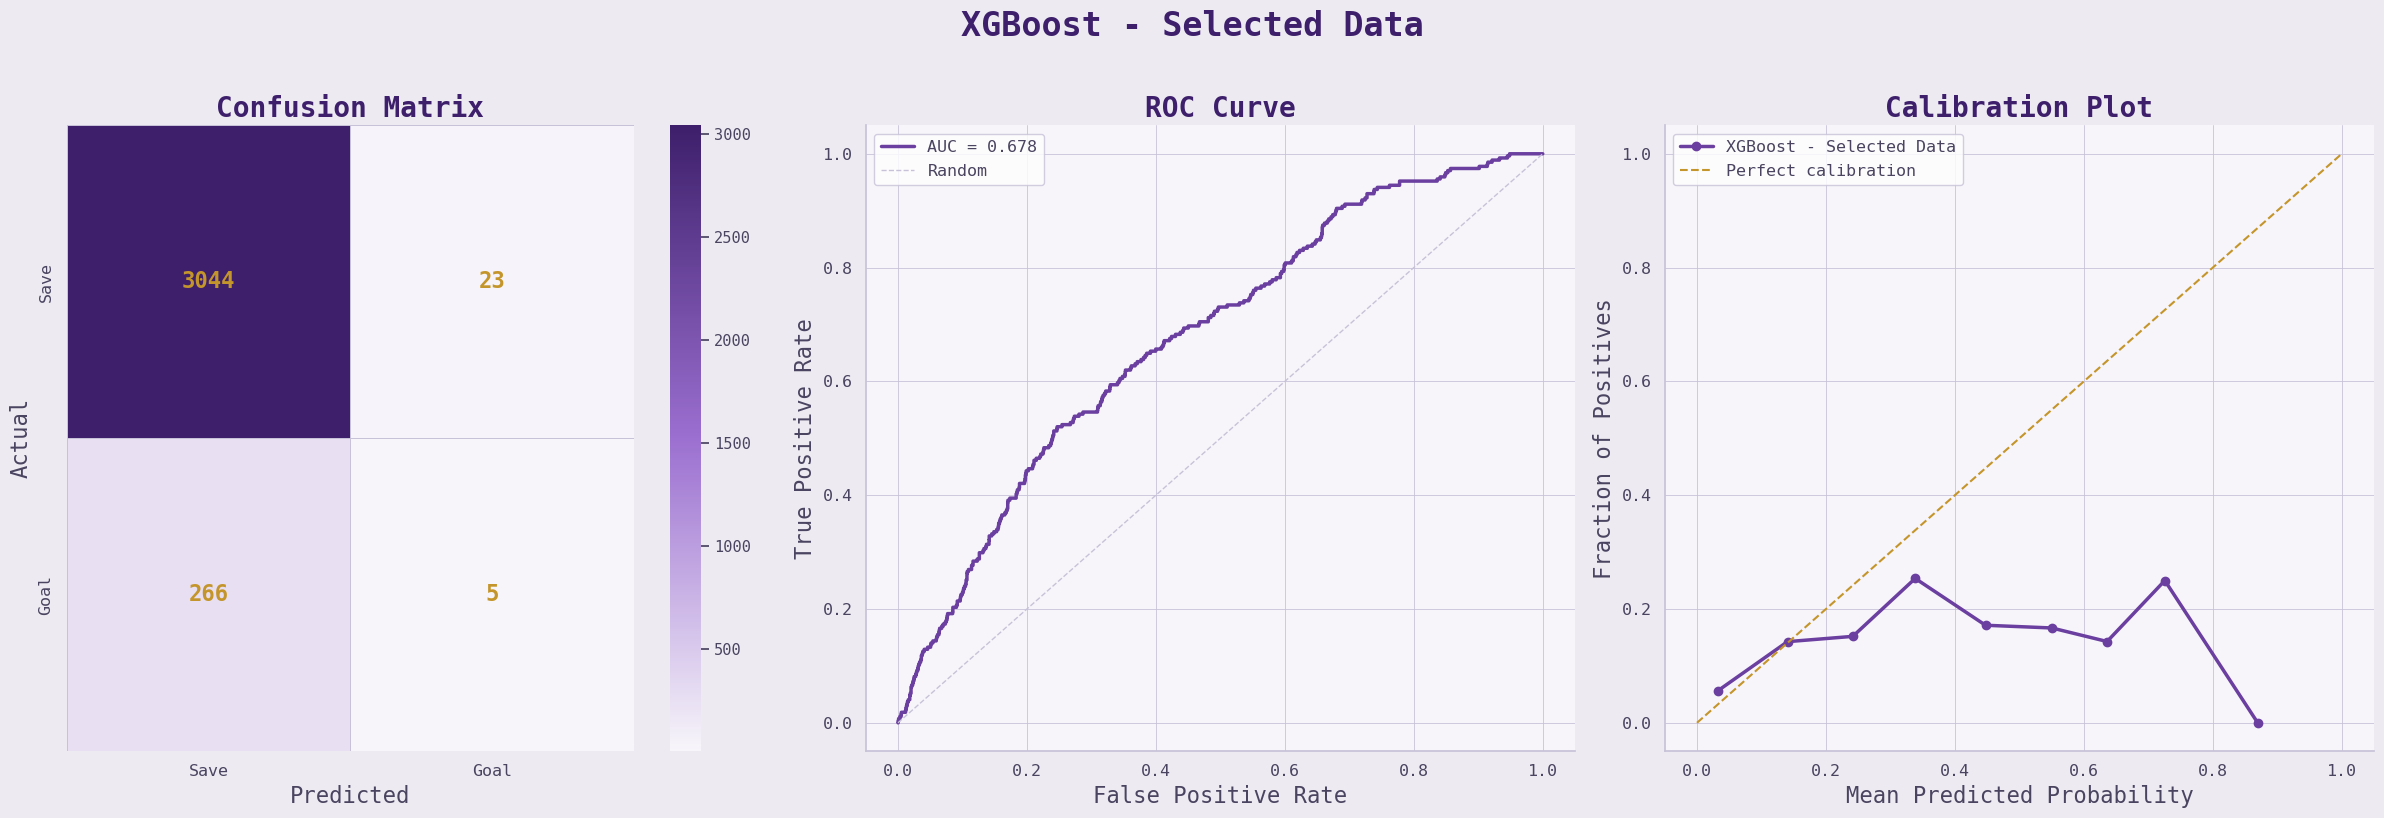

In [96]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss')

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Data")


  XGBoost - Selected Data Weighted
  Baseline (always predict save): 91.87%
  Accuracy:                       79.78%
  AUC:                            0.66
  Log Loss:                       0.434
  Avg Precision (PR-AUC):         0.135

              precision    recall  f1-score   support

        Save       0.93      0.84      0.88      3067
        Goal       0.15      0.33      0.21       271

    accuracy                           0.80      3338
   macro avg       0.54      0.59      0.55      3338
weighted avg       0.87      0.80      0.83      3338



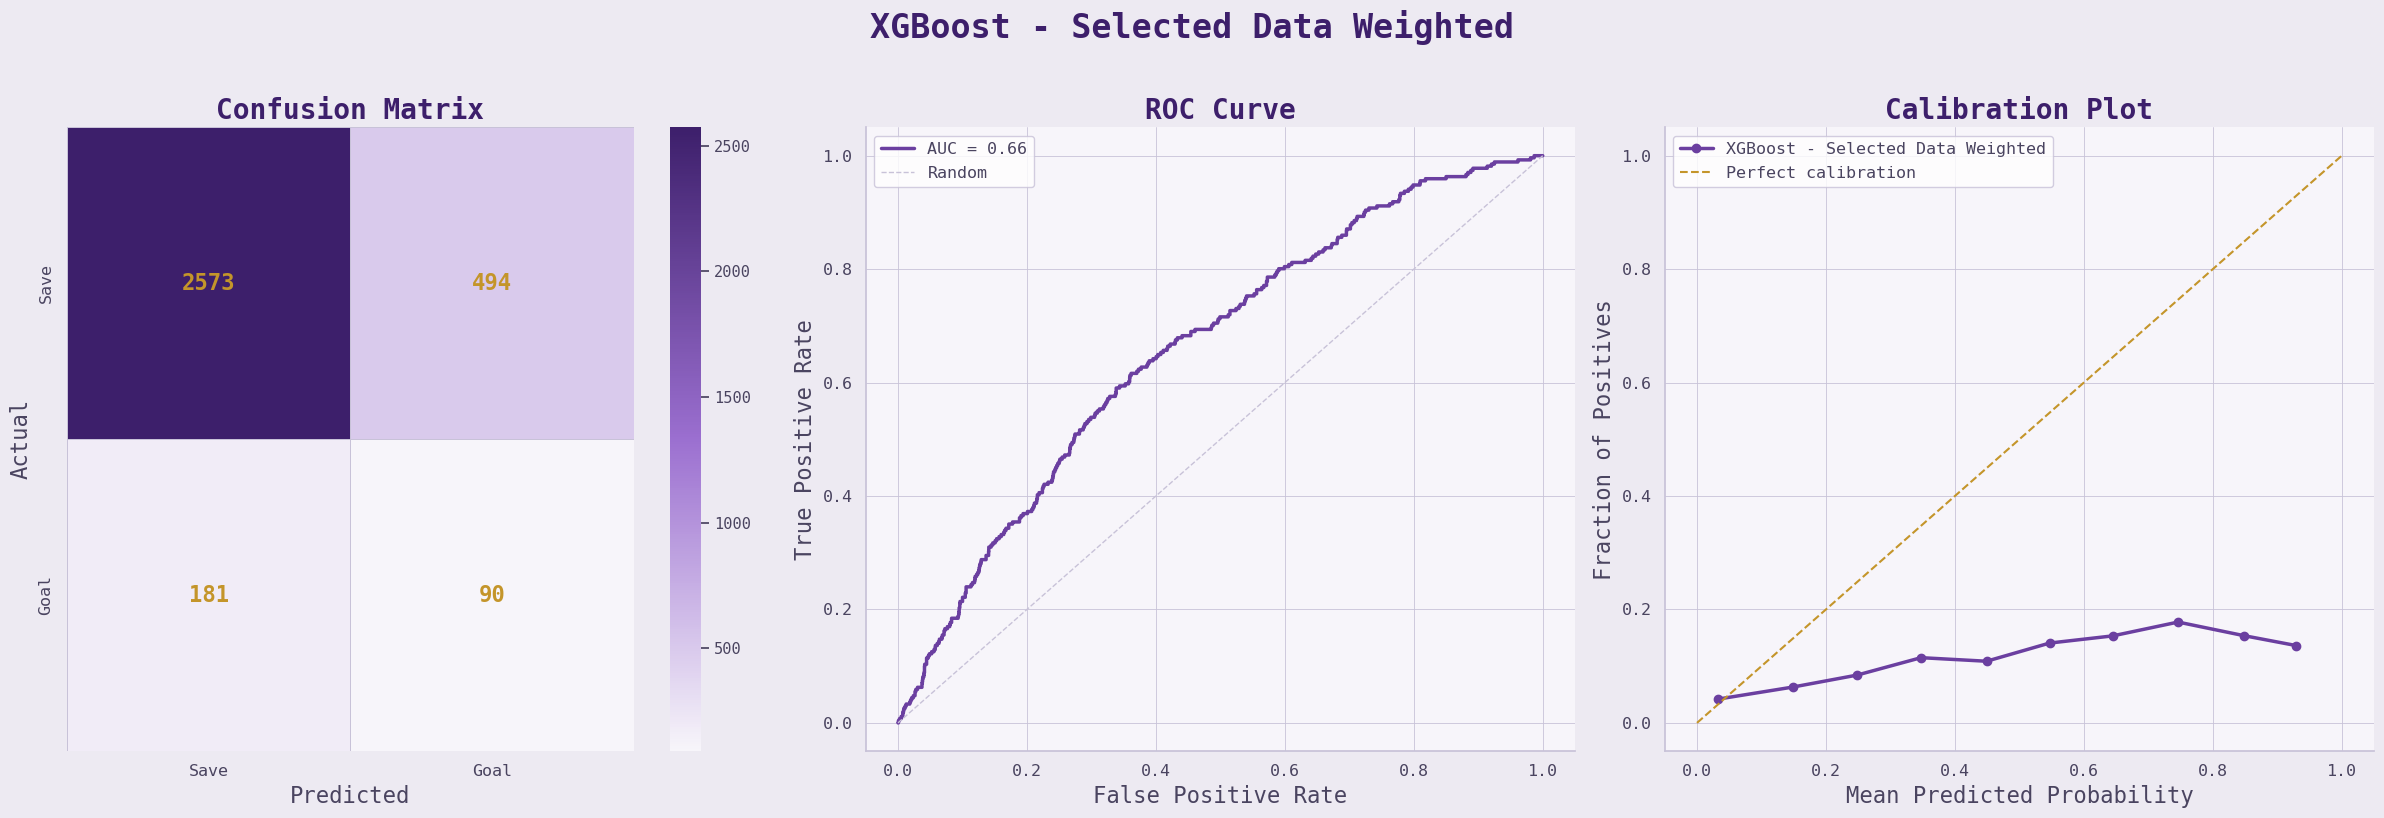

In [99]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])))

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Data Weighted")


  XGBoost - Selected Data Weighted Doubled
  Baseline (always predict save): 91.87%
  Accuracy:                       71.87%
  AUC:                            0.653
  Log Loss:                       0.542
  Avg Precision (PR-AUC):         0.14

              precision    recall  f1-score   support

        Save       0.94      0.74      0.83      3067
        Goal       0.13      0.44      0.20       271

    accuracy                           0.72      3338
   macro avg       0.53      0.59      0.52      3338
weighted avg       0.87      0.72      0.78      3338



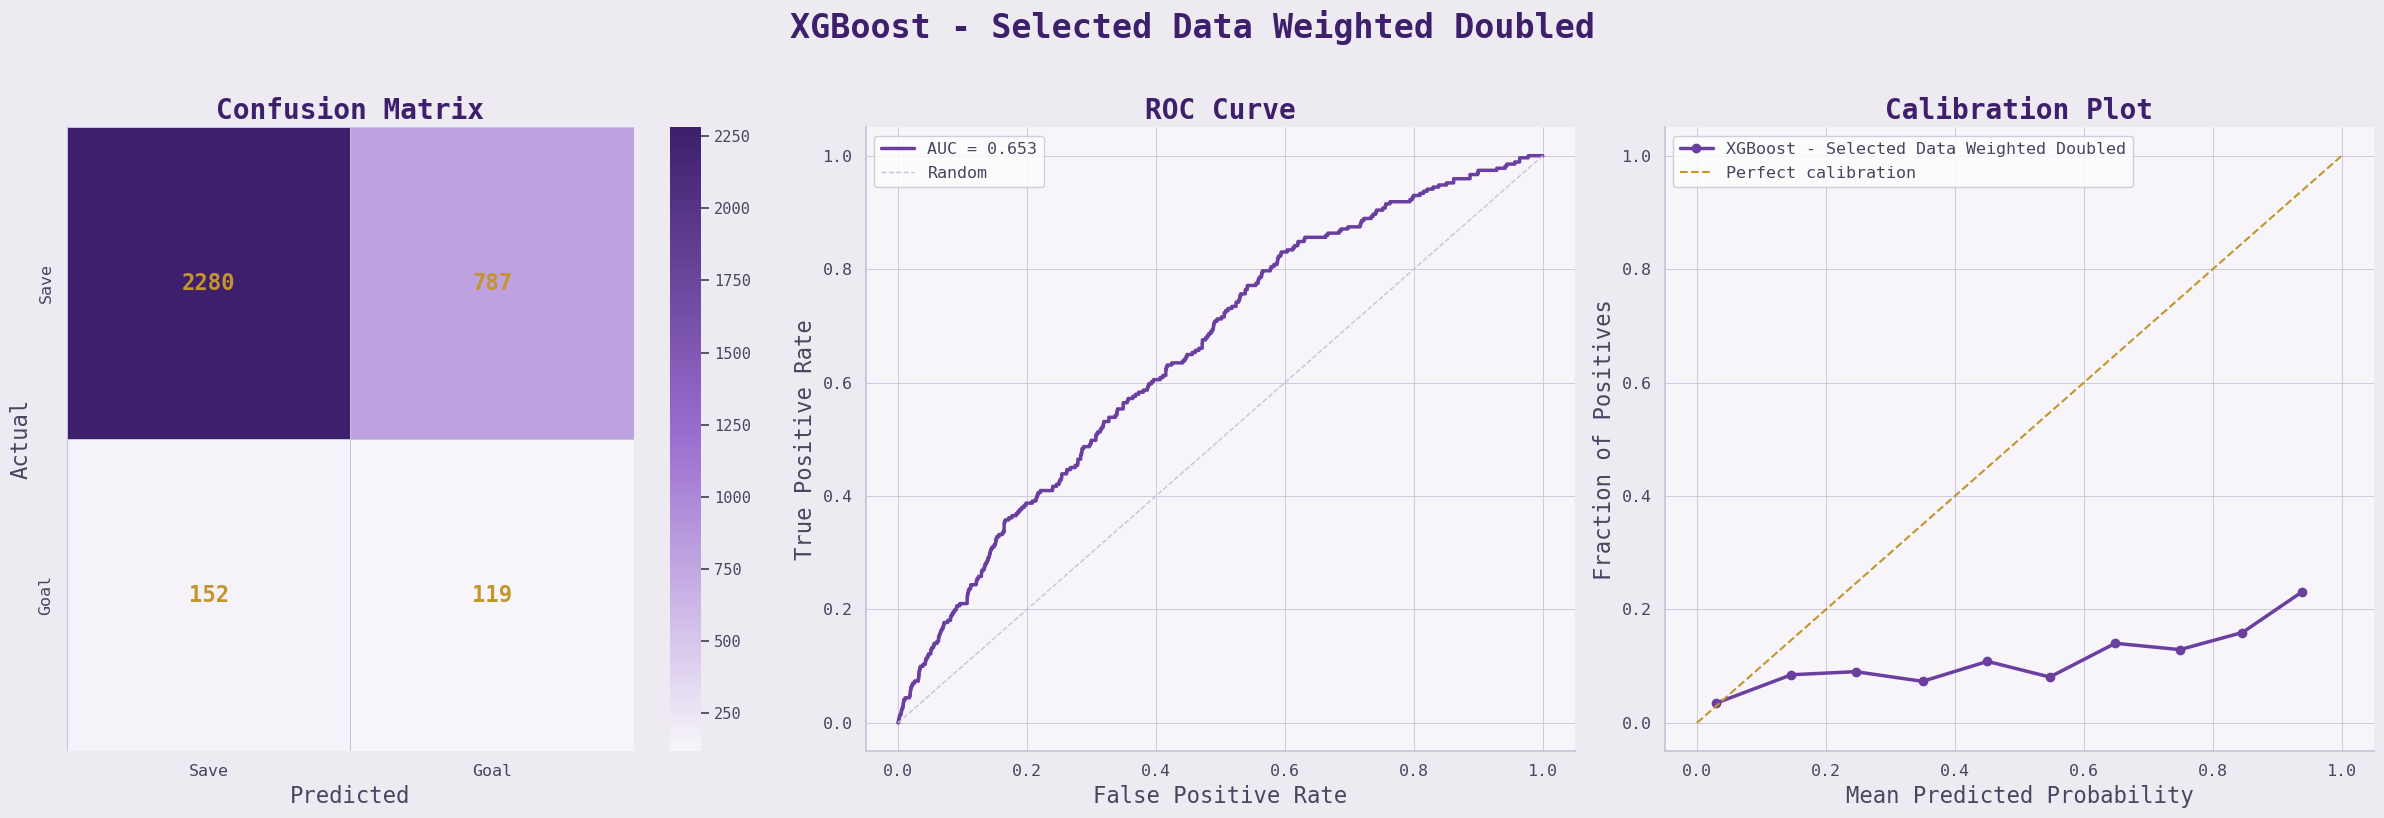

In [98]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])*2))

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Data Weighted Doubled")


  XGBoost - Selected Data Weighted Halved
  Baseline (always predict save): 91.87%
  Accuracy:                       85.71%
  AUC:                            0.677
  Log Loss:                       0.355
  Avg Precision (PR-AUC):         0.153

              precision    recall  f1-score   support

        Save       0.93      0.91      0.92      3067
        Goal       0.19      0.23      0.21       271

    accuracy                           0.86      3338
   macro avg       0.56      0.57      0.56      3338
weighted avg       0.87      0.86      0.86      3338



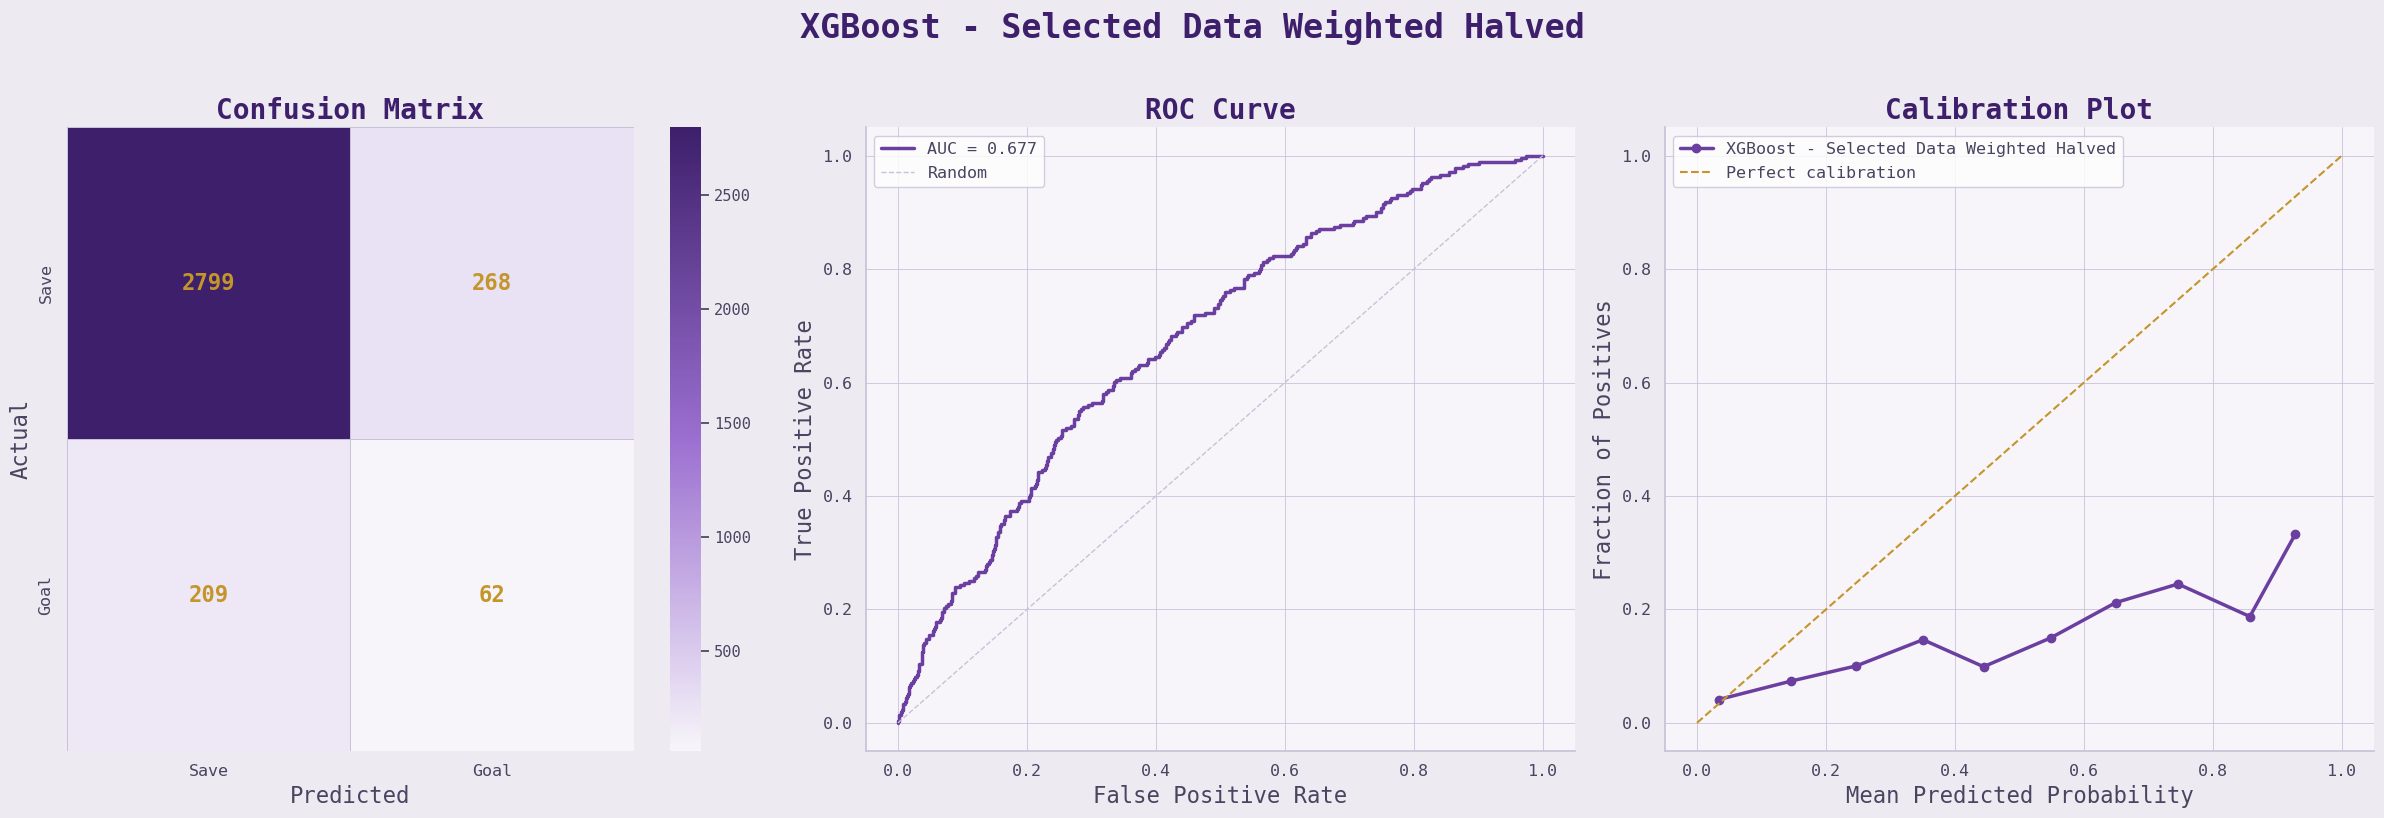

In [100]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])/2))

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Data Weighted Halved")

In [97]:
param_grid = {
    'n_estimators':  [100, 200, 300, 400, 500],
    'max_depth':     [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample':     [0.5, 0.6, 0.7, 0.8],
}

grid = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid.fit(X_train[selected_cols], y_train)
print(grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.5} 0.729408173195241



  XGBoost - Selected Data Tuned Unweighted
  Baseline (always predict save): 91.87%
  Accuracy:                       91.88%
  AUC:                            0.719
  Log Loss:                       0.259
  Avg Precision (PR-AUC):         0.185

              precision    recall  f1-score   support

        Save       0.92      1.00      0.96      3067
        Goal       0.00      0.00      0.00       271

    accuracy                           0.92      3338
   macro avg       0.46      0.50      0.48      3338
weighted avg       0.84      0.92      0.88      3338



/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

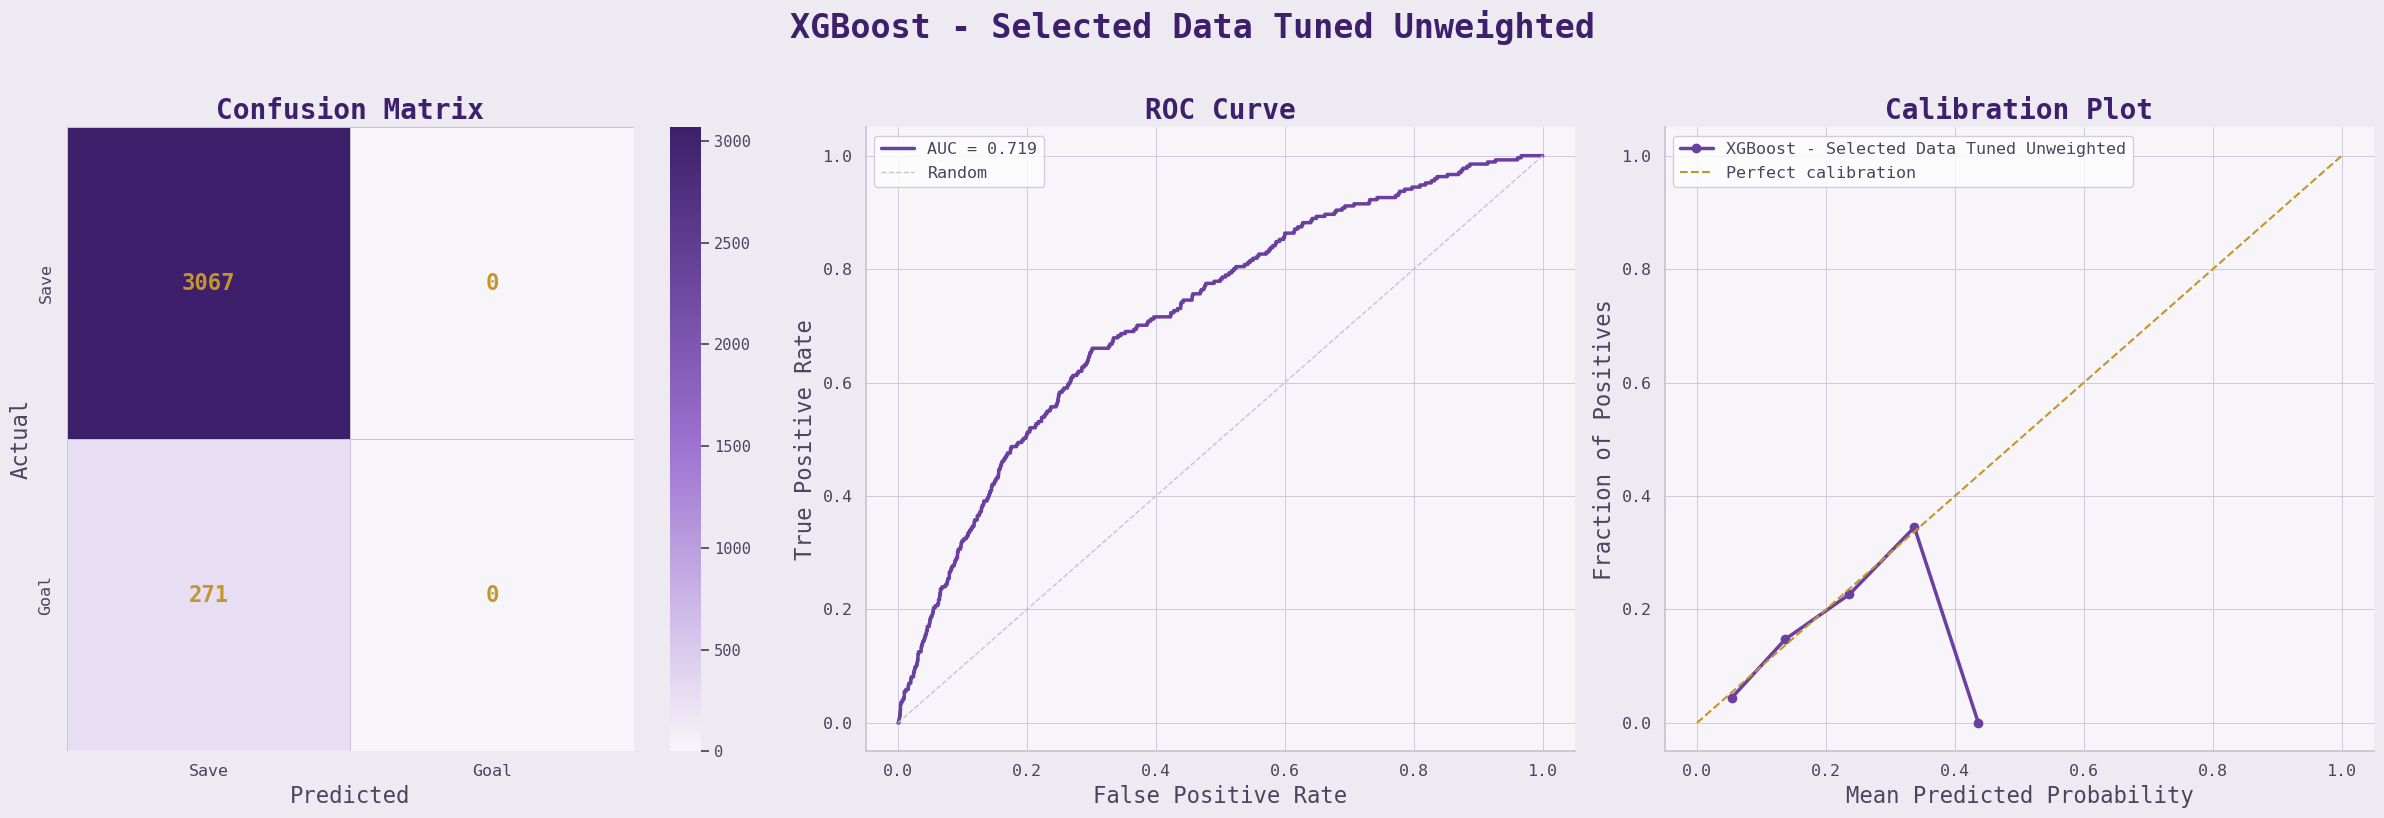

In [101]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 300,
                    max_depth = 3,
                    learning_rate = 0.01,
                    subsample = 0.5)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Data Tuned Unweighted")

In [105]:
weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

In [106]:
param_grid = {
    'n_estimators':  [100, 200, 300, 400, 500],
    'max_depth':     [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample':     [0.5, 0.6, 0.7, 0.8],
    'scale_pos_weight': [weight, weight*2, weight/2]
}

grid = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid.fit(X_train[selected_cols], y_train)
print(grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 5.652073732718894, 'subsample': 0.5} 0.729652583782484



  XGBoost - Selected Data Tuned Weighted
  Baseline (always predict save): 91.87%
  Accuracy:                       86.22%
  AUC:                            0.72
  Log Loss:                       0.413
  Avg Precision (PR-AUC):         0.183

              precision    recall  f1-score   support

        Save       0.93      0.91      0.92      3067
        Goal       0.22      0.27      0.24       271

    accuracy                           0.86      3338
   macro avg       0.58      0.59      0.58      3338
weighted avg       0.88      0.86      0.87      3338



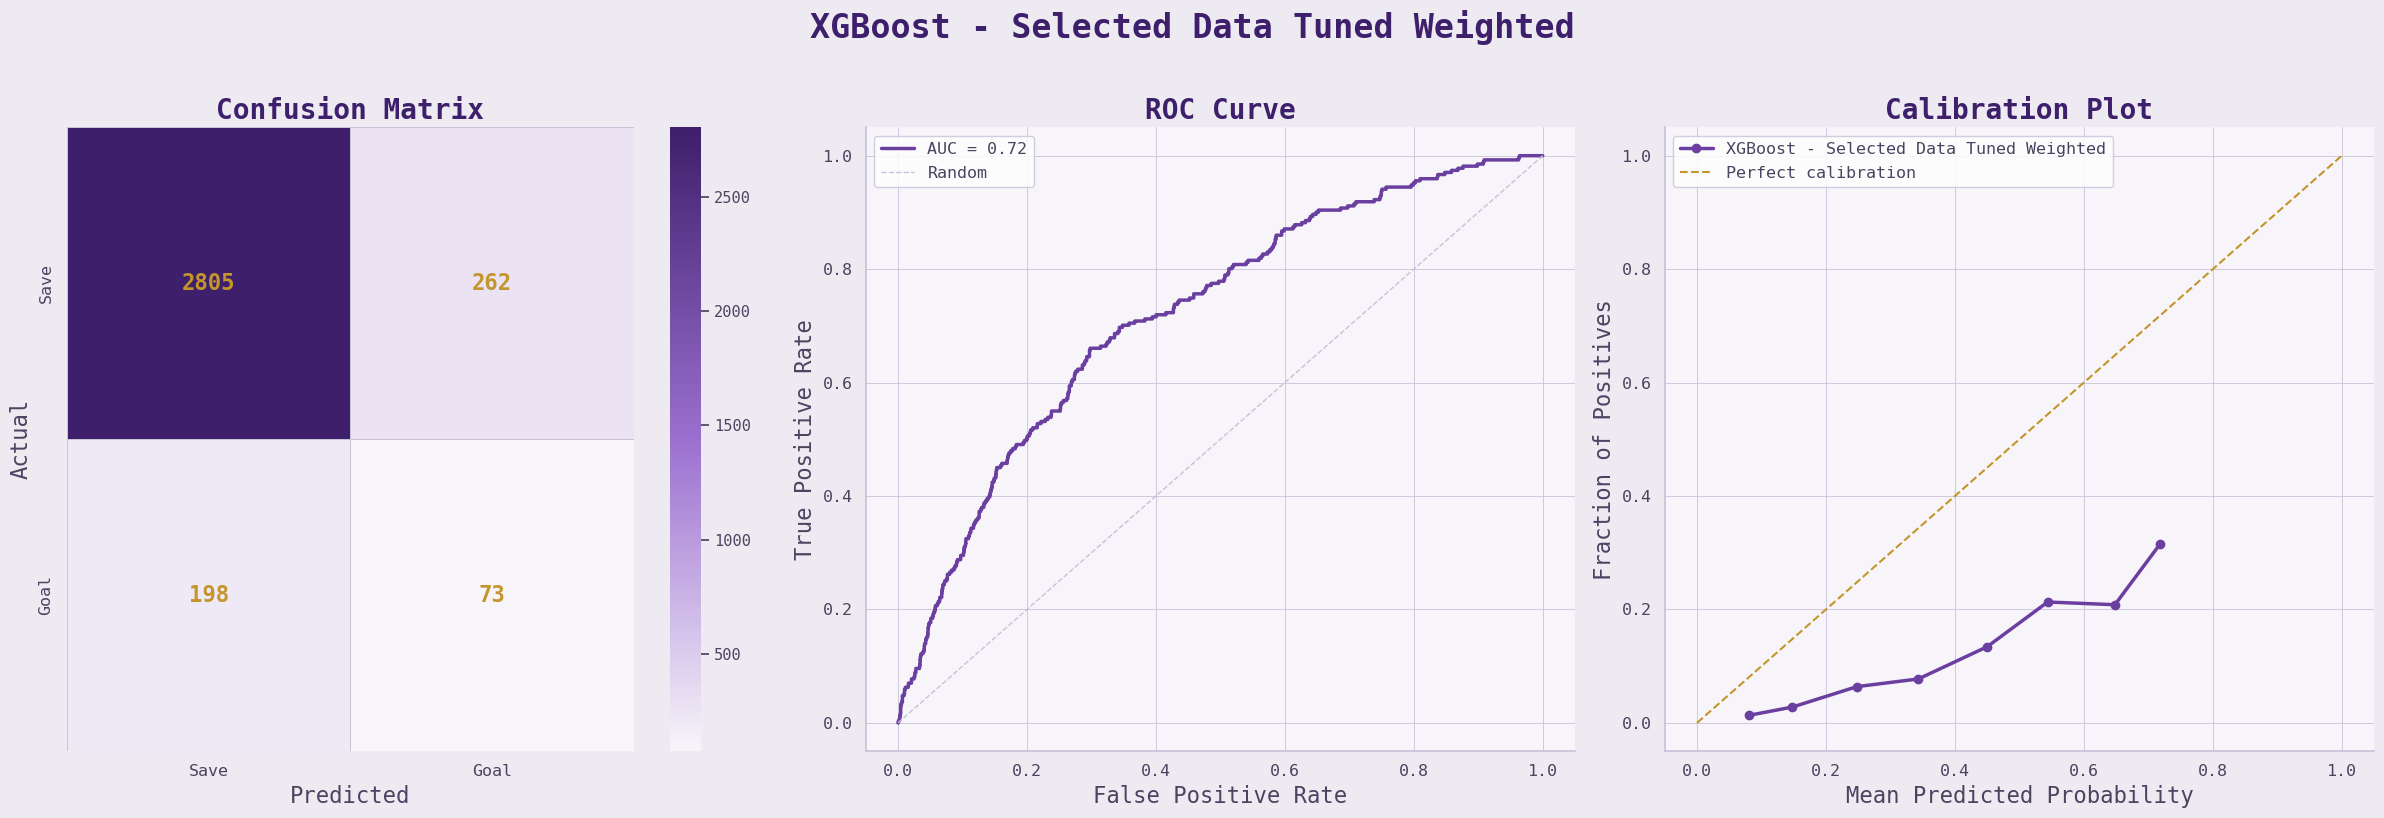

In [108]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 300,
                    max_depth = 3,
                    learning_rate = 0.01,
                    scale_pos_weight = weight/2,
                    subsample = 0.5)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Data Tuned Weighted")

In [109]:
df

home_team_skaters  away_team_skaters  period_1  period_2  period_3  \
0                      5                  5         1         0         0   
1                      5                  5         1         0         0   
2                      5                  5         1         0         0   
3                      5                  5         1         0         0   
4                      5                  5         1         0         0   
...                  ...                ...       ...       ...       ...   
16683                  5                  5         0         0         1   
16684                  4                  5         0         0         1   
16685                  4                  5         0         0         1   
16686                  5                  5         0         0         1   
16687                  5                  5         0         0         1   

         game_time       x_ft       y_ft      y_abs  dist_ft  angle_deg  \
0        30.266666  75.142281  15.844118  15.844118     21.0       48.8   
1        57.900000  81.272430  -0.252941   0.252941      7.7        1.9   
2       134.866670  85.295959 -36.464706  36.464706     36.7       84.2   
3       298.133330  67.598160   0.252941   0.252941     21.4        0.7   
4       301.500000  43.458725 -32.444130  32.444130     55.9       35.5   
...            ...        ...        ...        ...      ...        ...   
16683  3041.000000  70.000000 -20.429825  20.429825     27.9       47.1   
16684  3261.000000  71.333333  -0.447368   0.447368     17.7        1.5   
16685  3265.000000  75.000000   2.236842   2.236842     14.2        9.1   
16686  3341.000000  73.333333   5.517544   5.517544     16.6       19.4   
16687  3553.000000  59.666667  17.447368  17.447368     34.1       30.7   

       arclength  shooter_quality  shooter_career_quality  goalie_save_pct  \
0      17.886134         0.081256                0.061335         0.918744   
1       0.255342         0.081256                0.071575         0.918744   
2      53.933117         0.081256                0.111090         0.920337   
3       0.261450         0.081256                0.099041         0.920337   
4      34.635186         0.081256                0.085613         0.921869   
...          ...              ...                     ...              ...   
16683  22.935197         0.093751                0.093751         0.891849   
16684   0.463385         0.101462                0.101024         0.892377   
16685   2.255314         0.101024                0.101024         0.892899   
16686   5.620658         0.081869                0.081869         0.905829   
16687  18.271328         0.103202                0.103202         0.893416   

       goalie_career_save_pct  home_score  away_score  goal_diff  losing  \
0                    0.926386           0           0          0       0   
1                    0.911145           0           0          0       0   
2                    0.911145           0           0          0       0   
3                    0.926386           0           0          0       0   
4                    0.926386           0           0          0       0   
...                       ...         ...         ...        ...     ...   
16683                0.893416           3           1         -2       1   
16684                0.893416           3           1         -2       1   
16685                0.893416           3           1         -2       1   
16686                0.905829           3           1          2       0   
16687                0.893416           3           1         -2       1   

       tied  winning  skater_diff  es  pp  sh  rebound  backhand  other  slap  \
0         1        0            0   1   0   0        0         0      0     0   
1         1        0            0   1   0   0        0         0      0     0   
2         1        0            0   1   0   0        0         0      0     0   
3      

In [111]:
(df['other'] != 1) & (df['es'] == 1)

0         True
1         True
2         True
3         True
4         True
         ...  
16683     True
16684    False
16685    False
16686     True
16687    False
Length: 16688, dtype: bool

In [ ]:
df[['game_time', 'x_ft', 'y_abs', 'dist_ft', 'angle_deg', 'shooter_career_quality', 'goalie_career_save_pct',
   'goal_diff', 'rebound', 'backhand', 'slap', 'snap', 'tip', 'wrist', ]]